## GPS Spoofing Detection

### 1. load data and preprocess

In [1]:
# Load Data
import DataLoader
import os
import numpy as np
import config

A, B = DataLoader.load_image_pairs(path=config.SWISS_RESIZED)
assert A.shape[0]==B.shape[0]
n = A.shape[0]
print(A.shape, B.shape)

# Some configuration
feature_map_file_name = './mid_product/features_swiss_res34_eval.h5'#'features_suzhou_res50.h5'
#feature_map_file_name = config.FULL_RESIZED_FEATURE
dst_file_name = './mid_product/dst_swiss_res34_eval.npy'# 'dst_suzhou_res50.npy' 
# feature_shape = (512, 18, 26) # SWISS, resnet-18/34
feature_shape = (512, 17, 34) # SUZHOU, 1280x720, resnet-18/34
# feature_shape = (2048, 17, 34) # SUZHOU, resnet-50

(313, 720, 1280, 3) (313, 720, 1280, 3)


In [2]:
# Preprocess data by doing transformation
import torch

A = A.astype(np.float)/255.0
B = B.astype(np.float)/255.0 #.transpose(0,3,1,2)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
x_a = torch.from_numpy((A-mean)/std).permute(0,3,1,2).float()
x_b = torch.from_numpy((B-mean)/std).permute(0,3,1,2).float()
print(x_a.size(), x_b.size())

torch.Size([313, 3, 720, 1280]) torch.Size([313, 3, 720, 1280])


### 2. get feature maps

In [3]:
import torchvision.models as models
from torch import nn

pretrained_model = models.resnet34(pretrained=True)
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False

In [4]:
# Generate feature map and save
import h5py

def h5_save(fname, f_a, f_b):
    '''save f_a and f_b as fname'''
    with h5py.File(fname,'w') as f:
        f.create_dataset('f_a', data=f_a)
        f.create_dataset('f_b', data=f_b)
    
def h5_read(fname):
    '''read fname and return f_a and f_b'''
    with h5py.File(fname,'r') as f:
        return f['f_a'][:], f['f_b'][:]

if not os.path.exists(feature_map_file_name):
    f_a = np.zeros((n,)+feature_shape)
    f_b = np.zeros((n,)+feature_shape)
    for i in range(n):
        print( "Generating feature maps of %d / %d th pair."%(i+1, n), end='\r')
        a = feature_extractor(x_a[i:i+1,:,:,:])
        b = feature_extractor(x_b[i:i+1,:,:,:])
        f_a[i] = a.detach().numpy()
        f_b[i] = b.detach().numpy()
    h5_save(feature_map_file_name, f_a, f_b)
else:
    print("Feature maps file already exists, we just read it.")
    f_a, f_b = h5_read(feature_map_file_name)

In [5]:
# compute distance between unpaird and paired images
print("A domain feature maps size:", f_a.shape)
dst=np.zeros((n,n))
for shift in range(n):
    for idx in range(n):
        a = f_a[idx:idx+1]
        b = f_b[(idx+shift)%n:(idx+shift)%n+1]
        dst[idx,shift] = np.linalg.norm(a - b)
        print('dst(idx,shift)(%d,%d)=%f' % (idx,shift,dst[idx,shift]))
np.save(dst_file_name, dst)

A domain feature maps size: (313, 512, 17, 34)
dst(idx,shift)(0,0)=492.029684
dst(idx,shift)(1,0)=368.198248
dst(idx,shift)(2,0)=350.930037
dst(idx,shift)(3,0)=368.992086
dst(idx,shift)(4,0)=405.538914
dst(idx,shift)(5,0)=414.936956
dst(idx,shift)(6,0)=412.504096
dst(idx,shift)(7,0)=409.998402
dst(idx,shift)(8,0)=388.694653
dst(idx,shift)(9,0)=336.446970
dst(idx,shift)(10,0)=307.175123
dst(idx,shift)(11,0)=280.460000
dst(idx,shift)(12,0)=339.939145
dst(idx,shift)(13,0)=486.436652
dst(idx,shift)(14,0)=547.315530
dst(idx,shift)(15,0)=440.897929
dst(idx,shift)(16,0)=323.480576
dst(idx,shift)(17,0)=285.991856
dst(idx,shift)(18,0)=269.478638
dst(idx,shift)(19,0)=293.450874
dst(idx,shift)(20,0)=321.053436
dst(idx,shift)(21,0)=350.599721
dst(idx,shift)(22,0)=367.909826
dst(idx,shift)(23,0)=325.734055
dst(idx,shift)(24,0)=309.691478
dst(idx,shift)(25,0)=303.179644
dst(idx,shift)(26,0)=292.562012
dst(idx,shift)(27,0)=277.407425
dst(idx,shift)(28,0)=289.520349
dst(idx,shift)(29,0)=386.172889
dst

dst(idx,shift)(17,1)=383.425657
dst(idx,shift)(18,1)=386.227948
dst(idx,shift)(19,1)=402.019750
dst(idx,shift)(20,1)=416.816620
dst(idx,shift)(21,1)=435.929664
dst(idx,shift)(22,1)=423.771444
dst(idx,shift)(23,1)=400.715711
dst(idx,shift)(24,1)=370.728193
dst(idx,shift)(25,1)=396.697925
dst(idx,shift)(26,1)=366.138659
dst(idx,shift)(27,1)=362.930213
dst(idx,shift)(28,1)=439.420128
dst(idx,shift)(29,1)=511.491635
dst(idx,shift)(30,1)=512.088285
dst(idx,shift)(31,1)=398.841693
dst(idx,shift)(32,1)=346.815692
dst(idx,shift)(33,1)=320.302390
dst(idx,shift)(34,1)=393.410723
dst(idx,shift)(35,1)=387.594255
dst(idx,shift)(36,1)=445.541392
dst(idx,shift)(37,1)=421.834720
dst(idx,shift)(38,1)=402.012719
dst(idx,shift)(39,1)=376.250692
dst(idx,shift)(40,1)=353.146516
dst(idx,shift)(41,1)=331.995222
dst(idx,shift)(42,1)=359.942693
dst(idx,shift)(43,1)=416.623001
dst(idx,shift)(44,1)=478.226163
dst(idx,shift)(45,1)=499.911310
dst(idx,shift)(46,1)=413.445639
dst(idx,shift)(47,1)=296.640085
dst(idx,

dst(idx,shift)(39,2)=373.606792
dst(idx,shift)(40,2)=348.796933
dst(idx,shift)(41,2)=383.931782
dst(idx,shift)(42,2)=445.201231
dst(idx,shift)(43,2)=502.118143
dst(idx,shift)(44,2)=477.516448
dst(idx,shift)(45,2)=512.455578
dst(idx,shift)(46,2)=409.644746
dst(idx,shift)(47,2)=328.600519
dst(idx,shift)(48,2)=330.787463
dst(idx,shift)(49,2)=363.575700
dst(idx,shift)(50,2)=407.789206
dst(idx,shift)(51,2)=455.650245
dst(idx,shift)(52,2)=488.308966
dst(idx,shift)(53,2)=482.570994
dst(idx,shift)(54,2)=433.541680
dst(idx,shift)(55,2)=349.224944
dst(idx,shift)(56,2)=326.288734
dst(idx,shift)(57,2)=377.984442
dst(idx,shift)(58,2)=448.262163
dst(idx,shift)(59,2)=484.111742
dst(idx,shift)(60,2)=442.466138
dst(idx,shift)(61,2)=427.427494
dst(idx,shift)(62,2)=400.493904
dst(idx,shift)(63,2)=336.702865
dst(idx,shift)(64,2)=314.904943
dst(idx,shift)(65,2)=344.656685
dst(idx,shift)(66,2)=407.229057
dst(idx,shift)(67,2)=460.423738
dst(idx,shift)(68,2)=492.019187
dst(idx,shift)(69,2)=534.273228
dst(idx,

dst(idx,shift)(114,3)=533.010519
dst(idx,shift)(115,3)=512.311946
dst(idx,shift)(116,3)=575.118108
dst(idx,shift)(117,3)=650.268552
dst(idx,shift)(118,3)=532.746477
dst(idx,shift)(119,3)=431.319168
dst(idx,shift)(120,3)=451.129601
dst(idx,shift)(121,3)=474.047431
dst(idx,shift)(122,3)=423.272995
dst(idx,shift)(123,3)=440.570320
dst(idx,shift)(124,3)=395.810909
dst(idx,shift)(125,3)=428.848133
dst(idx,shift)(126,3)=500.344225
dst(idx,shift)(127,3)=527.720760
dst(idx,shift)(128,3)=517.838194
dst(idx,shift)(129,3)=511.647926
dst(idx,shift)(130,3)=614.559078
dst(idx,shift)(131,3)=509.658934
dst(idx,shift)(132,3)=465.734791
dst(idx,shift)(133,3)=504.387537
dst(idx,shift)(134,3)=493.905357
dst(idx,shift)(135,3)=444.218214
dst(idx,shift)(136,3)=469.886627
dst(idx,shift)(137,3)=446.096812
dst(idx,shift)(138,3)=452.023353
dst(idx,shift)(139,3)=497.594559
dst(idx,shift)(140,3)=484.263217
dst(idx,shift)(141,3)=492.973105
dst(idx,shift)(142,3)=554.225160
dst(idx,shift)(143,3)=566.785347
dst(idx,sh

dst(idx,shift)(207,4)=466.078079
dst(idx,shift)(208,4)=492.871993
dst(idx,shift)(209,4)=475.043149
dst(idx,shift)(210,4)=533.504561
dst(idx,shift)(211,4)=526.726172
dst(idx,shift)(212,4)=688.056138
dst(idx,shift)(213,4)=524.601604
dst(idx,shift)(214,4)=495.488990
dst(idx,shift)(215,4)=565.076582
dst(idx,shift)(216,4)=687.265230
dst(idx,shift)(217,4)=496.314421
dst(idx,shift)(218,4)=428.787474
dst(idx,shift)(219,4)=383.517588
dst(idx,shift)(220,4)=410.237848
dst(idx,shift)(221,4)=358.652123
dst(idx,shift)(222,4)=389.655692
dst(idx,shift)(223,4)=394.702660
dst(idx,shift)(224,4)=406.717714
dst(idx,shift)(225,4)=364.596078
dst(idx,shift)(226,4)=410.094031
dst(idx,shift)(227,4)=390.907322
dst(idx,shift)(228,4)=349.103670
dst(idx,shift)(229,4)=366.289615
dst(idx,shift)(230,4)=373.998044
dst(idx,shift)(231,4)=380.102585
dst(idx,shift)(232,4)=436.477163
dst(idx,shift)(233,4)=505.755654
dst(idx,shift)(234,4)=518.612242
dst(idx,shift)(235,4)=652.202703
dst(idx,shift)(236,4)=560.973376
dst(idx,sh

dst(idx,shift)(302,5)=598.155517
dst(idx,shift)(303,5)=549.389623
dst(idx,shift)(304,5)=660.677625
dst(idx,shift)(305,5)=691.756975
dst(idx,shift)(306,5)=679.635410
dst(idx,shift)(307,5)=647.163994
dst(idx,shift)(308,5)=579.020187
dst(idx,shift)(309,5)=550.884084
dst(idx,shift)(310,5)=657.960480
dst(idx,shift)(311,5)=580.812923
dst(idx,shift)(312,5)=553.713501
dst(idx,shift)(0,6)=494.634435
dst(idx,shift)(1,6)=496.785086
dst(idx,shift)(2,6)=509.278794
dst(idx,shift)(3,6)=473.541616
dst(idx,shift)(4,6)=518.303031
dst(idx,shift)(5,6)=496.380303
dst(idx,shift)(6,6)=476.381917
dst(idx,shift)(7,6)=521.939133
dst(idx,shift)(8,6)=562.530053
dst(idx,shift)(9,6)=497.351234
dst(idx,shift)(10,6)=433.599765
dst(idx,shift)(11,6)=418.532943
dst(idx,shift)(12,6)=434.428954
dst(idx,shift)(13,6)=497.374418
dst(idx,shift)(14,6)=540.553904
dst(idx,shift)(15,6)=452.932324
dst(idx,shift)(16,6)=429.932867
dst(idx,shift)(17,6)=401.945547
dst(idx,shift)(18,6)=399.697451
dst(idx,shift)(19,6)=424.759487
dst(idx

dst(idx,shift)(83,7)=381.912884
dst(idx,shift)(84,7)=445.532129
dst(idx,shift)(85,7)=571.725412
dst(idx,shift)(86,7)=580.463521
dst(idx,shift)(87,7)=531.678957
dst(idx,shift)(88,7)=399.140389
dst(idx,shift)(89,7)=357.493891
dst(idx,shift)(90,7)=372.284724
dst(idx,shift)(91,7)=392.941927
dst(idx,shift)(92,7)=490.144521
dst(idx,shift)(93,7)=541.987496
dst(idx,shift)(94,7)=572.343000
dst(idx,shift)(95,7)=544.307044
dst(idx,shift)(96,7)=443.254378
dst(idx,shift)(97,7)=398.832333
dst(idx,shift)(98,7)=389.206094
dst(idx,shift)(99,7)=447.567324
dst(idx,shift)(100,7)=551.824554
dst(idx,shift)(101,7)=672.541569
dst(idx,shift)(102,7)=634.781733
dst(idx,shift)(103,7)=541.765690
dst(idx,shift)(104,7)=437.870093
dst(idx,shift)(105,7)=374.011817
dst(idx,shift)(106,7)=354.482221
dst(idx,shift)(107,7)=389.635017
dst(idx,shift)(108,7)=502.565563
dst(idx,shift)(109,7)=521.028819
dst(idx,shift)(110,7)=554.133701
dst(idx,shift)(111,7)=493.831321
dst(idx,shift)(112,7)=419.972059
dst(idx,shift)(113,7)=354.1

dst(idx,shift)(179,8)=520.329504
dst(idx,shift)(180,8)=563.093740
dst(idx,shift)(181,8)=533.695563
dst(idx,shift)(182,8)=477.812868
dst(idx,shift)(183,8)=540.462552
dst(idx,shift)(184,8)=542.926016
dst(idx,shift)(185,8)=538.296747
dst(idx,shift)(186,8)=541.020963
dst(idx,shift)(187,8)=522.729041
dst(idx,shift)(188,8)=512.497797
dst(idx,shift)(189,8)=509.633595
dst(idx,shift)(190,8)=508.258510
dst(idx,shift)(191,8)=550.845890
dst(idx,shift)(192,8)=555.719567
dst(idx,shift)(193,8)=541.059976
dst(idx,shift)(194,8)=598.008069
dst(idx,shift)(195,8)=546.363143
dst(idx,shift)(196,8)=443.038015
dst(idx,shift)(197,8)=485.379523
dst(idx,shift)(198,8)=424.941597
dst(idx,shift)(199,8)=508.068206
dst(idx,shift)(200,8)=575.579875
dst(idx,shift)(201,8)=581.512146
dst(idx,shift)(202,8)=581.234747
dst(idx,shift)(203,8)=460.037450
dst(idx,shift)(204,8)=446.746402
dst(idx,shift)(205,8)=459.156342
dst(idx,shift)(206,8)=459.573552
dst(idx,shift)(207,8)=529.354656
dst(idx,shift)(208,8)=626.228156
dst(idx,sh

dst(idx,shift)(273,9)=581.979620
dst(idx,shift)(274,9)=640.280160
dst(idx,shift)(275,9)=568.330004
dst(idx,shift)(276,9)=489.507752
dst(idx,shift)(277,9)=520.597367
dst(idx,shift)(278,9)=530.167250
dst(idx,shift)(279,9)=490.829968
dst(idx,shift)(280,9)=490.173872
dst(idx,shift)(281,9)=426.671114
dst(idx,shift)(282,9)=460.369049
dst(idx,shift)(283,9)=487.615376
dst(idx,shift)(284,9)=556.163169
dst(idx,shift)(285,9)=473.700207
dst(idx,shift)(286,9)=527.717637
dst(idx,shift)(287,9)=538.910716
dst(idx,shift)(288,9)=496.664777
dst(idx,shift)(289,9)=472.113211
dst(idx,shift)(290,9)=485.768352
dst(idx,shift)(291,9)=583.668105
dst(idx,shift)(292,9)=520.934112
dst(idx,shift)(293,9)=549.607461
dst(idx,shift)(294,9)=516.927192
dst(idx,shift)(295,9)=687.359969
dst(idx,shift)(296,9)=674.513973
dst(idx,shift)(297,9)=682.148696
dst(idx,shift)(298,9)=609.216450
dst(idx,shift)(299,9)=469.881518
dst(idx,shift)(300,9)=536.683710
dst(idx,shift)(301,9)=536.843942
dst(idx,shift)(302,9)=557.036350
dst(idx,sh

dst(idx,shift)(55,11)=342.286607
dst(idx,shift)(56,11)=366.559864
dst(idx,shift)(57,11)=432.724281
dst(idx,shift)(58,11)=481.143615
dst(idx,shift)(59,11)=489.346772
dst(idx,shift)(60,11)=447.959757
dst(idx,shift)(61,11)=440.395405
dst(idx,shift)(62,11)=432.068585
dst(idx,shift)(63,11)=368.114921
dst(idx,shift)(64,11)=371.055243
dst(idx,shift)(65,11)=439.297876
dst(idx,shift)(66,11)=438.851958
dst(idx,shift)(67,11)=449.711871
dst(idx,shift)(68,11)=446.108347
dst(idx,shift)(69,11)=512.869805
dst(idx,shift)(70,11)=420.933329
dst(idx,shift)(71,11)=372.664373
dst(idx,shift)(72,11)=387.220208
dst(idx,shift)(73,11)=456.721682
dst(idx,shift)(74,11)=515.342111
dst(idx,shift)(75,11)=505.145323
dst(idx,shift)(76,11)=475.328683
dst(idx,shift)(77,11)=445.496763
dst(idx,shift)(78,11)=423.842519
dst(idx,shift)(79,11)=386.709625
dst(idx,shift)(80,11)=377.283456
dst(idx,shift)(81,11)=441.649356
dst(idx,shift)(82,11)=519.105610
dst(idx,shift)(83,11)=525.212842
dst(idx,shift)(84,11)=480.387205
dst(idx,sh

dst(idx,shift)(244,12)=452.353438
dst(idx,shift)(245,12)=556.604074
dst(idx,shift)(246,12)=703.851178
dst(idx,shift)(247,12)=677.820100
dst(idx,shift)(248,12)=551.819736
dst(idx,shift)(249,12)=482.010773
dst(idx,shift)(250,12)=407.672037
dst(idx,shift)(251,12)=372.531570
dst(idx,shift)(252,12)=383.298975
dst(idx,shift)(253,12)=396.236240
dst(idx,shift)(254,12)=350.640656
dst(idx,shift)(255,12)=420.658902
dst(idx,shift)(256,12)=527.648518
dst(idx,shift)(257,12)=513.363557
dst(idx,shift)(258,12)=548.323911
dst(idx,shift)(259,12)=532.509631
dst(idx,shift)(260,12)=545.160212
dst(idx,shift)(261,12)=482.225620
dst(idx,shift)(262,12)=532.609935
dst(idx,shift)(263,12)=550.079640
dst(idx,shift)(264,12)=514.356888
dst(idx,shift)(265,12)=514.287154
dst(idx,shift)(266,12)=550.697768
dst(idx,shift)(267,12)=483.603132
dst(idx,shift)(268,12)=538.971571
dst(idx,shift)(269,12)=498.781545
dst(idx,shift)(270,12)=583.677314
dst(idx,shift)(271,12)=540.200409
dst(idx,shift)(272,12)=596.187232
dst(idx,shift)

dst(idx,shift)(125,14)=356.231424
dst(idx,shift)(126,14)=383.363059
dst(idx,shift)(127,14)=430.454386
dst(idx,shift)(128,14)=478.971308
dst(idx,shift)(129,14)=529.944271
dst(idx,shift)(130,14)=626.761661
dst(idx,shift)(131,14)=517.785484
dst(idx,shift)(132,14)=471.899079
dst(idx,shift)(133,14)=489.831157
dst(idx,shift)(134,14)=466.788075
dst(idx,shift)(135,14)=466.936159
dst(idx,shift)(136,14)=521.866620
dst(idx,shift)(137,14)=477.521556
dst(idx,shift)(138,14)=461.907950
dst(idx,shift)(139,14)=439.808288
dst(idx,shift)(140,14)=460.271541
dst(idx,shift)(141,14)=534.159521
dst(idx,shift)(142,14)=594.139627
dst(idx,shift)(143,14)=572.959105
dst(idx,shift)(144,14)=504.809260
dst(idx,shift)(145,14)=449.639436
dst(idx,shift)(146,14)=484.103648
dst(idx,shift)(147,14)=462.825437
dst(idx,shift)(148,14)=488.711303
dst(idx,shift)(149,14)=488.250303
dst(idx,shift)(150,14)=494.305441
dst(idx,shift)(151,14)=518.506224
dst(idx,shift)(152,14)=559.074204
dst(idx,shift)(153,14)=550.415232
dst(idx,shift)

dst(idx,shift)(133,15)=481.038299
dst(idx,shift)(134,15)=475.699358
dst(idx,shift)(135,15)=510.186132
dst(idx,shift)(136,15)=508.117429
dst(idx,shift)(137,15)=466.888242
dst(idx,shift)(138,15)=437.681527
dst(idx,shift)(139,15)=450.744228
dst(idx,shift)(140,15)=495.624824
dst(idx,shift)(141,15)=510.406222
dst(idx,shift)(142,15)=584.195505
dst(idx,shift)(143,15)=565.820042
dst(idx,shift)(144,15)=500.833351
dst(idx,shift)(145,15)=504.199690
dst(idx,shift)(146,15)=461.483574
dst(idx,shift)(147,15)=470.183739
dst(idx,shift)(148,15)=504.304177
dst(idx,shift)(149,15)=497.771544
dst(idx,shift)(150,15)=512.424694
dst(idx,shift)(151,15)=546.394657
dst(idx,shift)(152,15)=551.808376
dst(idx,shift)(153,15)=531.988324
dst(idx,shift)(154,15)=525.771328
dst(idx,shift)(155,15)=498.707978
dst(idx,shift)(156,15)=455.856194
dst(idx,shift)(157,15)=456.624395
dst(idx,shift)(158,15)=445.152471
dst(idx,shift)(159,15)=436.503787
dst(idx,shift)(160,15)=510.205028
dst(idx,shift)(161,15)=527.446472
dst(idx,shift)

dst(idx,shift)(237,16)=580.037142
dst(idx,shift)(238,16)=548.553484
dst(idx,shift)(239,16)=679.987481
dst(idx,shift)(240,16)=529.473929
dst(idx,shift)(241,16)=450.065057
dst(idx,shift)(242,16)=501.787416
dst(idx,shift)(243,16)=575.248985
dst(idx,shift)(244,16)=501.912584
dst(idx,shift)(245,16)=579.582294
dst(idx,shift)(246,16)=703.059269
dst(idx,shift)(247,16)=654.222967
dst(idx,shift)(248,16)=552.962876
dst(idx,shift)(249,16)=475.102995
dst(idx,shift)(250,16)=389.516162
dst(idx,shift)(251,16)=412.084335
dst(idx,shift)(252,16)=516.978530
dst(idx,shift)(253,16)=506.309589
dst(idx,shift)(254,16)=533.180515
dst(idx,shift)(255,16)=516.413850
dst(idx,shift)(256,16)=526.188190
dst(idx,shift)(257,16)=453.299626
dst(idx,shift)(258,16)=516.173793
dst(idx,shift)(259,16)=549.941694
dst(idx,shift)(260,16)=527.635532
dst(idx,shift)(261,16)=515.059506
dst(idx,shift)(262,16)=556.139793
dst(idx,shift)(263,16)=491.113740
dst(idx,shift)(264,16)=460.442583
dst(idx,shift)(265,16)=439.412515
dst(idx,shift)

dst(idx,shift)(17,18)=381.722428
dst(idx,shift)(18,18)=400.079197
dst(idx,shift)(19,18)=421.503280
dst(idx,shift)(20,18)=444.932043
dst(idx,shift)(21,18)=460.317802
dst(idx,shift)(22,18)=429.652511
dst(idx,shift)(23,18)=402.656833
dst(idx,shift)(24,18)=366.391207
dst(idx,shift)(25,18)=388.595069
dst(idx,shift)(26,18)=454.291342
dst(idx,shift)(27,18)=523.324926
dst(idx,shift)(28,18)=454.832239
dst(idx,shift)(29,18)=455.226046
dst(idx,shift)(30,18)=535.942548
dst(idx,shift)(31,18)=414.572402
dst(idx,shift)(32,18)=365.309556
dst(idx,shift)(33,18)=371.295943
dst(idx,shift)(34,18)=399.336100
dst(idx,shift)(35,18)=450.382844
dst(idx,shift)(36,18)=446.850631
dst(idx,shift)(37,18)=439.166234
dst(idx,shift)(38,18)=423.616391
dst(idx,shift)(39,18)=368.000324
dst(idx,shift)(40,18)=342.788227
dst(idx,shift)(41,18)=363.344672
dst(idx,shift)(42,18)=437.701054
dst(idx,shift)(43,18)=472.767001
dst(idx,shift)(44,18)=470.192588
dst(idx,shift)(45,18)=502.807478
dst(idx,shift)(46,18)=406.431752
dst(idx,sh

dst(idx,shift)(121,19)=388.661822
dst(idx,shift)(122,19)=438.561372
dst(idx,shift)(123,19)=495.185189
dst(idx,shift)(124,19)=466.931005
dst(idx,shift)(125,19)=426.798775
dst(idx,shift)(126,19)=379.920707
dst(idx,shift)(127,19)=424.532890
dst(idx,shift)(128,19)=517.814290
dst(idx,shift)(129,19)=551.326957
dst(idx,shift)(130,19)=665.014663
dst(idx,shift)(131,19)=585.807489
dst(idx,shift)(132,19)=476.740455
dst(idx,shift)(133,19)=453.322075
dst(idx,shift)(134,19)=424.815602
dst(idx,shift)(135,19)=436.539350
dst(idx,shift)(136,19)=512.897629
dst(idx,shift)(137,19)=474.695004
dst(idx,shift)(138,19)=455.942275
dst(idx,shift)(139,19)=448.017749
dst(idx,shift)(140,19)=454.736050
dst(idx,shift)(141,19)=517.672495
dst(idx,shift)(142,19)=563.858899
dst(idx,shift)(143,19)=553.631589
dst(idx,shift)(144,19)=501.982162
dst(idx,shift)(145,19)=492.422013
dst(idx,shift)(146,19)=514.809516
dst(idx,shift)(147,19)=507.680574
dst(idx,shift)(148,19)=517.787317
dst(idx,shift)(149,19)=497.243509
dst(idx,shift)

dst(idx,shift)(222,20)=401.539806
dst(idx,shift)(223,20)=510.948995
dst(idx,shift)(224,20)=485.654346
dst(idx,shift)(225,20)=504.696504
dst(idx,shift)(226,20)=660.932663
dst(idx,shift)(227,20)=541.268451
dst(idx,shift)(228,20)=508.512307
dst(idx,shift)(229,20)=473.840194
dst(idx,shift)(230,20)=449.999082
dst(idx,shift)(231,20)=380.786595
dst(idx,shift)(232,20)=369.025222
dst(idx,shift)(233,20)=350.489953
dst(idx,shift)(234,20)=364.552949
dst(idx,shift)(235,20)=395.297994
dst(idx,shift)(236,20)=440.842624
dst(idx,shift)(237,20)=575.920071
dst(idx,shift)(238,20)=546.466386
dst(idx,shift)(239,20)=655.343254
dst(idx,shift)(240,20)=532.692222
dst(idx,shift)(241,20)=475.493353
dst(idx,shift)(242,20)=443.160876
dst(idx,shift)(243,20)=549.819923
dst(idx,shift)(244,20)=477.291144
dst(idx,shift)(245,20)=580.502047
dst(idx,shift)(246,20)=694.163021
dst(idx,shift)(247,20)=648.286312
dst(idx,shift)(248,20)=566.391211
dst(idx,shift)(249,20)=488.403292
dst(idx,shift)(250,20)=523.959237
dst(idx,shift)

dst(idx,shift)(21,22)=452.527416
dst(idx,shift)(22,22)=452.039921
dst(idx,shift)(23,22)=505.520524
dst(idx,shift)(24,22)=448.066836
dst(idx,shift)(25,22)=407.078946
dst(idx,shift)(26,22)=369.305123
dst(idx,shift)(27,22)=347.909733
dst(idx,shift)(28,22)=382.044456
dst(idx,shift)(29,22)=447.632404
dst(idx,shift)(30,22)=517.759554
dst(idx,shift)(31,22)=457.998417
dst(idx,shift)(32,22)=426.382629
dst(idx,shift)(33,22)=375.438482
dst(idx,shift)(34,22)=372.980701
dst(idx,shift)(35,22)=384.011910
dst(idx,shift)(36,22)=389.295739
dst(idx,shift)(37,22)=394.910472
dst(idx,shift)(38,22)=465.567608
dst(idx,shift)(39,22)=491.401919
dst(idx,shift)(40,22)=445.957737
dst(idx,shift)(41,22)=392.063973
dst(idx,shift)(42,22)=353.323616
dst(idx,shift)(43,22)=366.116267
dst(idx,shift)(44,22)=416.605975
dst(idx,shift)(45,22)=487.860555
dst(idx,shift)(46,22)=450.600199
dst(idx,shift)(47,22)=478.200834
dst(idx,shift)(48,22)=476.546903
dst(idx,shift)(49,22)=386.592654
dst(idx,shift)(50,22)=353.084453
dst(idx,sh

dst(idx,shift)(120,23)=473.076407
dst(idx,shift)(121,23)=445.489673
dst(idx,shift)(122,23)=405.126774
dst(idx,shift)(123,23)=438.275820
dst(idx,shift)(124,23)=510.980829
dst(idx,shift)(125,23)=482.565888
dst(idx,shift)(126,23)=493.687518
dst(idx,shift)(127,23)=528.743926
dst(idx,shift)(128,23)=515.394671
dst(idx,shift)(129,23)=560.771768
dst(idx,shift)(130,23)=643.371175
dst(idx,shift)(131,23)=550.055091
dst(idx,shift)(132,23)=500.672762
dst(idx,shift)(133,23)=443.263061
dst(idx,shift)(134,23)=420.293625
dst(idx,shift)(135,23)=433.056312
dst(idx,shift)(136,23)=483.827411
dst(idx,shift)(137,23)=459.492114
dst(idx,shift)(138,23)=458.273833
dst(idx,shift)(139,23)=470.345833
dst(idx,shift)(140,23)=479.774649
dst(idx,shift)(141,23)=528.907850
dst(idx,shift)(142,23)=626.622685
dst(idx,shift)(143,23)=636.140663
dst(idx,shift)(144,23)=575.388193
dst(idx,shift)(145,23)=498.981319
dst(idx,shift)(146,23)=465.009123
dst(idx,shift)(147,23)=444.253712
dst(idx,shift)(148,23)=471.023639
dst(idx,shift)

dst(idx,shift)(244,24)=530.462819
dst(idx,shift)(245,24)=550.718821
dst(idx,shift)(246,24)=636.226706
dst(idx,shift)(247,24)=629.829851
dst(idx,shift)(248,24)=568.446363
dst(idx,shift)(249,24)=494.776945
dst(idx,shift)(250,24)=515.452333
dst(idx,shift)(251,24)=551.521330
dst(idx,shift)(252,24)=505.996743
dst(idx,shift)(253,24)=497.803631
dst(idx,shift)(254,24)=535.113605
dst(idx,shift)(255,24)=477.732082
dst(idx,shift)(256,24)=457.773062
dst(idx,shift)(257,24)=447.917510
dst(idx,shift)(258,24)=485.908645
dst(idx,shift)(259,24)=411.836798
dst(idx,shift)(260,24)=382.329372
dst(idx,shift)(261,24)=387.503228
dst(idx,shift)(262,24)=377.232687
dst(idx,shift)(263,24)=391.448146
dst(idx,shift)(264,24)=453.625177
dst(idx,shift)(265,24)=508.394618
dst(idx,shift)(266,24)=423.622986
dst(idx,shift)(267,24)=460.229975
dst(idx,shift)(268,24)=560.179680
dst(idx,shift)(269,24)=603.704218
dst(idx,shift)(270,24)=590.896215
dst(idx,shift)(271,24)=577.268289
dst(idx,shift)(272,24)=635.045438
dst(idx,shift)

dst(idx,shift)(53,26)=479.460074
dst(idx,shift)(54,26)=420.234170
dst(idx,shift)(55,26)=349.007189
dst(idx,shift)(56,26)=351.902581
dst(idx,shift)(57,26)=395.126249
dst(idx,shift)(58,26)=454.800120
dst(idx,shift)(59,26)=491.430099
dst(idx,shift)(60,26)=497.869834
dst(idx,shift)(61,26)=465.508371
dst(idx,shift)(62,26)=419.988773
dst(idx,shift)(63,26)=355.478898
dst(idx,shift)(64,26)=347.186252
dst(idx,shift)(65,26)=372.269716
dst(idx,shift)(66,26)=442.766104
dst(idx,shift)(67,26)=525.206315
dst(idx,shift)(68,26)=551.145786
dst(idx,shift)(69,26)=538.931769
dst(idx,shift)(70,26)=430.805354
dst(idx,shift)(71,26)=357.249599
dst(idx,shift)(72,26)=368.153700
dst(idx,shift)(73,26)=461.727489
dst(idx,shift)(74,26)=517.268538
dst(idx,shift)(75,26)=540.707809
dst(idx,shift)(76,26)=529.897371
dst(idx,shift)(77,26)=462.451932
dst(idx,shift)(78,26)=426.622074
dst(idx,shift)(79,26)=377.697632
dst(idx,shift)(80,26)=352.196566
dst(idx,shift)(81,26)=410.345631
dst(idx,shift)(82,26)=464.441954
dst(idx,sh

dst(idx,shift)(147,27)=440.795575
dst(idx,shift)(148,27)=491.117474
dst(idx,shift)(149,27)=488.323732
dst(idx,shift)(150,27)=504.948856
dst(idx,shift)(151,27)=535.770362
dst(idx,shift)(152,27)=570.734544
dst(idx,shift)(153,27)=512.327920
dst(idx,shift)(154,27)=485.713752
dst(idx,shift)(155,27)=481.053863
dst(idx,shift)(156,27)=567.671272
dst(idx,shift)(157,27)=577.156742
dst(idx,shift)(158,27)=563.506161
dst(idx,shift)(159,27)=499.131986
dst(idx,shift)(160,27)=536.064986
dst(idx,shift)(161,27)=565.644118
dst(idx,shift)(162,27)=542.440934
dst(idx,shift)(163,27)=479.147091
dst(idx,shift)(164,27)=480.741335
dst(idx,shift)(165,27)=531.177725
dst(idx,shift)(166,27)=558.780722
dst(idx,shift)(167,27)=563.653398
dst(idx,shift)(168,27)=514.425999
dst(idx,shift)(169,27)=459.865808
dst(idx,shift)(170,27)=390.089648
dst(idx,shift)(171,27)=426.262526
dst(idx,shift)(172,27)=530.092985
dst(idx,shift)(173,27)=463.364842
dst(idx,shift)(174,27)=468.349425
dst(idx,shift)(175,27)=590.823787
dst(idx,shift)

dst(idx,shift)(241,28)=508.026874
dst(idx,shift)(242,28)=524.818674
dst(idx,shift)(243,28)=570.691630
dst(idx,shift)(244,28)=529.725622
dst(idx,shift)(245,28)=578.123935
dst(idx,shift)(246,28)=654.259550
dst(idx,shift)(247,28)=626.491327
dst(idx,shift)(248,28)=548.180972
dst(idx,shift)(249,28)=498.172049
dst(idx,shift)(250,28)=537.509053
dst(idx,shift)(251,28)=481.287443
dst(idx,shift)(252,28)=443.450920
dst(idx,shift)(253,28)=409.325626
dst(idx,shift)(254,28)=399.608786
dst(idx,shift)(255,28)=411.178505
dst(idx,shift)(256,28)=368.729089
dst(idx,shift)(257,28)=419.507126
dst(idx,shift)(258,28)=465.880780
dst(idx,shift)(259,28)=431.866406
dst(idx,shift)(260,28)=468.098093
dst(idx,shift)(261,28)=516.389719
dst(idx,shift)(262,28)=418.974734
dst(idx,shift)(263,28)=444.413071
dst(idx,shift)(264,28)=483.425351
dst(idx,shift)(265,28)=559.643754
dst(idx,shift)(266,28)=478.785757
dst(idx,shift)(267,28)=508.912344
dst(idx,shift)(268,28)=593.108531
dst(idx,shift)(269,28)=544.535052
dst(idx,shift)

dst(idx,shift)(7,30)=437.601965
dst(idx,shift)(8,30)=471.016830
dst(idx,shift)(9,30)=465.231259
dst(idx,shift)(10,30)=430.664416
dst(idx,shift)(11,30)=431.080959
dst(idx,shift)(12,30)=428.499928
dst(idx,shift)(13,30)=485.498919
dst(idx,shift)(14,30)=525.872704
dst(idx,shift)(15,30)=506.426885
dst(idx,shift)(16,30)=446.626545
dst(idx,shift)(17,30)=359.473844
dst(idx,shift)(18,30)=406.550658
dst(idx,shift)(19,30)=413.043999
dst(idx,shift)(20,30)=467.429979
dst(idx,shift)(21,30)=463.528733
dst(idx,shift)(22,30)=435.902369
dst(idx,shift)(23,30)=447.612915
dst(idx,shift)(24,30)=431.592048
dst(idx,shift)(25,30)=409.183967
dst(idx,shift)(26,30)=376.419581
dst(idx,shift)(27,30)=354.469541
dst(idx,shift)(28,30)=377.213154
dst(idx,shift)(29,30)=437.929221
dst(idx,shift)(30,30)=519.450775
dst(idx,shift)(31,30)=464.106194
dst(idx,shift)(32,30)=427.957419
dst(idx,shift)(33,30)=358.950683
dst(idx,shift)(34,30)=364.050606
dst(idx,shift)(35,30)=376.935154
dst(idx,shift)(36,30)=385.487776
dst(idx,shift

dst(idx,shift)(108,31)=457.455696
dst(idx,shift)(109,31)=448.259995
dst(idx,shift)(110,31)=458.287628
dst(idx,shift)(111,31)=512.798661
dst(idx,shift)(112,31)=476.939564
dst(idx,shift)(113,31)=429.963340
dst(idx,shift)(114,31)=385.978013
dst(idx,shift)(115,31)=462.892752
dst(idx,shift)(116,31)=607.924201
dst(idx,shift)(117,31)=682.948178
dst(idx,shift)(118,31)=605.786739
dst(idx,shift)(119,31)=556.498402
dst(idx,shift)(120,31)=489.747814
dst(idx,shift)(121,31)=464.687540
dst(idx,shift)(122,31)=432.654373
dst(idx,shift)(123,31)=446.832722
dst(idx,shift)(124,31)=502.968676
dst(idx,shift)(125,31)=460.962499
dst(idx,shift)(126,31)=442.281854
dst(idx,shift)(127,31)=465.952873
dst(idx,shift)(128,31)=510.870087
dst(idx,shift)(129,31)=572.264936
dst(idx,shift)(130,31)=637.875823
dst(idx,shift)(131,31)=532.875661
dst(idx,shift)(132,31)=487.306580
dst(idx,shift)(133,31)=504.565690
dst(idx,shift)(134,31)=516.826469
dst(idx,shift)(135,31)=526.900117
dst(idx,shift)(136,31)=522.051490
dst(idx,shift)

dst(idx,shift)(242,32)=520.683020
dst(idx,shift)(243,32)=592.094131
dst(idx,shift)(244,32)=519.366088
dst(idx,shift)(245,32)=567.457947
dst(idx,shift)(246,32)=675.861261
dst(idx,shift)(247,32)=635.984336
dst(idx,shift)(248,32)=563.255810
dst(idx,shift)(249,32)=477.602784
dst(idx,shift)(250,32)=416.310850
dst(idx,shift)(251,32)=404.483840
dst(idx,shift)(252,32)=378.783228
dst(idx,shift)(253,32)=387.192922
dst(idx,shift)(254,32)=383.015883
dst(idx,shift)(255,32)=379.504678
dst(idx,shift)(256,32)=441.956255
dst(idx,shift)(257,32)=509.309570
dst(idx,shift)(258,32)=496.332565
dst(idx,shift)(259,32)=498.198106
dst(idx,shift)(260,32)=497.450481
dst(idx,shift)(261,32)=555.035205
dst(idx,shift)(262,32)=442.482269
dst(idx,shift)(263,32)=515.141033
dst(idx,shift)(264,32)=518.205066
dst(idx,shift)(265,32)=474.381009
dst(idx,shift)(266,32)=414.019163
dst(idx,shift)(267,32)=427.000548
dst(idx,shift)(268,32)=567.382508
dst(idx,shift)(269,32)=503.568069
dst(idx,shift)(270,32)=557.758740
dst(idx,shift)

dst(idx,shift)(26,34)=447.229010
dst(idx,shift)(27,34)=476.712811
dst(idx,shift)(28,34)=451.150054
dst(idx,shift)(29,34)=452.158220
dst(idx,shift)(30,34)=532.086956
dst(idx,shift)(31,34)=416.135794
dst(idx,shift)(32,34)=344.618887
dst(idx,shift)(33,34)=358.293891
dst(idx,shift)(34,34)=411.203477
dst(idx,shift)(35,34)=482.245392
dst(idx,shift)(36,34)=493.491491
dst(idx,shift)(37,34)=452.975675
dst(idx,shift)(38,34)=402.863092
dst(idx,shift)(39,34)=377.587453
dst(idx,shift)(40,34)=347.808060
dst(idx,shift)(41,34)=380.861142
dst(idx,shift)(42,34)=437.434306
dst(idx,shift)(43,34)=453.031423
dst(idx,shift)(44,34)=478.773182
dst(idx,shift)(45,34)=501.447928
dst(idx,shift)(46,34)=410.955942
dst(idx,shift)(47,34)=339.940404
dst(idx,shift)(48,34)=328.266142
dst(idx,shift)(49,34)=379.207100
dst(idx,shift)(50,34)=458.609420
dst(idx,shift)(51,34)=493.766988
dst(idx,shift)(52,34)=499.871430
dst(idx,shift)(53,34)=490.281232
dst(idx,shift)(54,34)=389.630370
dst(idx,shift)(55,34)=345.514686
dst(idx,sh

dst(idx,shift)(193,35)=551.222588
dst(idx,shift)(194,35)=584.501453
dst(idx,shift)(195,35)=553.826241
dst(idx,shift)(196,35)=428.932075
dst(idx,shift)(197,35)=401.525345
dst(idx,shift)(198,35)=405.476031
dst(idx,shift)(199,35)=512.474031
dst(idx,shift)(200,35)=471.214276
dst(idx,shift)(201,35)=483.763033
dst(idx,shift)(202,35)=518.058256
dst(idx,shift)(203,35)=512.186233
dst(idx,shift)(204,35)=652.947974
dst(idx,shift)(205,35)=522.177784
dst(idx,shift)(206,35)=440.177442
dst(idx,shift)(207,35)=429.967649
dst(idx,shift)(208,35)=548.561201
dst(idx,shift)(209,35)=520.662680
dst(idx,shift)(210,35)=565.413515
dst(idx,shift)(211,35)=641.779640
dst(idx,shift)(212,35)=563.010620
dst(idx,shift)(213,35)=482.375668
dst(idx,shift)(214,35)=491.683118
dst(idx,shift)(215,35)=578.465224
dst(idx,shift)(216,35)=673.760232
dst(idx,shift)(217,35)=496.473347
dst(idx,shift)(218,35)=432.684373
dst(idx,shift)(219,35)=376.670201
dst(idx,shift)(220,35)=379.922050
dst(idx,shift)(221,35)=368.774449
dst(idx,shift)

dst(idx,shift)(68,37)=411.388405
dst(idx,shift)(69,37)=504.964775
dst(idx,shift)(70,37)=473.943244
dst(idx,shift)(71,37)=476.262319
dst(idx,shift)(72,37)=495.200712
dst(idx,shift)(73,37)=477.414050
dst(idx,shift)(74,37)=451.276828
dst(idx,shift)(75,37)=379.869010
dst(idx,shift)(76,37)=390.951813
dst(idx,shift)(77,37)=431.793676
dst(idx,shift)(78,37)=482.818108
dst(idx,shift)(79,37)=499.168182
dst(idx,shift)(80,37)=539.156718
dst(idx,shift)(81,37)=498.357450
dst(idx,shift)(82,37)=428.108438
dst(idx,shift)(83,37)=399.106021
dst(idx,shift)(84,37)=437.649234
dst(idx,shift)(85,37)=537.375073
dst(idx,shift)(86,37)=529.515423
dst(idx,shift)(87,37)=490.560387
dst(idx,shift)(88,37)=406.580711
dst(idx,shift)(89,37)=372.874273
dst(idx,shift)(90,37)=386.087773
dst(idx,shift)(91,37)=433.461991
dst(idx,shift)(92,37)=525.444961
dst(idx,shift)(93,37)=576.131166
dst(idx,shift)(94,37)=508.411268
dst(idx,shift)(95,37)=393.759365
dst(idx,shift)(96,37)=353.778075
dst(idx,shift)(97,37)=393.987885
dst(idx,sh

dst(idx,shift)(268,38)=681.249312
dst(idx,shift)(269,38)=608.500913
dst(idx,shift)(270,38)=568.747345
dst(idx,shift)(271,38)=568.712157
dst(idx,shift)(272,38)=628.638628
dst(idx,shift)(273,38)=647.118134
dst(idx,shift)(274,38)=653.230991
dst(idx,shift)(275,38)=578.498651
dst(idx,shift)(276,38)=518.615768
dst(idx,shift)(277,38)=555.142375
dst(idx,shift)(278,38)=576.017366
dst(idx,shift)(279,38)=555.414937
dst(idx,shift)(280,38)=592.148295
dst(idx,shift)(281,38)=557.435717
dst(idx,shift)(282,38)=550.363152
dst(idx,shift)(283,38)=571.570631
dst(idx,shift)(284,38)=526.172502
dst(idx,shift)(285,38)=477.690616
dst(idx,shift)(286,38)=450.984322
dst(idx,shift)(287,38)=498.903626
dst(idx,shift)(288,38)=572.555348
dst(idx,shift)(289,38)=615.081845
dst(idx,shift)(290,38)=549.753326
dst(idx,shift)(291,38)=461.309437
dst(idx,shift)(292,38)=473.240313
dst(idx,shift)(293,38)=517.829281
dst(idx,shift)(294,38)=488.843115
dst(idx,shift)(295,38)=578.214130
dst(idx,shift)(296,38)=552.695577
dst(idx,shift)

dst(idx,shift)(157,40)=426.006085
dst(idx,shift)(158,40)=452.237878
dst(idx,shift)(159,40)=531.789052
dst(idx,shift)(160,40)=521.138261
dst(idx,shift)(161,40)=456.182129
dst(idx,shift)(162,40)=479.951843
dst(idx,shift)(163,40)=465.595231
dst(idx,shift)(164,40)=466.902383
dst(idx,shift)(165,40)=461.024494
dst(idx,shift)(166,40)=541.296706
dst(idx,shift)(167,40)=586.388034
dst(idx,shift)(168,40)=566.216841
dst(idx,shift)(169,40)=571.508881
dst(idx,shift)(170,40)=549.156164
dst(idx,shift)(171,40)=458.913995
dst(idx,shift)(172,40)=455.060977
dst(idx,shift)(173,40)=428.108947
dst(idx,shift)(174,40)=464.905906
dst(idx,shift)(175,40)=560.574349
dst(idx,shift)(176,40)=655.270062
dst(idx,shift)(177,40)=518.944758
dst(idx,shift)(178,40)=501.997021
dst(idx,shift)(179,40)=503.342278
dst(idx,shift)(180,40)=503.480903
dst(idx,shift)(181,40)=504.613110
dst(idx,shift)(182,40)=481.195333
dst(idx,shift)(183,40)=558.421902
dst(idx,shift)(184,40)=598.395459
dst(idx,shift)(185,40)=525.894973
dst(idx,shift)

dst(idx,shift)(43,42)=485.438371
dst(idx,shift)(44,42)=506.915321
dst(idx,shift)(45,42)=516.915468
dst(idx,shift)(46,42)=423.396625
dst(idx,shift)(47,42)=347.136546
dst(idx,shift)(48,42)=362.975031
dst(idx,shift)(49,42)=377.204911
dst(idx,shift)(50,42)=451.679414
dst(idx,shift)(51,42)=522.373867
dst(idx,shift)(52,42)=554.446763
dst(idx,shift)(53,42)=493.073662
dst(idx,shift)(54,42)=402.351427
dst(idx,shift)(55,42)=358.506768
dst(idx,shift)(56,42)=377.585752
dst(idx,shift)(57,42)=463.376523
dst(idx,shift)(58,42)=503.007865
dst(idx,shift)(59,42)=531.339821
dst(idx,shift)(60,42)=522.318061
dst(idx,shift)(61,42)=469.128239
dst(idx,shift)(62,42)=419.927595
dst(idx,shift)(63,42)=357.475608
dst(idx,shift)(64,42)=352.372630
dst(idx,shift)(65,42)=408.867907
dst(idx,shift)(66,42)=467.235122
dst(idx,shift)(67,42)=487.425830
dst(idx,shift)(68,42)=482.494541
dst(idx,shift)(69,42)=555.577215
dst(idx,shift)(70,42)=435.826447
dst(idx,shift)(71,42)=362.574981
dst(idx,shift)(72,42)=359.062777
dst(idx,sh

dst(idx,shift)(241,43)=458.854945
dst(idx,shift)(242,43)=425.699187
dst(idx,shift)(243,43)=550.703317
dst(idx,shift)(244,43)=457.606506
dst(idx,shift)(245,43)=543.099926
dst(idx,shift)(246,43)=671.025866
dst(idx,shift)(247,43)=656.437101
dst(idx,shift)(248,43)=558.950198
dst(idx,shift)(249,43)=514.024255
dst(idx,shift)(250,43)=561.097276
dst(idx,shift)(251,43)=454.311247
dst(idx,shift)(252,43)=512.850117
dst(idx,shift)(253,43)=512.604936
dst(idx,shift)(254,43)=449.043259
dst(idx,shift)(255,43)=422.766316
dst(idx,shift)(256,43)=448.872618
dst(idx,shift)(257,43)=568.962744
dst(idx,shift)(258,43)=507.458847
dst(idx,shift)(259,43)=546.668753
dst(idx,shift)(260,43)=522.601882
dst(idx,shift)(261,43)=646.023278
dst(idx,shift)(262,43)=642.425402
dst(idx,shift)(263,43)=716.567485
dst(idx,shift)(264,43)=626.661356
dst(idx,shift)(265,43)=460.555856
dst(idx,shift)(266,43)=458.195567
dst(idx,shift)(267,43)=506.491373
dst(idx,shift)(268,43)=582.636643
dst(idx,shift)(269,43)=545.541453
dst(idx,shift)

dst(idx,shift)(132,45)=527.940351
dst(idx,shift)(133,45)=528.235592
dst(idx,shift)(134,45)=541.701185
dst(idx,shift)(135,45)=488.742329
dst(idx,shift)(136,45)=495.981533
dst(idx,shift)(137,45)=514.833057
dst(idx,shift)(138,45)=609.207428
dst(idx,shift)(139,45)=605.006057
dst(idx,shift)(140,45)=584.706783
dst(idx,shift)(141,45)=548.107079
dst(idx,shift)(142,45)=631.821650
dst(idx,shift)(143,45)=634.709311
dst(idx,shift)(144,45)=582.707524
dst(idx,shift)(145,45)=496.516303
dst(idx,shift)(146,45)=525.262285
dst(idx,shift)(147,45)=584.115560
dst(idx,shift)(148,45)=543.308112
dst(idx,shift)(149,45)=447.665428
dst(idx,shift)(150,45)=488.936274
dst(idx,shift)(151,45)=444.753359
dst(idx,shift)(152,45)=455.185199
dst(idx,shift)(153,45)=439.419164
dst(idx,shift)(154,45)=556.413045
dst(idx,shift)(155,45)=528.546709
dst(idx,shift)(156,45)=456.737308
dst(idx,shift)(157,45)=470.611090
dst(idx,shift)(158,45)=450.807879
dst(idx,shift)(159,45)=426.308058
dst(idx,shift)(160,45)=488.508748
dst(idx,shift)

dst(idx,shift)(1,47)=481.952742
dst(idx,shift)(2,47)=460.106153
dst(idx,shift)(3,47)=485.682792
dst(idx,shift)(4,47)=527.914394
dst(idx,shift)(5,47)=512.859876
dst(idx,shift)(6,47)=479.917730
dst(idx,shift)(7,47)=503.208142
dst(idx,shift)(8,47)=507.232574
dst(idx,shift)(9,47)=492.764444
dst(idx,shift)(10,47)=429.337638
dst(idx,shift)(11,47)=408.644894
dst(idx,shift)(12,47)=423.003985
dst(idx,shift)(13,47)=505.677732
dst(idx,shift)(14,47)=517.110712
dst(idx,shift)(15,47)=477.547721
dst(idx,shift)(16,47)=407.680670
dst(idx,shift)(17,47)=389.882390
dst(idx,shift)(18,47)=389.446723
dst(idx,shift)(19,47)=409.659312
dst(idx,shift)(20,47)=473.198209
dst(idx,shift)(21,47)=474.242698
dst(idx,shift)(22,47)=481.872304
dst(idx,shift)(23,47)=466.403319
dst(idx,shift)(24,47)=430.298394
dst(idx,shift)(25,47)=393.136311
dst(idx,shift)(26,47)=391.022766
dst(idx,shift)(27,47)=377.103535
dst(idx,shift)(28,47)=380.110721
dst(idx,shift)(29,47)=445.324052
dst(idx,shift)(30,47)=522.021200
dst(idx,shift)(31,4

dst(idx,shift)(234,48)=410.085801
dst(idx,shift)(235,48)=405.890581
dst(idx,shift)(236,48)=456.800968
dst(idx,shift)(237,48)=573.891813
dst(idx,shift)(238,48)=534.231955
dst(idx,shift)(239,48)=657.586472
dst(idx,shift)(240,48)=530.651508
dst(idx,shift)(241,48)=497.775238
dst(idx,shift)(242,48)=450.876415
dst(idx,shift)(243,48)=563.197928
dst(idx,shift)(244,48)=513.309921
dst(idx,shift)(245,48)=620.533490
dst(idx,shift)(246,48)=705.252988
dst(idx,shift)(247,48)=660.543644
dst(idx,shift)(248,48)=602.412672
dst(idx,shift)(249,48)=496.601828
dst(idx,shift)(250,48)=405.254504
dst(idx,shift)(251,48)=452.086893
dst(idx,shift)(252,48)=560.384500
dst(idx,shift)(253,48)=482.236319
dst(idx,shift)(254,48)=519.650538
dst(idx,shift)(255,48)=509.145755
dst(idx,shift)(256,48)=631.356962
dst(idx,shift)(257,48)=614.884692
dst(idx,shift)(258,48)=650.562535
dst(idx,shift)(259,48)=639.835518
dst(idx,shift)(260,48)=472.313179
dst(idx,shift)(261,48)=460.901709
dst(idx,shift)(262,48)=537.443014
dst(idx,shift)

dst(idx,shift)(105,50)=512.039998
dst(idx,shift)(106,50)=465.631047
dst(idx,shift)(107,50)=446.468973
dst(idx,shift)(108,50)=499.976040
dst(idx,shift)(109,50)=480.577383
dst(idx,shift)(110,50)=493.613229
dst(idx,shift)(111,50)=454.616638
dst(idx,shift)(112,50)=473.124577
dst(idx,shift)(113,50)=491.486721
dst(idx,shift)(114,50)=510.367570
dst(idx,shift)(115,50)=564.611965
dst(idx,shift)(116,50)=669.837654
dst(idx,shift)(117,50)=719.531003
dst(idx,shift)(118,50)=603.376136
dst(idx,shift)(119,50)=502.259166
dst(idx,shift)(120,50)=433.535194
dst(idx,shift)(121,50)=438.350991
dst(idx,shift)(122,50)=446.333255
dst(idx,shift)(123,50)=443.814302
dst(idx,shift)(124,50)=447.138066
dst(idx,shift)(125,50)=473.679009
dst(idx,shift)(126,50)=519.970744
dst(idx,shift)(127,50)=533.451926
dst(idx,shift)(128,50)=576.517104
dst(idx,shift)(129,50)=625.546076
dst(idx,shift)(130,50)=668.154791
dst(idx,shift)(131,50)=568.654736
dst(idx,shift)(132,50)=523.631740
dst(idx,shift)(133,50)=593.587187
dst(idx,shift)

dst(idx,shift)(305,51)=640.552492
dst(idx,shift)(306,51)=675.680152
dst(idx,shift)(307,51)=665.028460
dst(idx,shift)(308,51)=490.268889
dst(idx,shift)(309,51)=476.008903
dst(idx,shift)(310,51)=629.485197
dst(idx,shift)(311,51)=523.230580
dst(idx,shift)(312,51)=462.823437
dst(idx,shift)(0,52)=497.956023
dst(idx,shift)(1,52)=483.056549
dst(idx,shift)(2,52)=512.324827
dst(idx,shift)(3,52)=503.067351
dst(idx,shift)(4,52)=521.147584
dst(idx,shift)(5,52)=523.773237
dst(idx,shift)(6,52)=476.088632
dst(idx,shift)(7,52)=438.170114
dst(idx,shift)(8,52)=447.889565
dst(idx,shift)(9,52)=455.503648
dst(idx,shift)(10,52)=417.518532
dst(idx,shift)(11,52)=415.681120
dst(idx,shift)(12,52)=433.691621
dst(idx,shift)(13,52)=493.817679
dst(idx,shift)(14,52)=521.332843
dst(idx,shift)(15,52)=476.659809
dst(idx,shift)(16,52)=467.504970
dst(idx,shift)(17,52)=512.847003
dst(idx,shift)(18,52)=498.076926
dst(idx,shift)(19,52)=471.781542
dst(idx,shift)(20,52)=479.187162
dst(idx,shift)(21,52)=473.040662
dst(idx,shif

dst(idx,shift)(215,53)=532.321185
dst(idx,shift)(216,53)=594.900621
dst(idx,shift)(217,53)=529.877841
dst(idx,shift)(218,53)=513.607210
dst(idx,shift)(219,53)=527.378943
dst(idx,shift)(220,53)=486.013538
dst(idx,shift)(221,53)=521.164461
dst(idx,shift)(222,53)=559.443602
dst(idx,shift)(223,53)=515.074151
dst(idx,shift)(224,53)=507.705513
dst(idx,shift)(225,53)=537.079145
dst(idx,shift)(226,53)=454.802011
dst(idx,shift)(227,53)=444.388059
dst(idx,shift)(228,53)=413.110725
dst(idx,shift)(229,53)=422.253714
dst(idx,shift)(230,53)=432.945572
dst(idx,shift)(231,53)=376.323214
dst(idx,shift)(232,53)=376.384104
dst(idx,shift)(233,53)=395.978042
dst(idx,shift)(234,53)=385.640572
dst(idx,shift)(235,53)=454.640372
dst(idx,shift)(236,53)=534.503161
dst(idx,shift)(237,53)=586.011363
dst(idx,shift)(238,53)=562.626617
dst(idx,shift)(239,53)=649.562560
dst(idx,shift)(240,53)=587.698438
dst(idx,shift)(241,53)=490.461561
dst(idx,shift)(242,53)=540.962373
dst(idx,shift)(243,53)=622.655097
dst(idx,shift)

dst(idx,shift)(104,55)=480.211705
dst(idx,shift)(105,55)=529.777646
dst(idx,shift)(106,55)=473.538368
dst(idx,shift)(107,55)=475.575654
dst(idx,shift)(108,55)=496.588308
dst(idx,shift)(109,55)=514.853481
dst(idx,shift)(110,55)=499.170195
dst(idx,shift)(111,55)=530.678272
dst(idx,shift)(112,55)=528.575681
dst(idx,shift)(113,55)=497.331472
dst(idx,shift)(114,55)=483.376872
dst(idx,shift)(115,55)=481.654929
dst(idx,shift)(116,55)=572.540807
dst(idx,shift)(117,55)=650.206412
dst(idx,shift)(118,55)=550.356822
dst(idx,shift)(119,55)=485.619623
dst(idx,shift)(120,55)=504.268136
dst(idx,shift)(121,55)=530.630340
dst(idx,shift)(122,55)=510.912379
dst(idx,shift)(123,55)=506.064911
dst(idx,shift)(124,55)=511.763191
dst(idx,shift)(125,55)=487.160148
dst(idx,shift)(126,55)=507.236818
dst(idx,shift)(127,55)=516.087309
dst(idx,shift)(128,55)=631.760573
dst(idx,shift)(129,55)=666.089182
dst(idx,shift)(130,55)=716.444807
dst(idx,shift)(131,55)=583.137854
dst(idx,shift)(132,55)=560.220049
dst(idx,shift)

dst(idx,shift)(308,56)=465.590159
dst(idx,shift)(309,56)=453.899723
dst(idx,shift)(310,56)=582.427362
dst(idx,shift)(311,56)=514.866411
dst(idx,shift)(312,56)=465.045904
dst(idx,shift)(0,57)=524.378283
dst(idx,shift)(1,57)=479.053793
dst(idx,shift)(2,57)=432.186348
dst(idx,shift)(3,57)=462.146965
dst(idx,shift)(4,57)=499.524680
dst(idx,shift)(5,57)=505.264408
dst(idx,shift)(6,57)=460.218803
dst(idx,shift)(7,57)=461.697187
dst(idx,shift)(8,57)=468.471239
dst(idx,shift)(9,57)=455.615857
dst(idx,shift)(10,57)=428.602298
dst(idx,shift)(11,57)=422.950299
dst(idx,shift)(12,57)=464.165653
dst(idx,shift)(13,57)=541.787094
dst(idx,shift)(14,57)=545.455391
dst(idx,shift)(15,57)=488.652034
dst(idx,shift)(16,57)=425.167602
dst(idx,shift)(17,57)=387.608102
dst(idx,shift)(18,57)=390.935646
dst(idx,shift)(19,57)=427.100197
dst(idx,shift)(20,57)=453.561821
dst(idx,shift)(21,57)=470.173339
dst(idx,shift)(22,57)=434.418603
dst(idx,shift)(23,57)=405.523454
dst(idx,shift)(24,57)=388.740760
dst(idx,shift)(

dst(idx,shift)(186,58)=607.962229
dst(idx,shift)(187,58)=561.148621
dst(idx,shift)(188,58)=606.875118
dst(idx,shift)(189,58)=522.244135
dst(idx,shift)(190,58)=465.608642
dst(idx,shift)(191,58)=512.200991
dst(idx,shift)(192,58)=585.240685
dst(idx,shift)(193,58)=558.937092
dst(idx,shift)(194,58)=597.552349
dst(idx,shift)(195,58)=537.692482
dst(idx,shift)(196,58)=426.797785
dst(idx,shift)(197,58)=423.033468
dst(idx,shift)(198,58)=424.611460
dst(idx,shift)(199,58)=499.967149
dst(idx,shift)(200,58)=511.955432
dst(idx,shift)(201,58)=499.537160
dst(idx,shift)(202,58)=461.486324
dst(idx,shift)(203,58)=431.203727
dst(idx,shift)(204,58)=416.589803
dst(idx,shift)(205,58)=444.356089
dst(idx,shift)(206,58)=419.859383
dst(idx,shift)(207,58)=411.600472
dst(idx,shift)(208,58)=477.375234
dst(idx,shift)(209,58)=452.641100
dst(idx,shift)(210,58)=526.200349
dst(idx,shift)(211,58)=494.701162
dst(idx,shift)(212,58)=530.684217
dst(idx,shift)(213,58)=495.896558
dst(idx,shift)(214,58)=502.433154
dst(idx,shift)

dst(idx,shift)(100,60)=605.081693
dst(idx,shift)(101,60)=654.948905
dst(idx,shift)(102,60)=593.359332
dst(idx,shift)(103,60)=523.975321
dst(idx,shift)(104,60)=525.625929
dst(idx,shift)(105,60)=561.947371
dst(idx,shift)(106,60)=554.366182
dst(idx,shift)(107,60)=527.124224
dst(idx,shift)(108,60)=504.720946
dst(idx,shift)(109,60)=475.423421
dst(idx,shift)(110,60)=463.670602
dst(idx,shift)(111,60)=459.579729
dst(idx,shift)(112,60)=439.821262
dst(idx,shift)(113,60)=404.516720
dst(idx,shift)(114,60)=437.017340
dst(idx,shift)(115,60)=552.918454
dst(idx,shift)(116,60)=652.374619
dst(idx,shift)(117,60)=724.343383
dst(idx,shift)(118,60)=640.339171
dst(idx,shift)(119,60)=570.669791
dst(idx,shift)(120,60)=504.355575
dst(idx,shift)(121,60)=508.861133
dst(idx,shift)(122,60)=506.497899
dst(idx,shift)(123,60)=574.072396
dst(idx,shift)(124,60)=602.226861
dst(idx,shift)(125,60)=576.459161
dst(idx,shift)(126,60)=526.853594
dst(idx,shift)(127,60)=564.494164
dst(idx,shift)(128,60)=606.522210
dst(idx,shift)

dst(idx,shift)(301,61)=461.049935
dst(idx,shift)(302,61)=465.662448
dst(idx,shift)(303,61)=550.284573
dst(idx,shift)(304,61)=629.747155
dst(idx,shift)(305,61)=621.061946
dst(idx,shift)(306,61)=669.420557
dst(idx,shift)(307,61)=652.439558
dst(idx,shift)(308,61)=460.366635
dst(idx,shift)(309,61)=479.422367
dst(idx,shift)(310,61)=623.177386
dst(idx,shift)(311,61)=522.299217
dst(idx,shift)(312,61)=493.691744
dst(idx,shift)(0,62)=497.520294
dst(idx,shift)(1,62)=462.144515
dst(idx,shift)(2,62)=460.568781
dst(idx,shift)(3,62)=476.242138
dst(idx,shift)(4,62)=501.901798
dst(idx,shift)(5,62)=522.598725
dst(idx,shift)(6,62)=498.850682
dst(idx,shift)(7,62)=479.691940
dst(idx,shift)(8,62)=527.346248
dst(idx,shift)(9,62)=470.303269
dst(idx,shift)(10,62)=422.757344
dst(idx,shift)(11,62)=426.394518
dst(idx,shift)(12,62)=460.904963
dst(idx,shift)(13,62)=496.397150
dst(idx,shift)(14,62)=560.735680
dst(idx,shift)(15,62)=471.427825
dst(idx,shift)(16,62)=439.860388
dst(idx,shift)(17,62)=386.653103
dst(idx,

dst(idx,shift)(191,63)=573.173524
dst(idx,shift)(192,63)=590.439265
dst(idx,shift)(193,63)=524.638601
dst(idx,shift)(194,63)=569.542957
dst(idx,shift)(195,63)=556.422389
dst(idx,shift)(196,63)=474.263171
dst(idx,shift)(197,63)=441.993976
dst(idx,shift)(198,63)=470.037493
dst(idx,shift)(199,63)=529.057810
dst(idx,shift)(200,63)=472.348654
dst(idx,shift)(201,63)=426.224290
dst(idx,shift)(202,63)=439.259452
dst(idx,shift)(203,63)=395.943331
dst(idx,shift)(204,63)=417.998689
dst(idx,shift)(205,63)=516.615989
dst(idx,shift)(206,63)=511.819693
dst(idx,shift)(207,63)=547.169049
dst(idx,shift)(208,63)=511.388304
dst(idx,shift)(209,63)=471.719972
dst(idx,shift)(210,63)=526.672089
dst(idx,shift)(211,63)=520.167204
dst(idx,shift)(212,63)=549.066329
dst(idx,shift)(213,63)=488.665612
dst(idx,shift)(214,63)=497.409671
dst(idx,shift)(215,63)=574.853404
dst(idx,shift)(216,63)=639.557399
dst(idx,shift)(217,63)=511.543653
dst(idx,shift)(218,63)=453.850101
dst(idx,shift)(219,63)=405.515380
dst(idx,shift)

dst(idx,shift)(220,64)=402.034453
dst(idx,shift)(221,64)=380.523784
dst(idx,shift)(222,64)=394.569979
dst(idx,shift)(223,64)=382.683632
dst(idx,shift)(224,64)=442.246948
dst(idx,shift)(225,64)=480.969988
dst(idx,shift)(226,64)=379.854608
dst(idx,shift)(227,64)=453.852361
dst(idx,shift)(228,64)=472.639743
dst(idx,shift)(229,64)=550.661604
dst(idx,shift)(230,64)=475.140570
dst(idx,shift)(231,64)=522.827358
dst(idx,shift)(232,64)=515.058482
dst(idx,shift)(233,64)=468.847332
dst(idx,shift)(234,64)=426.681842
dst(idx,shift)(235,64)=449.859613
dst(idx,shift)(236,64)=563.582057
dst(idx,shift)(237,64)=599.148565
dst(idx,shift)(238,64)=529.757637
dst(idx,shift)(239,64)=635.345601
dst(idx,shift)(240,64)=626.814157
dst(idx,shift)(241,64)=619.115233
dst(idx,shift)(242,64)=701.803286
dst(idx,shift)(243,64)=621.761665
dst(idx,shift)(244,64)=503.631765
dst(idx,shift)(245,64)=570.380703
dst(idx,shift)(246,64)=704.242287
dst(idx,shift)(247,64)=683.176693
dst(idx,shift)(248,64)=574.812722
dst(idx,shift)

dst(idx,shift)(11,66)=440.954332
dst(idx,shift)(12,66)=463.590155
dst(idx,shift)(13,66)=503.454947
dst(idx,shift)(14,66)=537.452305
dst(idx,shift)(15,66)=468.990303
dst(idx,shift)(16,66)=408.863536
dst(idx,shift)(17,66)=430.653618
dst(idx,shift)(18,66)=452.608564
dst(idx,shift)(19,66)=488.023527
dst(idx,shift)(20,66)=513.435078
dst(idx,shift)(21,66)=501.398013
dst(idx,shift)(22,66)=455.922196
dst(idx,shift)(23,66)=386.496835
dst(idx,shift)(24,66)=389.633563
dst(idx,shift)(25,66)=401.306298
dst(idx,shift)(26,66)=455.959437
dst(idx,shift)(27,66)=506.834248
dst(idx,shift)(28,66)=515.203412
dst(idx,shift)(29,66)=461.761322
dst(idx,shift)(30,66)=527.735710
dst(idx,shift)(31,66)=407.463832
dst(idx,shift)(32,66)=370.246421
dst(idx,shift)(33,66)=441.961323
dst(idx,shift)(34,66)=489.080996
dst(idx,shift)(35,66)=535.194017
dst(idx,shift)(36,66)=528.721237
dst(idx,shift)(37,66)=464.026176
dst(idx,shift)(38,66)=429.342545
dst(idx,shift)(39,66)=366.135881
dst(idx,shift)(40,66)=347.026712
dst(idx,sh

dst(idx,shift)(102,67)=626.597993
dst(idx,shift)(103,67)=482.044317
dst(idx,shift)(104,67)=465.711703
dst(idx,shift)(105,67)=479.128422
dst(idx,shift)(106,67)=413.847669
dst(idx,shift)(107,67)=419.965462
dst(idx,shift)(108,67)=509.558786
dst(idx,shift)(109,67)=524.279849
dst(idx,shift)(110,67)=512.366138
dst(idx,shift)(111,67)=512.785796
dst(idx,shift)(112,67)=552.575455
dst(idx,shift)(113,67)=505.222601
dst(idx,shift)(114,67)=507.852405
dst(idx,shift)(115,67)=541.647325
dst(idx,shift)(116,67)=679.353819
dst(idx,shift)(117,67)=744.578580
dst(idx,shift)(118,67)=650.204348
dst(idx,shift)(119,67)=547.288076
dst(idx,shift)(120,67)=576.481890
dst(idx,shift)(121,67)=604.014719
dst(idx,shift)(122,67)=562.473882
dst(idx,shift)(123,67)=495.429798
dst(idx,shift)(124,67)=513.688585
dst(idx,shift)(125,67)=571.665940
dst(idx,shift)(126,67)=527.987879
dst(idx,shift)(127,67)=474.315644
dst(idx,shift)(128,67)=511.445393
dst(idx,shift)(129,67)=507.639427
dst(idx,shift)(130,67)=602.325514
dst(idx,shift)

dst(idx,shift)(195,68)=547.528986
dst(idx,shift)(196,68)=431.604880
dst(idx,shift)(197,68)=457.502379
dst(idx,shift)(198,68)=417.847004
dst(idx,shift)(199,68)=479.914199
dst(idx,shift)(200,68)=537.877692
dst(idx,shift)(201,68)=506.899280
dst(idx,shift)(202,68)=537.392966
dst(idx,shift)(203,68)=524.365897
dst(idx,shift)(204,68)=537.143670
dst(idx,shift)(205,68)=519.010875
dst(idx,shift)(206,68)=534.343187
dst(idx,shift)(207,68)=559.221649
dst(idx,shift)(208,68)=514.199254
dst(idx,shift)(209,68)=488.657890
dst(idx,shift)(210,68)=538.567654
dst(idx,shift)(211,68)=506.767022
dst(idx,shift)(212,68)=489.134607
dst(idx,shift)(213,68)=432.421908
dst(idx,shift)(214,68)=455.638618
dst(idx,shift)(215,68)=576.565699
dst(idx,shift)(216,68)=683.058392
dst(idx,shift)(217,68)=522.848774
dst(idx,shift)(218,68)=432.499238
dst(idx,shift)(219,68)=385.805845
dst(idx,shift)(220,68)=473.807218
dst(idx,shift)(221,68)=489.444638
dst(idx,shift)(222,68)=411.418854
dst(idx,shift)(223,68)=426.867716
dst(idx,shift)

dst(idx,shift)(295,69)=536.685682
dst(idx,shift)(296,69)=531.200264
dst(idx,shift)(297,69)=486.123410
dst(idx,shift)(298,69)=474.461115
dst(idx,shift)(299,69)=475.735430
dst(idx,shift)(300,69)=522.573089
dst(idx,shift)(301,69)=478.068596
dst(idx,shift)(302,69)=471.172997
dst(idx,shift)(303,69)=554.933406
dst(idx,shift)(304,69)=652.264392
dst(idx,shift)(305,69)=652.942805
dst(idx,shift)(306,69)=685.459927
dst(idx,shift)(307,69)=633.375945
dst(idx,shift)(308,69)=452.463818
dst(idx,shift)(309,69)=460.625492
dst(idx,shift)(310,69)=626.068666
dst(idx,shift)(311,69)=514.839484
dst(idx,shift)(312,69)=465.179020
dst(idx,shift)(0,70)=524.102540
dst(idx,shift)(1,70)=492.291533
dst(idx,shift)(2,70)=460.126124
dst(idx,shift)(3,70)=501.606171
dst(idx,shift)(4,70)=520.335636
dst(idx,shift)(5,70)=517.900530
dst(idx,shift)(6,70)=489.832342
dst(idx,shift)(7,70)=500.590699
dst(idx,shift)(8,70)=486.600090
dst(idx,shift)(9,70)=469.145713
dst(idx,shift)(10,70)=418.348197
dst(idx,shift)(11,70)=409.524505
ds

dst(idx,shift)(123,71)=471.530259
dst(idx,shift)(124,71)=470.442395
dst(idx,shift)(125,71)=405.008897
dst(idx,shift)(126,71)=390.199611
dst(idx,shift)(127,71)=385.138185
dst(idx,shift)(128,71)=542.005924
dst(idx,shift)(129,71)=572.333330
dst(idx,shift)(130,71)=641.301654
dst(idx,shift)(131,71)=539.950528
dst(idx,shift)(132,71)=430.944804
dst(idx,shift)(133,71)=414.777282
dst(idx,shift)(134,71)=453.800958
dst(idx,shift)(135,71)=438.530107
dst(idx,shift)(136,71)=488.755585
dst(idx,shift)(137,71)=533.164052
dst(idx,shift)(138,71)=548.905975
dst(idx,shift)(139,71)=544.312075
dst(idx,shift)(140,71)=427.355611
dst(idx,shift)(141,71)=483.345158
dst(idx,shift)(142,71)=563.316421
dst(idx,shift)(143,71)=537.404961
dst(idx,shift)(144,71)=542.463694
dst(idx,shift)(145,71)=645.816673
dst(idx,shift)(146,71)=519.956560
dst(idx,shift)(147,71)=484.017226
dst(idx,shift)(148,71)=469.296191
dst(idx,shift)(149,71)=472.446460
dst(idx,shift)(150,71)=480.023798
dst(idx,shift)(151,71)=446.919264
dst(idx,shift)

dst(idx,shift)(226,72)=422.290676
dst(idx,shift)(227,72)=436.962050
dst(idx,shift)(228,72)=552.860960
dst(idx,shift)(229,72)=496.135153
dst(idx,shift)(230,72)=537.169502
dst(idx,shift)(231,72)=502.437237
dst(idx,shift)(232,72)=643.206490
dst(idx,shift)(233,72)=645.932957
dst(idx,shift)(234,72)=722.972569
dst(idx,shift)(235,72)=637.434792
dst(idx,shift)(236,72)=492.345827
dst(idx,shift)(237,72)=621.828885
dst(idx,shift)(238,72)=604.315192
dst(idx,shift)(239,72)=640.394937
dst(idx,shift)(240,72)=528.084280
dst(idx,shift)(241,72)=569.672240
dst(idx,shift)(242,72)=514.476142
dst(idx,shift)(243,72)=580.983534
dst(idx,shift)(244,72)=527.282414
dst(idx,shift)(245,72)=597.943009
dst(idx,shift)(246,72)=718.634910
dst(idx,shift)(247,72)=630.562114
dst(idx,shift)(248,72)=590.631745
dst(idx,shift)(249,72)=579.072019
dst(idx,shift)(250,72)=515.296600
dst(idx,shift)(251,72)=482.519703
dst(idx,shift)(252,72)=428.519161
dst(idx,shift)(253,72)=490.027557
dst(idx,shift)(254,72)=561.466111
dst(idx,shift)

dst(idx,shift)(40,74)=361.426554
dst(idx,shift)(41,74)=450.275432
dst(idx,shift)(42,74)=502.891772
dst(idx,shift)(43,74)=532.768232
dst(idx,shift)(44,74)=510.419181
dst(idx,shift)(45,74)=492.971763
dst(idx,shift)(46,74)=397.702642
dst(idx,shift)(47,74)=334.111166
dst(idx,shift)(48,74)=357.349232
dst(idx,shift)(49,74)=440.994348
dst(idx,shift)(50,74)=474.171545
dst(idx,shift)(51,74)=416.472860
dst(idx,shift)(52,74)=425.109868
dst(idx,shift)(53,74)=442.288386
dst(idx,shift)(54,74)=455.860491
dst(idx,shift)(55,74)=515.798516
dst(idx,shift)(56,74)=547.959103
dst(idx,shift)(57,74)=502.835547
dst(idx,shift)(58,74)=404.611055
dst(idx,shift)(59,74)=371.498384
dst(idx,shift)(60,74)=378.597936
dst(idx,shift)(61,74)=425.099112
dst(idx,shift)(62,74)=489.708612
dst(idx,shift)(63,74)=501.719728
dst(idx,shift)(64,74)=422.333357
dst(idx,shift)(65,74)=353.414139
dst(idx,shift)(66,74)=374.664992
dst(idx,shift)(67,74)=413.058603
dst(idx,shift)(68,74)=438.356050
dst(idx,shift)(69,74)=515.193463
dst(idx,sh

dst(idx,shift)(130,75)=641.807300
dst(idx,shift)(131,75)=537.652374
dst(idx,shift)(132,75)=438.006583
dst(idx,shift)(133,75)=506.131905
dst(idx,shift)(134,75)=543.165649
dst(idx,shift)(135,75)=535.930006
dst(idx,shift)(136,75)=480.830405
dst(idx,shift)(137,75)=453.475115
dst(idx,shift)(138,75)=428.761883
dst(idx,shift)(139,75)=403.874760
dst(idx,shift)(140,75)=498.850332
dst(idx,shift)(141,75)=660.728944
dst(idx,shift)(142,75)=615.086519
dst(idx,shift)(143,75)=564.427831
dst(idx,shift)(144,75)=460.192277
dst(idx,shift)(145,75)=431.159599
dst(idx,shift)(146,75)=423.104184
dst(idx,shift)(147,75)=445.408843
dst(idx,shift)(148,75)=458.362542
dst(idx,shift)(149,75)=480.443501
dst(idx,shift)(150,75)=480.452904
dst(idx,shift)(151,75)=456.898651
dst(idx,shift)(152,75)=423.989496
dst(idx,shift)(153,75)=408.224785
dst(idx,shift)(154,75)=463.930124
dst(idx,shift)(155,75)=515.695117
dst(idx,shift)(156,75)=449.123361
dst(idx,shift)(157,75)=418.108834
dst(idx,shift)(158,75)=420.686605
dst(idx,shift)

dst(idx,shift)(220,76)=528.231435
dst(idx,shift)(221,76)=447.774066
dst(idx,shift)(222,76)=424.721982
dst(idx,shift)(223,76)=460.071446
dst(idx,shift)(224,76)=559.425610
dst(idx,shift)(225,76)=481.054855
dst(idx,shift)(226,76)=506.870206
dst(idx,shift)(227,76)=485.566328
dst(idx,shift)(228,76)=647.630487
dst(idx,shift)(229,76)=633.842210
dst(idx,shift)(230,76)=723.149879
dst(idx,shift)(231,76)=638.342226
dst(idx,shift)(232,76)=442.397802
dst(idx,shift)(233,76)=459.339168
dst(idx,shift)(234,76)=536.682325
dst(idx,shift)(235,76)=561.679363
dst(idx,shift)(236,76)=540.225838
dst(idx,shift)(237,76)=634.008562
dst(idx,shift)(238,76)=573.657701
dst(idx,shift)(239,76)=662.349133
dst(idx,shift)(240,76)=569.336984
dst(idx,shift)(241,76)=542.869503
dst(idx,shift)(242,76)=580.843748
dst(idx,shift)(243,76)=590.805605
dst(idx,shift)(244,76)=560.090112
dst(idx,shift)(245,76)=600.284562
dst(idx,shift)(246,76)=689.333796
dst(idx,shift)(247,76)=675.163557
dst(idx,shift)(248,76)=557.388609
dst(idx,shift)

dst(idx,shift)(312,77)=517.496076
dst(idx,shift)(0,78)=490.152699
dst(idx,shift)(1,78)=473.421810
dst(idx,shift)(2,78)=461.730059
dst(idx,shift)(3,78)=480.300866
dst(idx,shift)(4,78)=500.800158
dst(idx,shift)(5,78)=516.508616
dst(idx,shift)(6,78)=499.504054
dst(idx,shift)(7,78)=511.415091
dst(idx,shift)(8,78)=514.080657
dst(idx,shift)(9,78)=481.159169
dst(idx,shift)(10,78)=417.147659
dst(idx,shift)(11,78)=398.597233
dst(idx,shift)(12,78)=437.119885
dst(idx,shift)(13,78)=496.826186
dst(idx,shift)(14,78)=547.324236
dst(idx,shift)(15,78)=505.951880
dst(idx,shift)(16,78)=512.263034
dst(idx,shift)(17,78)=397.696114
dst(idx,shift)(18,78)=413.100546
dst(idx,shift)(19,78)=423.196717
dst(idx,shift)(20,78)=472.550457
dst(idx,shift)(21,78)=504.945792
dst(idx,shift)(22,78)=510.978840
dst(idx,shift)(23,78)=518.667596
dst(idx,shift)(24,78)=524.509024
dst(idx,shift)(25,78)=434.593318
dst(idx,shift)(26,78)=386.397092
dst(idx,shift)(27,78)=361.096356
dst(idx,shift)(28,78)=364.318706
dst(idx,shift)(29,7

dst(idx,shift)(81,79)=500.547860
dst(idx,shift)(82,79)=458.855936
dst(idx,shift)(83,79)=485.242195
dst(idx,shift)(84,79)=513.100775
dst(idx,shift)(85,79)=634.477996
dst(idx,shift)(86,79)=626.574469
dst(idx,shift)(87,79)=584.583919
dst(idx,shift)(88,79)=554.743556
dst(idx,shift)(89,79)=519.481198
dst(idx,shift)(90,79)=488.925491
dst(idx,shift)(91,79)=428.796414
dst(idx,shift)(92,79)=453.634944
dst(idx,shift)(93,79)=492.576420
dst(idx,shift)(94,79)=470.574560
dst(idx,shift)(95,79)=445.182114
dst(idx,shift)(96,79)=488.201460
dst(idx,shift)(97,79)=528.068531
dst(idx,shift)(98,79)=545.942648
dst(idx,shift)(99,79)=594.853605
dst(idx,shift)(100,79)=650.673438
dst(idx,shift)(101,79)=677.917884
dst(idx,shift)(102,79)=617.269078
dst(idx,shift)(103,79)=565.643648
dst(idx,shift)(104,79)=626.540075
dst(idx,shift)(105,79)=641.401112
dst(idx,shift)(106,79)=584.974211
dst(idx,shift)(107,79)=500.913338
dst(idx,shift)(108,79)=499.809246
dst(idx,shift)(109,79)=558.587996
dst(idx,shift)(110,79)=523.342416

dst(idx,shift)(168,80)=475.793692
dst(idx,shift)(169,80)=441.229318
dst(idx,shift)(170,80)=405.273468
dst(idx,shift)(171,80)=433.714671
dst(idx,shift)(172,80)=428.922214
dst(idx,shift)(173,80)=414.411804
dst(idx,shift)(174,80)=471.509228
dst(idx,shift)(175,80)=607.278753
dst(idx,shift)(176,80)=592.046758
dst(idx,shift)(177,80)=528.074919
dst(idx,shift)(178,80)=512.695133
dst(idx,shift)(179,80)=517.254353
dst(idx,shift)(180,80)=510.669704
dst(idx,shift)(181,80)=526.716492
dst(idx,shift)(182,80)=482.006755
dst(idx,shift)(183,80)=557.023553
dst(idx,shift)(184,80)=580.817441
dst(idx,shift)(185,80)=557.674316
dst(idx,shift)(186,80)=552.534229
dst(idx,shift)(187,80)=500.654962
dst(idx,shift)(188,80)=473.431867
dst(idx,shift)(189,80)=464.469182
dst(idx,shift)(190,80)=487.468243
dst(idx,shift)(191,80)=520.351665
dst(idx,shift)(192,80)=537.878531
dst(idx,shift)(193,80)=544.186389
dst(idx,shift)(194,80)=575.024595
dst(idx,shift)(195,80)=563.581762
dst(idx,shift)(196,80)=485.968730
dst(idx,shift)

dst(idx,shift)(262,81)=607.533154
dst(idx,shift)(263,81)=492.885840
dst(idx,shift)(264,81)=433.065638
dst(idx,shift)(265,81)=423.781289
dst(idx,shift)(266,81)=396.778118
dst(idx,shift)(267,81)=423.044667
dst(idx,shift)(268,81)=533.524791
dst(idx,shift)(269,81)=491.694697
dst(idx,shift)(270,81)=556.361553
dst(idx,shift)(271,81)=557.411678
dst(idx,shift)(272,81)=602.927061
dst(idx,shift)(273,81)=594.446528
dst(idx,shift)(274,81)=647.259596
dst(idx,shift)(275,81)=556.786412
dst(idx,shift)(276,81)=514.200944
dst(idx,shift)(277,81)=573.087876
dst(idx,shift)(278,81)=573.376715
dst(idx,shift)(279,81)=492.385317
dst(idx,shift)(280,81)=457.230910
dst(idx,shift)(281,81)=409.276279
dst(idx,shift)(282,81)=409.027018
dst(idx,shift)(283,81)=437.116543
dst(idx,shift)(284,81)=443.852945
dst(idx,shift)(285,81)=476.404834
dst(idx,shift)(286,81)=475.829912
dst(idx,shift)(287,81)=445.044427
dst(idx,shift)(288,81)=462.537465
dst(idx,shift)(289,81)=472.892611
dst(idx,shift)(290,81)=460.234251
dst(idx,shift)

dst(idx,shift)(20,83)=492.491743
dst(idx,shift)(21,83)=465.511735
dst(idx,shift)(22,83)=420.977449
dst(idx,shift)(23,83)=383.136065
dst(idx,shift)(24,83)=409.405001
dst(idx,shift)(25,83)=467.355474
dst(idx,shift)(26,83)=481.087191
dst(idx,shift)(27,83)=447.814192
dst(idx,shift)(28,83)=451.065937
dst(idx,shift)(29,83)=436.167307
dst(idx,shift)(30,83)=523.927824
dst(idx,shift)(31,83)=435.046287
dst(idx,shift)(32,83)=441.071604
dst(idx,shift)(33,83)=495.321925
dst(idx,shift)(34,83)=536.703998
dst(idx,shift)(35,83)=486.905476
dst(idx,shift)(36,83)=435.649206
dst(idx,shift)(37,83)=415.187283
dst(idx,shift)(38,83)=394.351621
dst(idx,shift)(39,83)=397.859017
dst(idx,shift)(40,83)=444.133275
dst(idx,shift)(41,83)=474.657301
dst(idx,shift)(42,83)=391.718133
dst(idx,shift)(43,83)=374.009325
dst(idx,shift)(44,83)=397.615695
dst(idx,shift)(45,83)=486.237283
dst(idx,shift)(46,83)=485.078295
dst(idx,shift)(47,83)=533.976991
dst(idx,shift)(48,83)=490.679772
dst(idx,shift)(49,83)=388.891595
dst(idx,sh

dst(idx,shift)(99,84)=642.294672
dst(idx,shift)(100,84)=692.906687
dst(idx,shift)(101,84)=728.126989
dst(idx,shift)(102,84)=648.329347
dst(idx,shift)(103,84)=596.539553
dst(idx,shift)(104,84)=606.927415
dst(idx,shift)(105,84)=588.223095
dst(idx,shift)(106,84)=484.173539
dst(idx,shift)(107,84)=509.449652
dst(idx,shift)(108,84)=567.663425
dst(idx,shift)(109,84)=531.734450
dst(idx,shift)(110,84)=483.799098
dst(idx,shift)(111,84)=462.226265
dst(idx,shift)(112,84)=399.819933
dst(idx,shift)(113,84)=377.802448
dst(idx,shift)(114,84)=400.053810
dst(idx,shift)(115,84)=573.169171
dst(idx,shift)(116,84)=619.505898
dst(idx,shift)(117,84)=673.524678
dst(idx,shift)(118,84)=555.815019
dst(idx,shift)(119,84)=462.102268
dst(idx,shift)(120,84)=424.492814
dst(idx,shift)(121,84)=470.248917
dst(idx,shift)(122,84)=436.023567
dst(idx,shift)(123,84)=457.118937
dst(idx,shift)(124,84)=516.638970
dst(idx,shift)(125,84)=546.644040
dst(idx,shift)(126,84)=551.791732
dst(idx,shift)(127,84)=428.413138
dst(idx,shift)(

dst(idx,shift)(201,85)=422.801739
dst(idx,shift)(202,85)=424.497586
dst(idx,shift)(203,85)=463.154536
dst(idx,shift)(204,85)=505.939971
dst(idx,shift)(205,85)=460.167127
dst(idx,shift)(206,85)=462.830804
dst(idx,shift)(207,85)=498.075925
dst(idx,shift)(208,85)=543.210662
dst(idx,shift)(209,85)=504.353205
dst(idx,shift)(210,85)=542.223319
dst(idx,shift)(211,85)=560.452442
dst(idx,shift)(212,85)=473.916227
dst(idx,shift)(213,85)=421.830360
dst(idx,shift)(214,85)=459.516569
dst(idx,shift)(215,85)=550.036288
dst(idx,shift)(216,85)=643.581992
dst(idx,shift)(217,85)=528.387699
dst(idx,shift)(218,85)=495.796368
dst(idx,shift)(219,85)=649.731531
dst(idx,shift)(220,85)=650.163337
dst(idx,shift)(221,85)=710.834996
dst(idx,shift)(222,85)=640.147433
dst(idx,shift)(223,85)=448.121356
dst(idx,shift)(224,85)=453.767356
dst(idx,shift)(225,85)=509.634607
dst(idx,shift)(226,85)=550.073675
dst(idx,shift)(227,85)=493.706832
dst(idx,shift)(228,85)=584.484939
dst(idx,shift)(229,85)=501.674061
dst(idx,shift)

dst(idx,shift)(285,86)=414.558955
dst(idx,shift)(286,86)=433.992397
dst(idx,shift)(287,86)=483.720322
dst(idx,shift)(288,86)=534.782029
dst(idx,shift)(289,86)=503.169705
dst(idx,shift)(290,86)=475.066093
dst(idx,shift)(291,86)=467.333712
dst(idx,shift)(292,86)=450.837085
dst(idx,shift)(293,86)=501.075968
dst(idx,shift)(294,86)=458.019613
dst(idx,shift)(295,86)=549.215793
dst(idx,shift)(296,86)=539.075075
dst(idx,shift)(297,86)=481.214216
dst(idx,shift)(298,86)=454.174181
dst(idx,shift)(299,86)=471.783897
dst(idx,shift)(300,86)=538.149554
dst(idx,shift)(301,86)=478.590359
dst(idx,shift)(302,86)=479.635685
dst(idx,shift)(303,86)=568.008550
dst(idx,shift)(304,86)=658.045263
dst(idx,shift)(305,86)=650.479200
dst(idx,shift)(306,86)=672.662391
dst(idx,shift)(307,86)=637.217590
dst(idx,shift)(308,86)=451.123123
dst(idx,shift)(309,86)=449.675772
dst(idx,shift)(310,86)=606.731148
dst(idx,shift)(311,86)=513.245979
dst(idx,shift)(312,86)=507.581417
dst(idx,shift)(0,87)=550.470466
dst(idx,shift)(1

dst(idx,shift)(27,88)=445.345872
dst(idx,shift)(28,88)=479.449792
dst(idx,shift)(29,88)=521.860022
dst(idx,shift)(30,88)=556.543310
dst(idx,shift)(31,88)=437.149342
dst(idx,shift)(32,88)=380.611224
dst(idx,shift)(33,88)=337.839537
dst(idx,shift)(34,88)=366.098881
dst(idx,shift)(35,88)=423.158618
dst(idx,shift)(36,88)=464.363556
dst(idx,shift)(37,88)=427.497027
dst(idx,shift)(38,88)=397.923361
dst(idx,shift)(39,88)=398.252641
dst(idx,shift)(40,88)=422.056468
dst(idx,shift)(41,88)=503.868940
dst(idx,shift)(42,88)=533.677718
dst(idx,shift)(43,88)=482.897622
dst(idx,shift)(44,88)=445.003047
dst(idx,shift)(45,88)=490.971733
dst(idx,shift)(46,88)=401.555815
dst(idx,shift)(47,88)=428.195705
dst(idx,shift)(48,88)=510.181392
dst(idx,shift)(49,88)=501.787166
dst(idx,shift)(50,88)=439.426612
dst(idx,shift)(51,88)=380.271100
dst(idx,shift)(52,88)=408.000316
dst(idx,shift)(53,88)=421.687766
dst(idx,shift)(54,88)=499.908978
dst(idx,shift)(55,88)=481.457737
dst(idx,shift)(56,88)=446.639848
dst(idx,sh

dst(idx,shift)(153,89)=430.315709
dst(idx,shift)(154,89)=513.070529
dst(idx,shift)(155,89)=544.335434
dst(idx,shift)(156,89)=486.860169
dst(idx,shift)(157,89)=619.227592
dst(idx,shift)(158,89)=510.254408
dst(idx,shift)(159,89)=456.078144
dst(idx,shift)(160,89)=491.312198
dst(idx,shift)(161,89)=484.983178
dst(idx,shift)(162,89)=472.988480
dst(idx,shift)(163,89)=457.678376
dst(idx,shift)(164,89)=470.695074
dst(idx,shift)(165,89)=473.776329
dst(idx,shift)(166,89)=563.895217
dst(idx,shift)(167,89)=567.655354
dst(idx,shift)(168,89)=492.323155
dst(idx,shift)(169,89)=494.854184
dst(idx,shift)(170,89)=462.497404
dst(idx,shift)(171,89)=466.719676
dst(idx,shift)(172,89)=458.793813
dst(idx,shift)(173,89)=430.453491
dst(idx,shift)(174,89)=486.944398
dst(idx,shift)(175,89)=608.096491
dst(idx,shift)(176,89)=614.588979
dst(idx,shift)(177,89)=539.829056
dst(idx,shift)(178,89)=483.528018
dst(idx,shift)(179,89)=488.553835
dst(idx,shift)(180,89)=458.397214
dst(idx,shift)(181,89)=519.437144
dst(idx,shift)

dst(idx,shift)(238,90)=580.320848
dst(idx,shift)(239,90)=653.744625
dst(idx,shift)(240,90)=539.650211
dst(idx,shift)(241,90)=450.136086
dst(idx,shift)(242,90)=467.150421
dst(idx,shift)(243,90)=586.024073
dst(idx,shift)(244,90)=546.996914
dst(idx,shift)(245,90)=574.734321
dst(idx,shift)(246,90)=668.107453
dst(idx,shift)(247,90)=639.372377
dst(idx,shift)(248,90)=554.297162
dst(idx,shift)(249,90)=493.248394
dst(idx,shift)(250,90)=414.426701
dst(idx,shift)(251,90)=416.573488
dst(idx,shift)(252,90)=483.784656
dst(idx,shift)(253,90)=603.378298
dst(idx,shift)(254,90)=467.798982
dst(idx,shift)(255,90)=424.602192
dst(idx,shift)(256,90)=423.904814
dst(idx,shift)(257,90)=418.132505
dst(idx,shift)(258,90)=503.329925
dst(idx,shift)(259,90)=485.702936
dst(idx,shift)(260,90)=489.186652
dst(idx,shift)(261,90)=460.841952
dst(idx,shift)(262,90)=429.596185
dst(idx,shift)(263,90)=403.011108
dst(idx,shift)(264,90)=418.328122
dst(idx,shift)(265,90)=420.967810
dst(idx,shift)(266,90)=421.389766
dst(idx,shift)

dst(idx,shift)(3,92)=472.282538
dst(idx,shift)(4,92)=499.769475
dst(idx,shift)(5,92)=504.431772
dst(idx,shift)(6,92)=467.939822
dst(idx,shift)(7,92)=489.864283
dst(idx,shift)(8,92)=522.014973
dst(idx,shift)(9,92)=570.979779
dst(idx,shift)(10,92)=543.001220
dst(idx,shift)(11,92)=476.631645
dst(idx,shift)(12,92)=469.823289
dst(idx,shift)(13,92)=517.491992
dst(idx,shift)(14,92)=539.168347
dst(idx,shift)(15,92)=461.066036
dst(idx,shift)(16,92)=470.035781
dst(idx,shift)(17,92)=484.540685
dst(idx,shift)(18,92)=449.700352
dst(idx,shift)(19,92)=455.254762
dst(idx,shift)(20,92)=468.963826
dst(idx,shift)(21,92)=452.580096
dst(idx,shift)(22,92)=427.759393
dst(idx,shift)(23,92)=470.059123
dst(idx,shift)(24,92)=484.988772
dst(idx,shift)(25,92)=538.847711
dst(idx,shift)(26,92)=506.218497
dst(idx,shift)(27,92)=422.560399
dst(idx,shift)(28,92)=388.641795
dst(idx,shift)(29,92)=424.497342
dst(idx,shift)(30,92)=501.467827
dst(idx,shift)(31,92)=444.041293
dst(idx,shift)(32,92)=457.810644
dst(idx,shift)(33

dst(idx,shift)(93,93)=457.116869
dst(idx,shift)(94,93)=524.800024
dst(idx,shift)(95,93)=588.239262
dst(idx,shift)(96,93)=568.132260
dst(idx,shift)(97,93)=488.242241
dst(idx,shift)(98,93)=546.932527
dst(idx,shift)(99,93)=639.107645
dst(idx,shift)(100,93)=645.567978
dst(idx,shift)(101,93)=664.272629
dst(idx,shift)(102,93)=616.437040
dst(idx,shift)(103,93)=469.912153
dst(idx,shift)(104,93)=413.018527
dst(idx,shift)(105,93)=423.052271
dst(idx,shift)(106,93)=550.029182
dst(idx,shift)(107,93)=450.473590
dst(idx,shift)(108,93)=460.405737
dst(idx,shift)(109,93)=440.393312
dst(idx,shift)(110,93)=451.287166
dst(idx,shift)(111,93)=425.231447
dst(idx,shift)(112,93)=455.520012
dst(idx,shift)(113,93)=406.656759
dst(idx,shift)(114,93)=426.274054
dst(idx,shift)(115,93)=562.798911
dst(idx,shift)(116,93)=678.440170
dst(idx,shift)(117,93)=725.822114
dst(idx,shift)(118,93)=547.106622
dst(idx,shift)(119,93)=468.377544
dst(idx,shift)(120,93)=428.273396
dst(idx,shift)(121,93)=415.571249
dst(idx,shift)(122,93

dst(idx,shift)(188,94)=524.617700
dst(idx,shift)(189,94)=519.749756
dst(idx,shift)(190,94)=514.325318
dst(idx,shift)(191,94)=558.626888
dst(idx,shift)(192,94)=579.105408
dst(idx,shift)(193,94)=543.451532
dst(idx,shift)(194,94)=581.090872
dst(idx,shift)(195,94)=546.575970
dst(idx,shift)(196,94)=433.265567
dst(idx,shift)(197,94)=422.779606
dst(idx,shift)(198,94)=492.984810
dst(idx,shift)(199,94)=555.025715
dst(idx,shift)(200,94)=524.128786
dst(idx,shift)(201,94)=541.770029
dst(idx,shift)(202,94)=550.300676
dst(idx,shift)(203,94)=477.310115
dst(idx,shift)(204,94)=401.228286
dst(idx,shift)(205,94)=461.169714
dst(idx,shift)(206,94)=549.619074
dst(idx,shift)(207,94)=494.783054
dst(idx,shift)(208,94)=515.109706
dst(idx,shift)(209,94)=452.062980
dst(idx,shift)(210,94)=615.266917
dst(idx,shift)(211,94)=599.887774
dst(idx,shift)(212,94)=686.594412
dst(idx,shift)(213,94)=615.010333
dst(idx,shift)(214,94)=472.907254
dst(idx,shift)(215,94)=589.456308
dst(idx,shift)(216,94)=633.134779
dst(idx,shift)

dst(idx,shift)(284,95)=399.423309
dst(idx,shift)(285,95)=412.706039
dst(idx,shift)(286,95)=467.403477
dst(idx,shift)(287,95)=501.367533
dst(idx,shift)(288,95)=531.922368
dst(idx,shift)(289,95)=479.842353
dst(idx,shift)(290,95)=469.347923
dst(idx,shift)(291,95)=472.502343
dst(idx,shift)(292,95)=463.470004
dst(idx,shift)(293,95)=516.634640
dst(idx,shift)(294,95)=508.462682
dst(idx,shift)(295,95)=591.203767
dst(idx,shift)(296,95)=560.688163
dst(idx,shift)(297,95)=479.311503
dst(idx,shift)(298,95)=433.891607
dst(idx,shift)(299,95)=448.312882
dst(idx,shift)(300,95)=502.701463
dst(idx,shift)(301,95)=475.685606
dst(idx,shift)(302,95)=502.694638
dst(idx,shift)(303,95)=564.946355
dst(idx,shift)(304,95)=653.523105
dst(idx,shift)(305,95)=665.850252
dst(idx,shift)(306,95)=673.792680
dst(idx,shift)(307,95)=643.397566
dst(idx,shift)(308,95)=464.619206
dst(idx,shift)(309,95)=491.657431
dst(idx,shift)(310,95)=634.111367
dst(idx,shift)(311,95)=581.140286
dst(idx,shift)(312,95)=539.998015
dst(idx,shift)

dst(idx,shift)(107,97)=399.199319
dst(idx,shift)(108,97)=471.767873
dst(idx,shift)(109,97)=448.806297
dst(idx,shift)(110,97)=449.497599
dst(idx,shift)(111,97)=515.240688
dst(idx,shift)(112,97)=553.938897
dst(idx,shift)(113,97)=558.919856
dst(idx,shift)(114,97)=446.767261
dst(idx,shift)(115,97)=484.702751
dst(idx,shift)(116,97)=579.908584
dst(idx,shift)(117,97)=638.381158
dst(idx,shift)(118,97)=597.546932
dst(idx,shift)(119,97)=671.763996
dst(idx,shift)(120,97)=518.156254
dst(idx,shift)(121,97)=462.076783
dst(idx,shift)(122,97)=424.715148
dst(idx,shift)(123,97)=446.009664
dst(idx,shift)(124,97)=433.166833
dst(idx,shift)(125,97)=407.841041
dst(idx,shift)(126,97)=395.065420
dst(idx,shift)(127,97)=438.651489
dst(idx,shift)(128,97)=439.929972
dst(idx,shift)(129,97)=501.192074
dst(idx,shift)(130,97)=623.422600
dst(idx,shift)(131,97)=532.009787
dst(idx,shift)(132,97)=427.228005
dst(idx,shift)(133,97)=438.085225
dst(idx,shift)(134,97)=405.116606
dst(idx,shift)(135,97)=412.900392
dst(idx,shift)

dst(idx,shift)(239,98)=624.463703
dst(idx,shift)(240,98)=504.130026
dst(idx,shift)(241,98)=456.942673
dst(idx,shift)(242,98)=440.698956
dst(idx,shift)(243,98)=544.099030
dst(idx,shift)(244,98)=530.818196
dst(idx,shift)(245,98)=618.486470
dst(idx,shift)(246,98)=676.734077
dst(idx,shift)(247,98)=671.958138
dst(idx,shift)(248,98)=577.505259
dst(idx,shift)(249,98)=463.932588
dst(idx,shift)(250,98)=436.682364
dst(idx,shift)(251,98)=440.933906
dst(idx,shift)(252,98)=466.183833
dst(idx,shift)(253,98)=447.067436
dst(idx,shift)(254,98)=420.781201
dst(idx,shift)(255,98)=415.811588
dst(idx,shift)(256,98)=440.548700
dst(idx,shift)(257,98)=434.294619
dst(idx,shift)(258,98)=470.379522
dst(idx,shift)(259,98)=516.535149
dst(idx,shift)(260,98)=574.983456
dst(idx,shift)(261,98)=489.768940
dst(idx,shift)(262,98)=417.400692
dst(idx,shift)(263,98)=402.070975
dst(idx,shift)(264,98)=407.010834
dst(idx,shift)(265,98)=418.023880
dst(idx,shift)(266,98)=430.244458
dst(idx,shift)(267,98)=419.110208
dst(idx,shift)

dst(idx,shift)(14,100)=522.831698
dst(idx,shift)(15,100)=507.558784
dst(idx,shift)(16,100)=515.474703
dst(idx,shift)(17,100)=569.128434
dst(idx,shift)(18,100)=506.980031
dst(idx,shift)(19,100)=461.779016
dst(idx,shift)(20,100)=459.825654
dst(idx,shift)(21,100)=438.419308
dst(idx,shift)(22,100)=414.497564
dst(idx,shift)(23,100)=432.106188
dst(idx,shift)(24,100)=456.743876
dst(idx,shift)(25,100)=404.736067
dst(idx,shift)(26,100)=382.255659
dst(idx,shift)(27,100)=368.448373
dst(idx,shift)(28,100)=406.938110
dst(idx,shift)(29,100)=465.291510
dst(idx,shift)(30,100)=551.226473
dst(idx,shift)(31,100)=478.694577
dst(idx,shift)(32,100)=395.988823
dst(idx,shift)(33,100)=355.569690
dst(idx,shift)(34,100)=379.144028
dst(idx,shift)(35,100)=437.674181
dst(idx,shift)(36,100)=499.896169
dst(idx,shift)(37,100)=504.823929
dst(idx,shift)(38,100)=442.698886
dst(idx,shift)(39,100)=386.127287
dst(idx,shift)(40,100)=394.631467
dst(idx,shift)(41,100)=448.959134
dst(idx,shift)(42,100)=504.099812
dst(idx,shift)

dst(idx,shift)(110,101)=468.213284
dst(idx,shift)(111,101)=412.193661
dst(idx,shift)(112,101)=409.619254
dst(idx,shift)(113,101)=398.204102
dst(idx,shift)(114,101)=514.458870
dst(idx,shift)(115,101)=684.788385
dst(idx,shift)(116,101)=643.434857
dst(idx,shift)(117,101)=677.889772
dst(idx,shift)(118,101)=543.433289
dst(idx,shift)(119,101)=456.918091
dst(idx,shift)(120,101)=413.511513
dst(idx,shift)(121,101)=387.013274
dst(idx,shift)(122,101)=416.975667
dst(idx,shift)(123,101)=476.757934
dst(idx,shift)(124,101)=413.235956
dst(idx,shift)(125,101)=420.397921
dst(idx,shift)(126,101)=364.876169
dst(idx,shift)(127,101)=422.797271
dst(idx,shift)(128,101)=451.356353
dst(idx,shift)(129,101)=527.469659
dst(idx,shift)(130,101)=613.432654
dst(idx,shift)(131,101)=517.563061
dst(idx,shift)(132,101)=410.443988
dst(idx,shift)(133,101)=386.356151
dst(idx,shift)(134,101)=399.885378
dst(idx,shift)(135,101)=422.375965
dst(idx,shift)(136,101)=489.119533
dst(idx,shift)(137,101)=463.080455
dst(idx,shift)(138,1

dst(idx,shift)(213,102)=496.612620
dst(idx,shift)(214,102)=520.423916
dst(idx,shift)(215,102)=551.753596
dst(idx,shift)(216,102)=636.329898
dst(idx,shift)(217,102)=540.014661
dst(idx,shift)(218,102)=553.472705
dst(idx,shift)(219,102)=553.899855
dst(idx,shift)(220,102)=528.598099
dst(idx,shift)(221,102)=482.641458
dst(idx,shift)(222,102)=441.755032
dst(idx,shift)(223,102)=486.994011
dst(idx,shift)(224,102)=556.618085
dst(idx,shift)(225,102)=601.290125
dst(idx,shift)(226,102)=507.940150
dst(idx,shift)(227,102)=449.104745
dst(idx,shift)(228,102)=431.461259
dst(idx,shift)(229,102)=403.526032
dst(idx,shift)(230,102)=480.618462
dst(idx,shift)(231,102)=503.819796
dst(idx,shift)(232,102)=507.478697
dst(idx,shift)(233,102)=485.168232
dst(idx,shift)(234,102)=467.513415
dst(idx,shift)(235,102)=457.235652
dst(idx,shift)(236,102)=500.030854
dst(idx,shift)(237,102)=614.538569
dst(idx,shift)(238,102)=553.712316
dst(idx,shift)(239,102)=634.828994
dst(idx,shift)(240,102)=549.707269
dst(idx,shift)(241,1

dst(idx,shift)(310,103)=593.092851
dst(idx,shift)(311,103)=575.875631
dst(idx,shift)(312,103)=526.369495
dst(idx,shift)(0,104)=526.473796
dst(idx,shift)(1,104)=486.507398
dst(idx,shift)(2,104)=438.558712
dst(idx,shift)(3,104)=441.675312
dst(idx,shift)(4,104)=496.582198
dst(idx,shift)(5,104)=528.468235
dst(idx,shift)(6,104)=484.697436
dst(idx,shift)(7,104)=488.834315
dst(idx,shift)(8,104)=467.594650
dst(idx,shift)(9,104)=448.571147
dst(idx,shift)(10,104)=419.572415
dst(idx,shift)(11,104)=446.407325
dst(idx,shift)(12,104)=496.170700
dst(idx,shift)(13,104)=553.284763
dst(idx,shift)(14,104)=551.114245
dst(idx,shift)(15,104)=468.288638
dst(idx,shift)(16,104)=382.906359
dst(idx,shift)(17,104)=368.098491
dst(idx,shift)(18,104)=385.912269
dst(idx,shift)(19,104)=425.609094
dst(idx,shift)(20,104)=491.052084
dst(idx,shift)(21,104)=455.099088
dst(idx,shift)(22,104)=422.209109
dst(idx,shift)(23,104)=402.431751
dst(idx,shift)(24,104)=419.792463
dst(idx,shift)(25,104)=482.859257
dst(idx,shift)(26,104

dst(idx,shift)(120,105)=391.052358
dst(idx,shift)(121,105)=395.754092
dst(idx,shift)(122,105)=392.111628
dst(idx,shift)(123,105)=435.538752
dst(idx,shift)(124,105)=425.712504
dst(idx,shift)(125,105)=446.013397
dst(idx,shift)(126,105)=399.171436
dst(idx,shift)(127,105)=390.047188
dst(idx,shift)(128,105)=433.726604
dst(idx,shift)(129,105)=509.236032
dst(idx,shift)(130,105)=630.763247
dst(idx,shift)(131,105)=530.024835
dst(idx,shift)(132,105)=478.257923
dst(idx,shift)(133,105)=468.811494
dst(idx,shift)(134,105)=590.429882
dst(idx,shift)(135,105)=496.197335
dst(idx,shift)(136,105)=494.104759
dst(idx,shift)(137,105)=465.850005
dst(idx,shift)(138,105)=473.859105
dst(idx,shift)(139,105)=478.821563
dst(idx,shift)(140,105)=452.618804
dst(idx,shift)(141,105)=627.586214
dst(idx,shift)(142,105)=597.902315
dst(idx,shift)(143,105)=565.345365
dst(idx,shift)(144,105)=486.453151
dst(idx,shift)(145,105)=422.680220
dst(idx,shift)(146,105)=430.518075
dst(idx,shift)(147,105)=456.660024
dst(idx,shift)(148,1

dst(idx,shift)(224,106)=439.123102
dst(idx,shift)(225,106)=403.455290
dst(idx,shift)(226,106)=448.579622
dst(idx,shift)(227,106)=500.264140
dst(idx,shift)(228,106)=512.013001
dst(idx,shift)(229,106)=482.720460
dst(idx,shift)(230,106)=474.416960
dst(idx,shift)(231,106)=456.371321
dst(idx,shift)(232,106)=418.375205
dst(idx,shift)(233,106)=437.787742
dst(idx,shift)(234,106)=422.503141
dst(idx,shift)(235,106)=428.343513
dst(idx,shift)(236,106)=510.900662
dst(idx,shift)(237,106)=679.310066
dst(idx,shift)(238,106)=567.968729
dst(idx,shift)(239,106)=656.136224
dst(idx,shift)(240,106)=530.701999
dst(idx,shift)(241,106)=432.313203
dst(idx,shift)(242,106)=452.722522
dst(idx,shift)(243,106)=550.167030
dst(idx,shift)(244,106)=494.278970
dst(idx,shift)(245,106)=555.641507
dst(idx,shift)(246,106)=679.368947
dst(idx,shift)(247,106)=662.247345
dst(idx,shift)(248,106)=582.623554
dst(idx,shift)(249,106)=466.971299
dst(idx,shift)(250,106)=426.109032
dst(idx,shift)(251,106)=482.764329
dst(idx,shift)(252,1

dst(idx,shift)(11,108)=453.257703
dst(idx,shift)(12,108)=431.553188
dst(idx,shift)(13,108)=485.021985
dst(idx,shift)(14,108)=512.277589
dst(idx,shift)(15,108)=477.076376
dst(idx,shift)(16,108)=467.048194
dst(idx,shift)(17,108)=403.012039
dst(idx,shift)(18,108)=396.525310
dst(idx,shift)(19,108)=405.802789
dst(idx,shift)(20,108)=489.325792
dst(idx,shift)(21,108)=523.511436
dst(idx,shift)(22,108)=538.138583
dst(idx,shift)(23,108)=471.247698
dst(idx,shift)(24,108)=404.389182
dst(idx,shift)(25,108)=383.675588
dst(idx,shift)(26,108)=389.096946
dst(idx,shift)(27,108)=428.261005
dst(idx,shift)(28,108)=497.988882
dst(idx,shift)(29,108)=520.165758
dst(idx,shift)(30,108)=535.979557
dst(idx,shift)(31,108)=405.154422
dst(idx,shift)(32,108)=401.505044
dst(idx,shift)(33,108)=432.126530
dst(idx,shift)(34,108)=503.969367
dst(idx,shift)(35,108)=476.897915
dst(idx,shift)(36,108)=466.425666
dst(idx,shift)(37,108)=420.174669
dst(idx,shift)(38,108)=461.461190
dst(idx,shift)(39,108)=525.795112
dst(idx,shift)

dst(idx,shift)(132,109)=439.112942
dst(idx,shift)(133,109)=403.822215
dst(idx,shift)(134,109)=471.079817
dst(idx,shift)(135,109)=485.807485
dst(idx,shift)(136,109)=506.365457
dst(idx,shift)(137,109)=597.192490
dst(idx,shift)(138,109)=499.253091
dst(idx,shift)(139,109)=446.358391
dst(idx,shift)(140,109)=437.847913
dst(idx,shift)(141,109)=465.282933
dst(idx,shift)(142,109)=569.498647
dst(idx,shift)(143,109)=540.945527
dst(idx,shift)(144,109)=468.184592
dst(idx,shift)(145,109)=419.991704
dst(idx,shift)(146,109)=438.296979
dst(idx,shift)(147,109)=445.756432
dst(idx,shift)(148,109)=450.859389
dst(idx,shift)(149,109)=490.071833
dst(idx,shift)(150,109)=520.344307
dst(idx,shift)(151,109)=469.287962
dst(idx,shift)(152,109)=452.563014
dst(idx,shift)(153,109)=429.484344
dst(idx,shift)(154,109)=478.042750
dst(idx,shift)(155,109)=507.632613
dst(idx,shift)(156,109)=480.848658
dst(idx,shift)(157,109)=435.213556
dst(idx,shift)(158,109)=420.862969
dst(idx,shift)(159,109)=467.052869
dst(idx,shift)(160,1

dst(idx,shift)(230,110)=439.134639
dst(idx,shift)(231,110)=419.978333
dst(idx,shift)(232,110)=492.565072
dst(idx,shift)(233,110)=606.492899
dst(idx,shift)(234,110)=492.013401
dst(idx,shift)(235,110)=444.431114
dst(idx,shift)(236,110)=478.739369
dst(idx,shift)(237,110)=583.860798
dst(idx,shift)(238,110)=556.967317
dst(idx,shift)(239,110)=630.416259
dst(idx,shift)(240,110)=539.035721
dst(idx,shift)(241,110)=475.522857
dst(idx,shift)(242,110)=449.489429
dst(idx,shift)(243,110)=569.373317
dst(idx,shift)(244,110)=510.091339
dst(idx,shift)(245,110)=547.802490
dst(idx,shift)(246,110)=677.520545
dst(idx,shift)(247,110)=658.134083
dst(idx,shift)(248,110)=581.266219
dst(idx,shift)(249,110)=502.225973
dst(idx,shift)(250,110)=413.987380
dst(idx,shift)(251,110)=409.343910
dst(idx,shift)(252,110)=392.679835
dst(idx,shift)(253,110)=387.211620
dst(idx,shift)(254,110)=401.623347
dst(idx,shift)(255,110)=441.287273
dst(idx,shift)(256,110)=475.344793
dst(idx,shift)(257,110)=473.584664
dst(idx,shift)(258,1

dst(idx,shift)(11,112)=429.961227
dst(idx,shift)(12,112)=476.248517
dst(idx,shift)(13,112)=492.332976
dst(idx,shift)(14,112)=539.067627
dst(idx,shift)(15,112)=470.389009
dst(idx,shift)(16,112)=461.434711
dst(idx,shift)(17,112)=525.806005
dst(idx,shift)(18,112)=545.346973
dst(idx,shift)(19,112)=480.176286
dst(idx,shift)(20,112)=451.600606
dst(idx,shift)(21,112)=438.763909
dst(idx,shift)(22,112)=429.967481
dst(idx,shift)(23,112)=432.477861
dst(idx,shift)(24,112)=490.678505
dst(idx,shift)(25,112)=501.664373
dst(idx,shift)(26,112)=431.655767
dst(idx,shift)(27,112)=370.602326
dst(idx,shift)(28,112)=384.832746
dst(idx,shift)(29,112)=424.621134
dst(idx,shift)(30,112)=524.084553
dst(idx,shift)(31,112)=462.513257
dst(idx,shift)(32,112)=440.977523
dst(idx,shift)(33,112)=388.381037
dst(idx,shift)(34,112)=419.810843
dst(idx,shift)(35,112)=484.871589
dst(idx,shift)(36,112)=481.605846
dst(idx,shift)(37,112)=488.388229
dst(idx,shift)(38,112)=517.520305
dst(idx,shift)(39,112)=504.524788
dst(idx,shift)

dst(idx,shift)(102,113)=633.292741
dst(idx,shift)(103,113)=688.680642
dst(idx,shift)(104,113)=542.182286
dst(idx,shift)(105,113)=467.312372
dst(idx,shift)(106,113)=413.765926
dst(idx,shift)(107,113)=412.311822
dst(idx,shift)(108,113)=461.832915
dst(idx,shift)(109,113)=451.555376
dst(idx,shift)(110,113)=448.004880
dst(idx,shift)(111,113)=453.573214
dst(idx,shift)(112,113)=378.199675
dst(idx,shift)(113,113)=374.663225
dst(idx,shift)(114,113)=373.675593
dst(idx,shift)(115,113)=466.550230
dst(idx,shift)(116,113)=574.310507
dst(idx,shift)(117,113)=668.242799
dst(idx,shift)(118,113)=529.097124
dst(idx,shift)(119,113)=430.272269
dst(idx,shift)(120,113)=379.197212
dst(idx,shift)(121,113)=402.076591
dst(idx,shift)(122,113)=418.065901
dst(idx,shift)(123,113)=432.020355
dst(idx,shift)(124,113)=441.598636
dst(idx,shift)(125,113)=466.668729
dst(idx,shift)(126,113)=602.228258
dst(idx,shift)(127,113)=489.718808
dst(idx,shift)(128,113)=451.076525
dst(idx,shift)(129,113)=514.822367
dst(idx,shift)(130,1

dst(idx,shift)(176,114)=594.960469
dst(idx,shift)(177,114)=537.417110
dst(idx,shift)(178,114)=510.222714
dst(idx,shift)(179,114)=526.103337
dst(idx,shift)(180,114)=521.198103
dst(idx,shift)(181,114)=525.025252
dst(idx,shift)(182,114)=534.098462
dst(idx,shift)(183,114)=564.374624
dst(idx,shift)(184,114)=548.203320
dst(idx,shift)(185,114)=523.912443
dst(idx,shift)(186,114)=583.248964
dst(idx,shift)(187,114)=511.902019
dst(idx,shift)(188,114)=477.718338
dst(idx,shift)(189,114)=462.901677
dst(idx,shift)(190,114)=604.912068
dst(idx,shift)(191,114)=597.697910
dst(idx,shift)(192,114)=643.983656
dst(idx,shift)(193,114)=601.641040
dst(idx,shift)(194,114)=567.434996
dst(idx,shift)(195,114)=546.025026
dst(idx,shift)(196,114)=505.257996
dst(idx,shift)(197,114)=534.198374
dst(idx,shift)(198,114)=449.598372
dst(idx,shift)(199,114)=563.174359
dst(idx,shift)(200,114)=565.388641
dst(idx,shift)(201,114)=521.304759
dst(idx,shift)(202,114)=535.164944
dst(idx,shift)(203,114)=552.523045
dst(idx,shift)(204,1

dst(idx,shift)(272,115)=610.414250
dst(idx,shift)(273,115)=588.954331
dst(idx,shift)(274,115)=663.362729
dst(idx,shift)(275,115)=571.260572
dst(idx,shift)(276,115)=491.811310
dst(idx,shift)(277,115)=541.620956
dst(idx,shift)(278,115)=545.643684
dst(idx,shift)(279,115)=472.485891
dst(idx,shift)(280,115)=432.738703
dst(idx,shift)(281,115)=427.030091
dst(idx,shift)(282,115)=471.400459
dst(idx,shift)(283,115)=500.688153
dst(idx,shift)(284,115)=505.347950
dst(idx,shift)(285,115)=456.906888
dst(idx,shift)(286,115)=444.495421
dst(idx,shift)(287,115)=428.704572
dst(idx,shift)(288,115)=472.665966
dst(idx,shift)(289,115)=491.889271
dst(idx,shift)(290,115)=515.854243
dst(idx,shift)(291,115)=575.339254
dst(idx,shift)(292,115)=569.813633
dst(idx,shift)(293,115)=511.627759
dst(idx,shift)(294,115)=451.195371
dst(idx,shift)(295,115)=532.468817
dst(idx,shift)(296,115)=535.213101
dst(idx,shift)(297,115)=515.132905
dst(idx,shift)(298,115)=522.302183
dst(idx,shift)(299,115)=559.761202
dst(idx,shift)(300,1

dst(idx,shift)(55,117)=466.957647
dst(idx,shift)(56,117)=430.406185
dst(idx,shift)(57,117)=465.785601
dst(idx,shift)(58,117)=512.893157
dst(idx,shift)(59,117)=532.397104
dst(idx,shift)(60,117)=520.528398
dst(idx,shift)(61,117)=539.114925
dst(idx,shift)(62,117)=542.047152
dst(idx,shift)(63,117)=502.516714
dst(idx,shift)(64,117)=507.293744
dst(idx,shift)(65,117)=514.735218
dst(idx,shift)(66,117)=611.562943
dst(idx,shift)(67,117)=629.410598
dst(idx,shift)(68,117)=603.462137
dst(idx,shift)(69,117)=592.652783
dst(idx,shift)(70,117)=579.839201
dst(idx,shift)(71,117)=595.371434
dst(idx,shift)(72,117)=572.425611
dst(idx,shift)(73,117)=503.348813
dst(idx,shift)(74,117)=547.402739
dst(idx,shift)(75,117)=578.355602
dst(idx,shift)(76,117)=508.985221
dst(idx,shift)(77,117)=442.024965
dst(idx,shift)(78,117)=473.254790
dst(idx,shift)(79,117)=402.080496
dst(idx,shift)(80,117)=385.266096
dst(idx,shift)(81,117)=388.556728
dst(idx,shift)(82,117)=533.199903
dst(idx,shift)(83,117)=493.893496
dst(idx,shift)

dst(idx,shift)(156,118)=451.733827
dst(idx,shift)(157,118)=486.627694
dst(idx,shift)(158,118)=460.506578
dst(idx,shift)(159,118)=465.077643
dst(idx,shift)(160,118)=565.591263
dst(idx,shift)(161,118)=489.617399
dst(idx,shift)(162,118)=465.485542
dst(idx,shift)(163,118)=476.157795
dst(idx,shift)(164,118)=477.880838
dst(idx,shift)(165,118)=470.967798
dst(idx,shift)(166,118)=562.421398
dst(idx,shift)(167,118)=600.611171
dst(idx,shift)(168,118)=501.350848
dst(idx,shift)(169,118)=470.125987
dst(idx,shift)(170,118)=442.561760
dst(idx,shift)(171,118)=489.756582
dst(idx,shift)(172,118)=438.178327
dst(idx,shift)(173,118)=443.711701
dst(idx,shift)(174,118)=509.032219
dst(idx,shift)(175,118)=606.761383
dst(idx,shift)(176,118)=611.593108
dst(idx,shift)(177,118)=549.501041
dst(idx,shift)(178,118)=540.645770
dst(idx,shift)(179,118)=502.842182
dst(idx,shift)(180,118)=459.362473
dst(idx,shift)(181,118)=458.000371
dst(idx,shift)(182,118)=498.706226
dst(idx,shift)(183,118)=542.494834
dst(idx,shift)(184,1

dst(idx,shift)(257,119)=443.582746
dst(idx,shift)(258,119)=479.152891
dst(idx,shift)(259,119)=447.944227
dst(idx,shift)(260,119)=417.719948
dst(idx,shift)(261,119)=427.422885
dst(idx,shift)(262,119)=463.576847
dst(idx,shift)(263,119)=498.254993
dst(idx,shift)(264,119)=503.032943
dst(idx,shift)(265,119)=460.372145
dst(idx,shift)(266,119)=423.588885
dst(idx,shift)(267,119)=439.940865
dst(idx,shift)(268,119)=554.674096
dst(idx,shift)(269,119)=530.740123
dst(idx,shift)(270,119)=607.989153
dst(idx,shift)(271,119)=567.079755
dst(idx,shift)(272,119)=613.238508
dst(idx,shift)(273,119)=597.970697
dst(idx,shift)(274,119)=661.832489
dst(idx,shift)(275,119)=563.210844
dst(idx,shift)(276,119)=486.056848
dst(idx,shift)(277,119)=553.701753
dst(idx,shift)(278,119)=581.905329
dst(idx,shift)(279,119)=545.476894
dst(idx,shift)(280,119)=502.668988
dst(idx,shift)(281,119)=464.612316
dst(idx,shift)(282,119)=420.918906
dst(idx,shift)(283,119)=434.297040
dst(idx,shift)(284,119)=425.135847
dst(idx,shift)(285,1

dst(idx,shift)(45,121)=554.845670
dst(idx,shift)(46,121)=509.665726
dst(idx,shift)(47,121)=491.830968
dst(idx,shift)(48,121)=461.578382
dst(idx,shift)(49,121)=415.893574
dst(idx,shift)(50,121)=450.111934
dst(idx,shift)(51,121)=447.810582
dst(idx,shift)(52,121)=441.960013
dst(idx,shift)(53,121)=466.584794
dst(idx,shift)(54,121)=514.847875
dst(idx,shift)(55,121)=543.349005
dst(idx,shift)(56,121)=542.304861
dst(idx,shift)(57,121)=557.637537
dst(idx,shift)(58,121)=569.858243
dst(idx,shift)(59,121)=494.322926
dst(idx,shift)(60,121)=490.329539
dst(idx,shift)(61,121)=498.500342
dst(idx,shift)(62,121)=596.790146
dst(idx,shift)(63,121)=626.449197
dst(idx,shift)(64,121)=591.051375
dst(idx,shift)(65,121)=530.608501
dst(idx,shift)(66,121)=566.899330
dst(idx,shift)(67,121)=600.060141
dst(idx,shift)(68,121)=582.917010
dst(idx,shift)(69,121)=567.143291
dst(idx,shift)(70,121)=561.038785
dst(idx,shift)(71,121)=598.349701
dst(idx,shift)(72,121)=551.855555
dst(idx,shift)(73,121)=499.444946
dst(idx,shift)

dst(idx,shift)(146,122)=468.379028
dst(idx,shift)(147,122)=478.078919
dst(idx,shift)(148,122)=519.028024
dst(idx,shift)(149,122)=478.617196
dst(idx,shift)(150,122)=509.396575
dst(idx,shift)(151,122)=466.277852
dst(idx,shift)(152,122)=508.759982
dst(idx,shift)(153,122)=515.247419
dst(idx,shift)(154,122)=475.958417
dst(idx,shift)(155,122)=467.972119
dst(idx,shift)(156,122)=466.807910
dst(idx,shift)(157,122)=436.317064
dst(idx,shift)(158,122)=437.662904
dst(idx,shift)(159,122)=438.550527
dst(idx,shift)(160,122)=517.535677
dst(idx,shift)(161,122)=493.161498
dst(idx,shift)(162,122)=486.304696
dst(idx,shift)(163,122)=474.826815
dst(idx,shift)(164,122)=474.835762
dst(idx,shift)(165,122)=469.723644
dst(idx,shift)(166,122)=534.927880
dst(idx,shift)(167,122)=620.615316
dst(idx,shift)(168,122)=509.663807
dst(idx,shift)(169,122)=483.809227
dst(idx,shift)(170,122)=463.669559
dst(idx,shift)(171,122)=539.607108
dst(idx,shift)(172,122)=488.392377
dst(idx,shift)(173,122)=478.634790
dst(idx,shift)(174,1

dst(idx,shift)(245,123)=575.464825
dst(idx,shift)(246,123)=691.401382
dst(idx,shift)(247,123)=669.897327
dst(idx,shift)(248,123)=575.193963
dst(idx,shift)(249,123)=499.210689
dst(idx,shift)(250,123)=487.515323
dst(idx,shift)(251,123)=512.718356
dst(idx,shift)(252,123)=455.548414
dst(idx,shift)(253,123)=429.650483
dst(idx,shift)(254,123)=388.059036
dst(idx,shift)(255,123)=401.461466
dst(idx,shift)(256,123)=391.577484
dst(idx,shift)(257,123)=443.052501
dst(idx,shift)(258,123)=485.019614
dst(idx,shift)(259,123)=524.382367
dst(idx,shift)(260,123)=519.761458
dst(idx,shift)(261,123)=461.324040
dst(idx,shift)(262,123)=412.066324
dst(idx,shift)(263,123)=431.974360
dst(idx,shift)(264,123)=415.605766
dst(idx,shift)(265,123)=451.093610
dst(idx,shift)(266,123)=481.229021
dst(idx,shift)(267,123)=487.145489
dst(idx,shift)(268,123)=552.937199
dst(idx,shift)(269,123)=527.414449
dst(idx,shift)(270,123)=581.054832
dst(idx,shift)(271,123)=546.938579
dst(idx,shift)(272,123)=589.010079
dst(idx,shift)(273,1

dst(idx,shift)(17,125)=508.986344
dst(idx,shift)(18,125)=504.046527
dst(idx,shift)(19,125)=489.377331
dst(idx,shift)(20,125)=476.876606
dst(idx,shift)(21,125)=458.653683
dst(idx,shift)(22,125)=514.828595
dst(idx,shift)(23,125)=486.865213
dst(idx,shift)(24,125)=498.631728
dst(idx,shift)(25,125)=531.141769
dst(idx,shift)(26,125)=482.601452
dst(idx,shift)(27,125)=457.465299
dst(idx,shift)(28,125)=454.025525
dst(idx,shift)(29,125)=461.835144
dst(idx,shift)(30,125)=548.379889
dst(idx,shift)(31,125)=474.621594
dst(idx,shift)(32,125)=441.603614
dst(idx,shift)(33,125)=444.588847
dst(idx,shift)(34,125)=448.936663
dst(idx,shift)(35,125)=497.045756
dst(idx,shift)(36,125)=444.306306
dst(idx,shift)(37,125)=473.116010
dst(idx,shift)(38,125)=454.488954
dst(idx,shift)(39,125)=522.571548
dst(idx,shift)(40,125)=546.376296
dst(idx,shift)(41,125)=562.853932
dst(idx,shift)(42,125)=532.124035
dst(idx,shift)(43,125)=488.348694
dst(idx,shift)(44,125)=479.516921
dst(idx,shift)(45,125)=482.600642
dst(idx,shift)

dst(idx,shift)(118,126)=610.819136
dst(idx,shift)(119,126)=518.108364
dst(idx,shift)(120,126)=621.513644
dst(idx,shift)(121,126)=515.947020
dst(idx,shift)(122,126)=460.751317
dst(idx,shift)(123,126)=440.644264
dst(idx,shift)(124,126)=430.713583
dst(idx,shift)(125,126)=420.411586
dst(idx,shift)(126,126)=392.832078
dst(idx,shift)(127,126)=407.613714
dst(idx,shift)(128,126)=440.155914
dst(idx,shift)(129,126)=527.546423
dst(idx,shift)(130,126)=635.111698
dst(idx,shift)(131,126)=520.941804
dst(idx,shift)(132,126)=484.092180
dst(idx,shift)(133,126)=463.826333
dst(idx,shift)(134,126)=429.178596
dst(idx,shift)(135,126)=452.382978
dst(idx,shift)(136,126)=487.975589
dst(idx,shift)(137,126)=472.807895
dst(idx,shift)(138,126)=438.226729
dst(idx,shift)(139,126)=447.719406
dst(idx,shift)(140,126)=402.907571
dst(idx,shift)(141,126)=448.217091
dst(idx,shift)(142,126)=589.988398
dst(idx,shift)(143,126)=574.857499
dst(idx,shift)(144,126)=546.138228
dst(idx,shift)(145,126)=483.793050
dst(idx,shift)(146,1

dst(idx,shift)(220,127)=406.834522
dst(idx,shift)(221,127)=430.418799
dst(idx,shift)(222,127)=440.339345
dst(idx,shift)(223,127)=475.048513
dst(idx,shift)(224,127)=464.639626
dst(idx,shift)(225,127)=421.452783
dst(idx,shift)(226,127)=413.494178
dst(idx,shift)(227,127)=421.618654
dst(idx,shift)(228,127)=411.987875
dst(idx,shift)(229,127)=427.562923
dst(idx,shift)(230,127)=497.962904
dst(idx,shift)(231,127)=550.747192
dst(idx,shift)(232,127)=484.279143
dst(idx,shift)(233,127)=426.782977
dst(idx,shift)(234,127)=416.624928
dst(idx,shift)(235,127)=420.249880
dst(idx,shift)(236,127)=476.150937
dst(idx,shift)(237,127)=601.448306
dst(idx,shift)(238,127)=543.375433
dst(idx,shift)(239,127)=638.718514
dst(idx,shift)(240,127)=504.297439
dst(idx,shift)(241,127)=452.766183
dst(idx,shift)(242,127)=441.290375
dst(idx,shift)(243,127)=568.782758
dst(idx,shift)(244,127)=499.208917
dst(idx,shift)(245,127)=559.509714
dst(idx,shift)(246,127)=694.573970
dst(idx,shift)(247,127)=666.730128
dst(idx,shift)(248,1

dst(idx,shift)(36,129)=500.639416
dst(idx,shift)(37,129)=545.906340
dst(idx,shift)(38,129)=536.773268
dst(idx,shift)(39,129)=509.756951
dst(idx,shift)(40,129)=478.852694
dst(idx,shift)(41,129)=438.799651
dst(idx,shift)(42,129)=436.944513
dst(idx,shift)(43,129)=433.395938
dst(idx,shift)(44,129)=421.478040
dst(idx,shift)(45,129)=475.855622
dst(idx,shift)(46,129)=494.629846
dst(idx,shift)(47,129)=537.164858
dst(idx,shift)(48,129)=529.818943
dst(idx,shift)(49,129)=541.457598
dst(idx,shift)(50,129)=566.525892
dst(idx,shift)(51,129)=501.587533
dst(idx,shift)(52,129)=505.732627
dst(idx,shift)(53,129)=517.269223
dst(idx,shift)(54,129)=602.634494
dst(idx,shift)(55,129)=622.689915
dst(idx,shift)(56,129)=593.562491
dst(idx,shift)(57,129)=541.794785
dst(idx,shift)(58,129)=576.032881
dst(idx,shift)(59,129)=595.413442
dst(idx,shift)(60,129)=569.845972
dst(idx,shift)(61,129)=467.688321
dst(idx,shift)(62,129)=524.648403
dst(idx,shift)(63,129)=588.042442
dst(idx,shift)(64,129)=544.216932
dst(idx,shift)

dst(idx,shift)(140,130)=498.585143
dst(idx,shift)(141,130)=506.604136
dst(idx,shift)(142,130)=599.596791
dst(idx,shift)(143,130)=585.088290
dst(idx,shift)(144,130)=529.668321
dst(idx,shift)(145,130)=491.150164
dst(idx,shift)(146,130)=456.228995
dst(idx,shift)(147,130)=472.287674
dst(idx,shift)(148,130)=507.113587
dst(idx,shift)(149,130)=453.663286
dst(idx,shift)(150,130)=479.617781
dst(idx,shift)(151,130)=477.130423
dst(idx,shift)(152,130)=454.390773
dst(idx,shift)(153,130)=448.406602
dst(idx,shift)(154,130)=483.343979
dst(idx,shift)(155,130)=512.770773
dst(idx,shift)(156,130)=452.411318
dst(idx,shift)(157,130)=435.775751
dst(idx,shift)(158,130)=446.928519
dst(idx,shift)(159,130)=461.838489
dst(idx,shift)(160,130)=504.821005
dst(idx,shift)(161,130)=483.714853
dst(idx,shift)(162,130)=470.430805
dst(idx,shift)(163,130)=508.957599
dst(idx,shift)(164,130)=505.954523
dst(idx,shift)(165,130)=515.841177
dst(idx,shift)(166,130)=617.177270
dst(idx,shift)(167,130)=602.317911
dst(idx,shift)(168,1

dst(idx,shift)(272,131)=601.296105
dst(idx,shift)(273,131)=580.743223
dst(idx,shift)(274,131)=638.351122
dst(idx,shift)(275,131)=589.477107
dst(idx,shift)(276,131)=547.752627
dst(idx,shift)(277,131)=537.546676
dst(idx,shift)(278,131)=541.839757
dst(idx,shift)(279,131)=479.943801
dst(idx,shift)(280,131)=459.423002
dst(idx,shift)(281,131)=493.956030
dst(idx,shift)(282,131)=499.748967
dst(idx,shift)(283,131)=535.440269
dst(idx,shift)(284,131)=540.422547
dst(idx,shift)(285,131)=461.024052
dst(idx,shift)(286,131)=448.718848
dst(idx,shift)(287,131)=415.764480
dst(idx,shift)(288,131)=462.737444
dst(idx,shift)(289,131)=495.027415
dst(idx,shift)(290,131)=526.937768
dst(idx,shift)(291,131)=549.726908
dst(idx,shift)(292,131)=508.220234
dst(idx,shift)(293,131)=515.624538
dst(idx,shift)(294,131)=453.726300
dst(idx,shift)(295,131)=541.749983
dst(idx,shift)(296,131)=529.454483
dst(idx,shift)(297,131)=506.814308
dst(idx,shift)(298,131)=539.272984
dst(idx,shift)(299,131)=583.175391
dst(idx,shift)(300,1

dst(idx,shift)(79,133)=420.001559
dst(idx,shift)(80,133)=414.311751
dst(idx,shift)(81,133)=405.592077
dst(idx,shift)(82,133)=499.876406
dst(idx,shift)(83,133)=666.757367
dst(idx,shift)(84,133)=565.205688
dst(idx,shift)(85,133)=595.727585
dst(idx,shift)(86,133)=521.183815
dst(idx,shift)(87,133)=464.810478
dst(idx,shift)(88,133)=435.934542
dst(idx,shift)(89,133)=399.530433
dst(idx,shift)(90,133)=429.456670
dst(idx,shift)(91,133)=450.507567
dst(idx,shift)(92,133)=440.495306
dst(idx,shift)(93,133)=483.241582
dst(idx,shift)(94,133)=441.767942
dst(idx,shift)(95,133)=431.039977
dst(idx,shift)(96,133)=395.857989
dst(idx,shift)(97,133)=445.280550
dst(idx,shift)(98,133)=423.224344
dst(idx,shift)(99,133)=465.897637
dst(idx,shift)(100,133)=530.756809
dst(idx,shift)(101,133)=627.355215
dst(idx,shift)(102,133)=607.352135
dst(idx,shift)(103,133)=491.976777
dst(idx,shift)(104,133)=488.080949
dst(idx,shift)(105,133)=494.842137
dst(idx,shift)(106,133)=615.006755
dst(idx,shift)(107,133)=492.187431
dst(id

dst(idx,shift)(128,134)=454.034110
dst(idx,shift)(129,134)=514.692088
dst(idx,shift)(130,134)=632.379741
dst(idx,shift)(131,134)=555.299483
dst(idx,shift)(132,134)=416.911262
dst(idx,shift)(133,134)=389.398421
dst(idx,shift)(134,134)=463.252905
dst(idx,shift)(135,134)=439.389354
dst(idx,shift)(136,134)=510.895382
dst(idx,shift)(137,134)=470.697187
dst(idx,shift)(138,134)=466.248647
dst(idx,shift)(139,134)=441.161863
dst(idx,shift)(140,134)=458.318837
dst(idx,shift)(141,134)=501.736599
dst(idx,shift)(142,134)=575.992547
dst(idx,shift)(143,134)=577.271349
dst(idx,shift)(144,134)=561.298058
dst(idx,shift)(145,134)=455.012622
dst(idx,shift)(146,134)=418.026631
dst(idx,shift)(147,134)=472.083765
dst(idx,shift)(148,134)=474.582725
dst(idx,shift)(149,134)=468.109440
dst(idx,shift)(150,134)=513.190041
dst(idx,shift)(151,134)=456.995651
dst(idx,shift)(152,134)=441.991710
dst(idx,shift)(153,134)=432.331645
dst(idx,shift)(154,134)=483.290839
dst(idx,shift)(155,134)=531.719768
dst(idx,shift)(156,1

dst(idx,shift)(221,135)=424.817225
dst(idx,shift)(222,135)=480.053308
dst(idx,shift)(223,135)=559.688608
dst(idx,shift)(224,135)=485.255464
dst(idx,shift)(225,135)=408.447474
dst(idx,shift)(226,135)=395.189312
dst(idx,shift)(227,135)=393.810637
dst(idx,shift)(228,135)=407.761730
dst(idx,shift)(229,135)=429.045616
dst(idx,shift)(230,135)=467.186620
dst(idx,shift)(231,135)=478.505638
dst(idx,shift)(232,135)=470.774896
dst(idx,shift)(233,135)=433.094102
dst(idx,shift)(234,135)=411.998851
dst(idx,shift)(235,135)=429.332024
dst(idx,shift)(236,135)=483.432255
dst(idx,shift)(237,135)=602.478659
dst(idx,shift)(238,135)=577.024735
dst(idx,shift)(239,135)=642.085774
dst(idx,shift)(240,135)=537.412354
dst(idx,shift)(241,135)=451.104013
dst(idx,shift)(242,135)=435.103290
dst(idx,shift)(243,135)=547.881449
dst(idx,shift)(244,135)=467.180587
dst(idx,shift)(245,135)=546.269839
dst(idx,shift)(246,135)=666.572108
dst(idx,shift)(247,135)=608.711311
dst(idx,shift)(248,135)=573.333278
dst(idx,shift)(249,1

dst(idx,shift)(307,136)=682.194419
dst(idx,shift)(308,136)=535.526578
dst(idx,shift)(309,136)=479.895332
dst(idx,shift)(310,136)=625.342582
dst(idx,shift)(311,136)=517.595220
dst(idx,shift)(312,136)=494.216381
dst(idx,shift)(0,137)=532.207603
dst(idx,shift)(1,137)=481.357593
dst(idx,shift)(2,137)=448.909641
dst(idx,shift)(3,137)=471.524359
dst(idx,shift)(4,137)=527.877791
dst(idx,shift)(5,137)=565.741231
dst(idx,shift)(6,137)=525.589523
dst(idx,shift)(7,137)=497.291113
dst(idx,shift)(8,137)=462.916097
dst(idx,shift)(9,137)=481.375601
dst(idx,shift)(10,137)=526.868610
dst(idx,shift)(11,137)=504.341500
dst(idx,shift)(12,137)=509.841598
dst(idx,shift)(13,137)=542.460410
dst(idx,shift)(14,137)=548.398232
dst(idx,shift)(15,137)=494.583515
dst(idx,shift)(16,137)=447.243149
dst(idx,shift)(17,137)=461.327858
dst(idx,shift)(18,137)=513.818282
dst(idx,shift)(19,137)=463.532642
dst(idx,shift)(20,137)=471.418818
dst(idx,shift)(21,137)=459.877090
dst(idx,shift)(22,137)=475.684414
dst(idx,shift)(23,

dst(idx,shift)(286,138)=444.413969
dst(idx,shift)(287,138)=417.463961
dst(idx,shift)(288,138)=445.550738
dst(idx,shift)(289,138)=461.503304
dst(idx,shift)(290,138)=510.098968
dst(idx,shift)(291,138)=536.252642
dst(idx,shift)(292,138)=559.358961
dst(idx,shift)(293,138)=516.369005
dst(idx,shift)(294,138)=470.855791
dst(idx,shift)(295,138)=533.580755
dst(idx,shift)(296,138)=509.088529
dst(idx,shift)(297,138)=454.272940
dst(idx,shift)(298,138)=468.778739
dst(idx,shift)(299,138)=516.424833
dst(idx,shift)(300,138)=521.960032
dst(idx,shift)(301,138)=460.726646
dst(idx,shift)(302,138)=465.663855
dst(idx,shift)(303,138)=564.875874
dst(idx,shift)(304,138)=669.090358
dst(idx,shift)(305,138)=679.809887
dst(idx,shift)(306,138)=681.131595
dst(idx,shift)(307,138)=644.986336
dst(idx,shift)(308,138)=446.078628
dst(idx,shift)(309,138)=470.015398
dst(idx,shift)(310,138)=613.010035
dst(idx,shift)(311,138)=550.802872
dst(idx,shift)(312,138)=528.302685
dst(idx,shift)(0,139)=482.236443
dst(idx,shift)(1,139)=

dst(idx,shift)(142,140)=573.354712
dst(idx,shift)(143,140)=547.963062
dst(idx,shift)(144,140)=484.244658
dst(idx,shift)(145,140)=421.925434
dst(idx,shift)(146,140)=426.608546
dst(idx,shift)(147,140)=461.253277
dst(idx,shift)(148,140)=480.829917
dst(idx,shift)(149,140)=504.376979
dst(idx,shift)(150,140)=491.866986
dst(idx,shift)(151,140)=446.501347
dst(idx,shift)(152,140)=474.949337
dst(idx,shift)(153,140)=537.100559
dst(idx,shift)(154,140)=507.058162
dst(idx,shift)(155,140)=546.783133
dst(idx,shift)(156,140)=517.341310
dst(idx,shift)(157,140)=466.709543
dst(idx,shift)(158,140)=432.150275
dst(idx,shift)(159,140)=423.846162
dst(idx,shift)(160,140)=540.823047
dst(idx,shift)(161,140)=479.780376
dst(idx,shift)(162,140)=515.185846
dst(idx,shift)(163,140)=459.155140
dst(idx,shift)(164,140)=592.837632
dst(idx,shift)(165,140)=575.641171
dst(idx,shift)(166,140)=633.078422
dst(idx,shift)(167,140)=614.326716
dst(idx,shift)(168,140)=511.274997
dst(idx,shift)(169,140)=470.718481
dst(idx,shift)(170,1

dst(idx,shift)(17,142)=441.026265
dst(idx,shift)(18,142)=511.234355
dst(idx,shift)(19,142)=463.195019
dst(idx,shift)(20,142)=492.341779
dst(idx,shift)(21,142)=498.946771
dst(idx,shift)(22,142)=498.888572
dst(idx,shift)(23,142)=509.980977
dst(idx,shift)(24,142)=537.787356
dst(idx,shift)(25,142)=525.162744
dst(idx,shift)(26,142)=512.763581
dst(idx,shift)(27,142)=466.139762
dst(idx,shift)(28,142)=412.462862
dst(idx,shift)(29,142)=432.375930
dst(idx,shift)(30,142)=494.927363
dst(idx,shift)(31,142)=427.467139
dst(idx,shift)(32,142)=431.156185
dst(idx,shift)(33,142)=494.031100
dst(idx,shift)(34,142)=535.651044
dst(idx,shift)(35,142)=542.731244
dst(idx,shift)(36,142)=541.153423
dst(idx,shift)(37,142)=560.888293
dst(idx,shift)(38,142)=508.555720
dst(idx,shift)(39,142)=507.444971
dst(idx,shift)(40,142)=519.839765
dst(idx,shift)(41,142)=610.850633
dst(idx,shift)(42,142)=619.945270
dst(idx,shift)(43,142)=588.285066
dst(idx,shift)(44,142)=516.373435
dst(idx,shift)(45,142)=546.955703
dst(idx,shift)

dst(idx,shift)(235,143)=425.528744
dst(idx,shift)(236,143)=467.545437
dst(idx,shift)(237,143)=596.153771
dst(idx,shift)(238,143)=559.581787
dst(idx,shift)(239,143)=626.301933
dst(idx,shift)(240,143)=517.436270
dst(idx,shift)(241,143)=461.331630
dst(idx,shift)(242,143)=451.442678
dst(idx,shift)(243,143)=573.101549
dst(idx,shift)(244,143)=510.431037
dst(idx,shift)(245,143)=558.912687
dst(idx,shift)(246,143)=715.383064
dst(idx,shift)(247,143)=679.218116
dst(idx,shift)(248,143)=568.803198
dst(idx,shift)(249,143)=498.680112
dst(idx,shift)(250,143)=430.415316
dst(idx,shift)(251,143)=410.900271
dst(idx,shift)(252,143)=396.454614
dst(idx,shift)(253,143)=419.733717
dst(idx,shift)(254,143)=465.096010
dst(idx,shift)(255,143)=522.150525
dst(idx,shift)(256,143)=520.366478
dst(idx,shift)(257,143)=476.340245
dst(idx,shift)(258,143)=504.446417
dst(idx,shift)(259,143)=479.718112
dst(idx,shift)(260,143)=454.109930
dst(idx,shift)(261,143)=444.838623
dst(idx,shift)(262,143)=475.413270
dst(idx,shift)(263,1

dst(idx,shift)(86,145)=510.945604
dst(idx,shift)(87,145)=425.758642
dst(idx,shift)(88,145)=406.411641
dst(idx,shift)(89,145)=400.822389
dst(idx,shift)(90,145)=409.360136
dst(idx,shift)(91,145)=412.796822
dst(idx,shift)(92,145)=437.658163
dst(idx,shift)(93,145)=460.870923
dst(idx,shift)(94,145)=577.065403
dst(idx,shift)(95,145)=480.052029
dst(idx,shift)(96,145)=425.360341
dst(idx,shift)(97,145)=428.725115
dst(idx,shift)(98,145)=486.120327
dst(idx,shift)(99,145)=545.148479
dst(idx,shift)(100,145)=553.706255
dst(idx,shift)(101,145)=750.077159
dst(idx,shift)(102,145)=644.647334
dst(idx,shift)(103,145)=524.208880
dst(idx,shift)(104,145)=462.353744
dst(idx,shift)(105,145)=422.861871
dst(idx,shift)(106,145)=394.439940
dst(idx,shift)(107,145)=404.485700
dst(idx,shift)(108,145)=469.531004
dst(idx,shift)(109,145)=459.202952
dst(idx,shift)(110,145)=469.840485
dst(idx,shift)(111,145)=408.326521
dst(idx,shift)(112,145)=399.131102
dst(idx,shift)(113,145)=455.267630
dst(idx,shift)(114,145)=486.878840

dst(idx,shift)(182,146)=485.541528
dst(idx,shift)(183,146)=543.763867
dst(idx,shift)(184,146)=590.405919
dst(idx,shift)(185,146)=544.102710
dst(idx,shift)(186,146)=526.806530
dst(idx,shift)(187,146)=514.079026
dst(idx,shift)(188,146)=502.457624
dst(idx,shift)(189,146)=486.780692
dst(idx,shift)(190,146)=451.275907
dst(idx,shift)(191,146)=546.373574
dst(idx,shift)(192,146)=565.981009
dst(idx,shift)(193,146)=554.967717
dst(idx,shift)(194,146)=582.520757
dst(idx,shift)(195,146)=522.126944
dst(idx,shift)(196,146)=485.414893
dst(idx,shift)(197,146)=566.840323
dst(idx,shift)(198,146)=455.901746
dst(idx,shift)(199,146)=508.645838
dst(idx,shift)(200,146)=498.405513
dst(idx,shift)(201,146)=458.387204
dst(idx,shift)(202,146)=491.012948
dst(idx,shift)(203,146)=454.394993
dst(idx,shift)(204,146)=477.449886
dst(idx,shift)(205,146)=474.525014
dst(idx,shift)(206,146)=438.731561
dst(idx,shift)(207,146)=444.292698
dst(idx,shift)(208,146)=512.773427
dst(idx,shift)(209,146)=471.302352
dst(idx,shift)(210,1

dst(idx,shift)(294,147)=494.680521
dst(idx,shift)(295,147)=594.292062
dst(idx,shift)(296,147)=594.814387
dst(idx,shift)(297,147)=492.287110
dst(idx,shift)(298,147)=441.726882
dst(idx,shift)(299,147)=458.667347
dst(idx,shift)(300,147)=504.583333
dst(idx,shift)(301,147)=473.367708
dst(idx,shift)(302,147)=533.580931
dst(idx,shift)(303,147)=593.544480
dst(idx,shift)(304,147)=650.978862
dst(idx,shift)(305,147)=650.063026
dst(idx,shift)(306,147)=672.794465
dst(idx,shift)(307,147)=648.826826
dst(idx,shift)(308,147)=557.921948
dst(idx,shift)(309,147)=518.833288
dst(idx,shift)(310,147)=622.560688
dst(idx,shift)(311,147)=526.016304
dst(idx,shift)(312,147)=478.145615
dst(idx,shift)(0,148)=537.461842
dst(idx,shift)(1,148)=492.919781
dst(idx,shift)(2,148)=534.718533
dst(idx,shift)(3,148)=520.202390
dst(idx,shift)(4,148)=513.280839
dst(idx,shift)(5,148)=503.907526
dst(idx,shift)(6,148)=465.472277
dst(idx,shift)(7,148)=528.996823
dst(idx,shift)(8,148)=508.954793
dst(idx,shift)(9,148)=509.640788
dst(i

dst(idx,shift)(100,149)=570.714944
dst(idx,shift)(101,149)=637.719636
dst(idx,shift)(102,149)=611.016868
dst(idx,shift)(103,149)=471.546167
dst(idx,shift)(104,149)=408.501181
dst(idx,shift)(105,149)=410.673282
dst(idx,shift)(106,149)=423.170201
dst(idx,shift)(107,149)=406.070920
dst(idx,shift)(108,149)=456.715834
dst(idx,shift)(109,149)=476.800525
dst(idx,shift)(110,149)=494.104887
dst(idx,shift)(111,149)=429.263268
dst(idx,shift)(112,149)=425.831470
dst(idx,shift)(113,149)=391.556301
dst(idx,shift)(114,149)=397.894873
dst(idx,shift)(115,149)=464.689504
dst(idx,shift)(116,149)=598.983601
dst(idx,shift)(117,149)=642.847090
dst(idx,shift)(118,149)=544.597578
dst(idx,shift)(119,149)=523.189919
dst(idx,shift)(120,149)=469.559304
dst(idx,shift)(121,149)=503.865546
dst(idx,shift)(122,149)=478.212862
dst(idx,shift)(123,149)=474.156936
dst(idx,shift)(124,149)=447.309466
dst(idx,shift)(125,149)=444.978777
dst(idx,shift)(126,149)=475.860213
dst(idx,shift)(127,149)=465.733100
dst(idx,shift)(128,1

dst(idx,shift)(237,150)=610.865655
dst(idx,shift)(238,150)=559.662207
dst(idx,shift)(239,150)=658.888846
dst(idx,shift)(240,150)=543.425734
dst(idx,shift)(241,150)=485.287600
dst(idx,shift)(242,150)=464.602242
dst(idx,shift)(243,150)=564.223842
dst(idx,shift)(244,150)=484.952701
dst(idx,shift)(245,150)=548.423280
dst(idx,shift)(246,150)=685.801826
dst(idx,shift)(247,150)=646.080467
dst(idx,shift)(248,150)=558.523871
dst(idx,shift)(249,150)=512.070245
dst(idx,shift)(250,150)=445.706397
dst(idx,shift)(251,150)=443.340088
dst(idx,shift)(252,150)=422.496870
dst(idx,shift)(253,150)=406.199781
dst(idx,shift)(254,150)=413.936290
dst(idx,shift)(255,150)=467.944224
dst(idx,shift)(256,150)=542.158335
dst(idx,shift)(257,150)=527.387065
dst(idx,shift)(258,150)=484.797717
dst(idx,shift)(259,150)=454.863222
dst(idx,shift)(260,150)=445.339501
dst(idx,shift)(261,150)=433.784695
dst(idx,shift)(262,150)=495.019593
dst(idx,shift)(263,150)=521.090700
dst(idx,shift)(264,150)=549.269342
dst(idx,shift)(265,1

dst(idx,shift)(309,151)=553.939331
dst(idx,shift)(310,151)=647.946661
dst(idx,shift)(311,151)=587.763819
dst(idx,shift)(312,151)=551.897996
dst(idx,shift)(0,152)=527.833646
dst(idx,shift)(1,152)=451.124016
dst(idx,shift)(2,152)=474.522587
dst(idx,shift)(3,152)=513.582833
dst(idx,shift)(4,152)=486.624391
dst(idx,shift)(5,152)=506.825167
dst(idx,shift)(6,152)=480.594761
dst(idx,shift)(7,152)=510.117209
dst(idx,shift)(8,152)=496.818995
dst(idx,shift)(9,152)=485.865161
dst(idx,shift)(10,152)=491.175835
dst(idx,shift)(11,152)=503.697855
dst(idx,shift)(12,152)=504.135570
dst(idx,shift)(13,152)=510.381685
dst(idx,shift)(14,152)=518.346884
dst(idx,shift)(15,152)=514.438778
dst(idx,shift)(16,152)=490.925070
dst(idx,shift)(17,152)=467.084755
dst(idx,shift)(18,152)=440.690894
dst(idx,shift)(19,152)=450.816019
dst(idx,shift)(20,152)=485.281148
dst(idx,shift)(21,152)=465.735202
dst(idx,shift)(22,152)=461.010386
dst(idx,shift)(23,152)=484.918955
dst(idx,shift)(24,152)=526.662200
dst(idx,shift)(25,15

dst(idx,shift)(55,153)=535.284887
dst(idx,shift)(56,153)=582.382388
dst(idx,shift)(57,153)=575.483807
dst(idx,shift)(58,153)=433.068904
dst(idx,shift)(59,153)=409.732852
dst(idx,shift)(60,153)=416.553846
dst(idx,shift)(61,153)=424.975661
dst(idx,shift)(62,153)=479.997873
dst(idx,shift)(63,153)=661.295986
dst(idx,shift)(64,153)=519.475265
dst(idx,shift)(65,153)=441.588684
dst(idx,shift)(66,153)=400.026349
dst(idx,shift)(67,153)=424.718589
dst(idx,shift)(68,153)=450.637067
dst(idx,shift)(69,153)=524.957416
dst(idx,shift)(70,153)=453.845632
dst(idx,shift)(71,153)=451.802315
dst(idx,shift)(72,153)=390.991421
dst(idx,shift)(73,153)=418.089890
dst(idx,shift)(74,153)=405.322925
dst(idx,shift)(75,153)=405.462508
dst(idx,shift)(76,153)=411.160974
dst(idx,shift)(77,153)=469.607690
dst(idx,shift)(78,153)=443.344931
dst(idx,shift)(79,153)=392.054583
dst(idx,shift)(80,153)=373.307427
dst(idx,shift)(81,153)=388.432042
dst(idx,shift)(82,153)=402.621685
dst(idx,shift)(83,153)=442.632918
dst(idx,shift)

dst(idx,shift)(149,154)=475.473247
dst(idx,shift)(150,154)=606.503040
dst(idx,shift)(151,154)=614.268377
dst(idx,shift)(152,154)=665.413434
dst(idx,shift)(153,154)=605.973897
dst(idx,shift)(154,154)=473.008418
dst(idx,shift)(155,154)=524.857142
dst(idx,shift)(156,154)=518.460010
dst(idx,shift)(157,154)=559.544628
dst(idx,shift)(158,154)=484.149243
dst(idx,shift)(159,154)=530.260644
dst(idx,shift)(160,154)=541.268548
dst(idx,shift)(161,154)=508.415890
dst(idx,shift)(162,154)=513.053595
dst(idx,shift)(163,154)=517.968525
dst(idx,shift)(164,154)=566.476170
dst(idx,shift)(165,154)=560.648140
dst(idx,shift)(166,154)=602.923807
dst(idx,shift)(167,154)=624.179611
dst(idx,shift)(168,154)=520.350578
dst(idx,shift)(169,154)=485.313522
dst(idx,shift)(170,154)=419.051835
dst(idx,shift)(171,154)=473.669779
dst(idx,shift)(172,154)=531.532939
dst(idx,shift)(173,154)=579.064555
dst(idx,shift)(174,154)=512.110591
dst(idx,shift)(175,154)=579.835678
dst(idx,shift)(176,154)=594.707404
dst(idx,shift)(177,1

dst(idx,shift)(250,155)=483.673074
dst(idx,shift)(251,155)=551.128902
dst(idx,shift)(252,155)=532.765345
dst(idx,shift)(253,155)=439.642334
dst(idx,shift)(254,155)=391.203583
dst(idx,shift)(255,155)=419.973177
dst(idx,shift)(256,155)=407.990158
dst(idx,shift)(257,155)=492.508332
dst(idx,shift)(258,155)=547.638768
dst(idx,shift)(259,155)=586.201842
dst(idx,shift)(260,155)=560.457360
dst(idx,shift)(261,155)=489.227435
dst(idx,shift)(262,155)=441.274244
dst(idx,shift)(263,155)=390.678275
dst(idx,shift)(264,155)=392.913465
dst(idx,shift)(265,155)=448.109417
dst(idx,shift)(266,155)=495.479599
dst(idx,shift)(267,155)=513.190549
dst(idx,shift)(268,155)=557.276348
dst(idx,shift)(269,155)=540.088935
dst(idx,shift)(270,155)=579.479553
dst(idx,shift)(271,155)=546.956318
dst(idx,shift)(272,155)=594.072460
dst(idx,shift)(273,155)=610.177395
dst(idx,shift)(274,155)=678.158301
dst(idx,shift)(275,155)=616.078665
dst(idx,shift)(276,155)=523.526447
dst(idx,shift)(277,155)=551.923484
dst(idx,shift)(278,1

dst(idx,shift)(15,157)=465.059207
dst(idx,shift)(16,157)=430.760786
dst(idx,shift)(17,157)=458.971745
dst(idx,shift)(18,157)=506.437874
dst(idx,shift)(19,157)=516.682938
dst(idx,shift)(20,157)=484.071713
dst(idx,shift)(21,157)=501.028544
dst(idx,shift)(22,157)=526.548547
dst(idx,shift)(23,157)=481.161665
dst(idx,shift)(24,157)=495.078754
dst(idx,shift)(25,157)=516.310970
dst(idx,shift)(26,157)=615.419694
dst(idx,shift)(27,157)=618.875662
dst(idx,shift)(28,157)=583.693490
dst(idx,shift)(29,157)=504.188383
dst(idx,shift)(30,157)=586.022983
dst(idx,shift)(31,157)=576.434581
dst(idx,shift)(32,157)=570.800661
dst(idx,shift)(33,157)=487.326394
dst(idx,shift)(34,157)=529.544877
dst(idx,shift)(35,157)=586.572251
dst(idx,shift)(36,157)=545.403245
dst(idx,shift)(37,157)=472.158697
dst(idx,shift)(38,157)=473.110875
dst(idx,shift)(39,157)=432.535674
dst(idx,shift)(40,157)=412.059270
dst(idx,shift)(41,157)=395.435301
dst(idx,shift)(42,157)=531.658810
dst(idx,shift)(43,157)=465.282361
dst(idx,shift)

dst(idx,shift)(76,158)=416.261998
dst(idx,shift)(77,158)=439.455602
dst(idx,shift)(78,158)=420.594076
dst(idx,shift)(79,158)=453.927149
dst(idx,shift)(80,158)=478.861283
dst(idx,shift)(81,158)=606.713774
dst(idx,shift)(82,158)=488.684264
dst(idx,shift)(83,158)=448.184773
dst(idx,shift)(84,158)=472.340362
dst(idx,shift)(85,158)=609.649573
dst(idx,shift)(86,158)=592.266067
dst(idx,shift)(87,158)=519.235753
dst(idx,shift)(88,158)=618.185406
dst(idx,shift)(89,158)=532.960855
dst(idx,shift)(90,158)=482.828469
dst(idx,shift)(91,158)=440.270597
dst(idx,shift)(92,158)=451.160422
dst(idx,shift)(93,158)=487.550374
dst(idx,shift)(94,158)=464.275039
dst(idx,shift)(95,158)=420.604661
dst(idx,shift)(96,158)=394.205591
dst(idx,shift)(97,158)=422.915368
dst(idx,shift)(98,158)=413.721450
dst(idx,shift)(99,158)=472.498826
dst(idx,shift)(100,158)=586.320735
dst(idx,shift)(101,158)=670.861943
dst(idx,shift)(102,158)=607.722283
dst(idx,shift)(103,158)=504.626551
dst(idx,shift)(104,158)=427.607000
dst(idx,s

dst(idx,shift)(148,159)=589.267566
dst(idx,shift)(149,159)=445.942517
dst(idx,shift)(150,159)=517.160896
dst(idx,shift)(151,159)=521.658348
dst(idx,shift)(152,159)=533.788674
dst(idx,shift)(153,159)=500.546014
dst(idx,shift)(154,159)=573.959806
dst(idx,shift)(155,159)=509.352901
dst(idx,shift)(156,159)=445.330090
dst(idx,shift)(157,159)=480.165026
dst(idx,shift)(158,159)=508.935008
dst(idx,shift)(159,159)=540.166158
dst(idx,shift)(160,159)=561.051565
dst(idx,shift)(161,159)=547.101814
dst(idx,shift)(162,159)=546.081678
dst(idx,shift)(163,159)=486.753982
dst(idx,shift)(164,159)=507.313770
dst(idx,shift)(165,159)=474.275069
dst(idx,shift)(166,159)=569.458652
dst(idx,shift)(167,159)=613.935605
dst(idx,shift)(168,159)=606.059383
dst(idx,shift)(169,159)=484.237730
dst(idx,shift)(170,159)=417.856125
dst(idx,shift)(171,159)=441.150118
dst(idx,shift)(172,159)=407.811889
dst(idx,shift)(173,159)=423.401926
dst(idx,shift)(174,159)=505.180567
dst(idx,shift)(175,159)=567.392594
dst(idx,shift)(176,1

dst(idx,shift)(196,160)=420.763146
dst(idx,shift)(197,160)=451.735152
dst(idx,shift)(198,160)=522.460412
dst(idx,shift)(199,160)=496.647086
dst(idx,shift)(200,160)=506.125282
dst(idx,shift)(201,160)=464.790780
dst(idx,shift)(202,160)=452.954109
dst(idx,shift)(203,160)=438.039391
dst(idx,shift)(204,160)=447.628829
dst(idx,shift)(205,160)=460.953532
dst(idx,shift)(206,160)=477.521761
dst(idx,shift)(207,160)=484.132348
dst(idx,shift)(208,160)=517.574760
dst(idx,shift)(209,160)=501.849950
dst(idx,shift)(210,160)=540.448328
dst(idx,shift)(211,160)=479.968770
dst(idx,shift)(212,160)=454.557889
dst(idx,shift)(213,160)=464.176125
dst(idx,shift)(214,160)=505.525879
dst(idx,shift)(215,160)=574.356510
dst(idx,shift)(216,160)=651.237292
dst(idx,shift)(217,160)=520.072986
dst(idx,shift)(218,160)=443.004038
dst(idx,shift)(219,160)=391.560317
dst(idx,shift)(220,160)=432.189270
dst(idx,shift)(221,160)=457.013647
dst(idx,shift)(222,160)=505.166136
dst(idx,shift)(223,160)=499.287141
dst(idx,shift)(224,1

dst(idx,shift)(246,161)=720.718909
dst(idx,shift)(247,161)=661.407177
dst(idx,shift)(248,161)=555.829204
dst(idx,shift)(249,161)=472.145023
dst(idx,shift)(250,161)=420.049077
dst(idx,shift)(251,161)=485.657859
dst(idx,shift)(252,161)=515.127705
dst(idx,shift)(253,161)=549.457479
dst(idx,shift)(254,161)=540.347537
dst(idx,shift)(255,161)=485.195294
dst(idx,shift)(256,161)=442.832799
dst(idx,shift)(257,161)=433.382787
dst(idx,shift)(258,161)=471.689884
dst(idx,shift)(259,161)=489.266439
dst(idx,shift)(260,161)=521.725976
dst(idx,shift)(261,161)=518.839860
dst(idx,shift)(262,161)=484.206902
dst(idx,shift)(263,161)=456.468262
dst(idx,shift)(264,161)=410.873639
dst(idx,shift)(265,161)=414.504369
dst(idx,shift)(266,161)=411.653772
dst(idx,shift)(267,161)=482.384294
dst(idx,shift)(268,161)=589.747274
dst(idx,shift)(269,161)=593.572245
dst(idx,shift)(270,161)=596.007646
dst(idx,shift)(271,161)=572.204197
dst(idx,shift)(272,161)=604.439709
dst(idx,shift)(273,161)=577.292318
dst(idx,shift)(274,1

dst(idx,shift)(22,163)=562.856417
dst(idx,shift)(23,163)=501.357119
dst(idx,shift)(24,163)=558.299595
dst(idx,shift)(25,163)=595.337829
dst(idx,shift)(26,163)=573.268022
dst(idx,shift)(27,163)=483.416352
dst(idx,shift)(28,163)=528.460867
dst(idx,shift)(29,163)=589.930438
dst(idx,shift)(30,163)=579.583419
dst(idx,shift)(31,163)=459.013209
dst(idx,shift)(32,163)=468.530924
dst(idx,shift)(33,163)=391.878015
dst(idx,shift)(34,163)=403.760910
dst(idx,shift)(35,163)=419.936064
dst(idx,shift)(36,163)=519.545780
dst(idx,shift)(37,163)=469.337076
dst(idx,shift)(38,163)=433.345390
dst(idx,shift)(39,163)=431.271858
dst(idx,shift)(40,163)=409.251404
dst(idx,shift)(41,163)=406.721100
dst(idx,shift)(42,163)=458.096214
dst(idx,shift)(43,163)=425.792891
dst(idx,shift)(44,163)=459.240539
dst(idx,shift)(45,163)=543.198495
dst(idx,shift)(46,163)=520.763297
dst(idx,shift)(47,163)=553.938476
dst(idx,shift)(48,163)=426.748198
dst(idx,shift)(49,163)=413.971173
dst(idx,shift)(50,163)=418.598568
dst(idx,shift)

dst(idx,shift)(101,164)=652.326680
dst(idx,shift)(102,164)=594.158824
dst(idx,shift)(103,164)=477.648030
dst(idx,shift)(104,164)=504.346047
dst(idx,shift)(105,164)=497.682926
dst(idx,shift)(106,164)=503.651829
dst(idx,shift)(107,164)=448.279808
dst(idx,shift)(108,164)=484.808077
dst(idx,shift)(109,164)=469.643466
dst(idx,shift)(110,164)=469.425079
dst(idx,shift)(111,164)=471.269243
dst(idx,shift)(112,164)=455.963749
dst(idx,shift)(113,164)=463.526576
dst(idx,shift)(114,164)=496.403645
dst(idx,shift)(115,164)=494.220531
dst(idx,shift)(116,164)=581.661488
dst(idx,shift)(117,164)=637.355597
dst(idx,shift)(118,164)=538.541182
dst(idx,shift)(119,164)=466.685437
dst(idx,shift)(120,164)=421.453523
dst(idx,shift)(121,164)=411.142214
dst(idx,shift)(122,164)=414.008351
dst(idx,shift)(123,164)=438.997311
dst(idx,shift)(124,164)=454.855932
dst(idx,shift)(125,164)=469.300155
dst(idx,shift)(126,164)=407.070570
dst(idx,shift)(127,164)=438.996390
dst(idx,shift)(128,164)=504.561463
dst(idx,shift)(129,1

dst(idx,shift)(220,165)=431.918717
dst(idx,shift)(221,165)=445.031773
dst(idx,shift)(222,165)=423.752595
dst(idx,shift)(223,165)=442.210465
dst(idx,shift)(224,165)=473.597342
dst(idx,shift)(225,165)=459.195499
dst(idx,shift)(226,165)=457.468283
dst(idx,shift)(227,165)=442.403658
dst(idx,shift)(228,165)=429.335975
dst(idx,shift)(229,165)=407.666225
dst(idx,shift)(230,165)=429.471301
dst(idx,shift)(231,165)=440.178573
dst(idx,shift)(232,165)=475.986446
dst(idx,shift)(233,165)=524.028554
dst(idx,shift)(234,165)=515.066551
dst(idx,shift)(235,165)=474.498722
dst(idx,shift)(236,165)=501.207297
dst(idx,shift)(237,165)=613.448621
dst(idx,shift)(238,165)=559.046746
dst(idx,shift)(239,165)=658.398354
dst(idx,shift)(240,165)=566.737430
dst(idx,shift)(241,165)=567.190049
dst(idx,shift)(242,165)=556.721904
dst(idx,shift)(243,165)=551.821089
dst(idx,shift)(244,165)=480.042249
dst(idx,shift)(245,165)=549.772206
dst(idx,shift)(246,165)=680.730831
dst(idx,shift)(247,165)=672.283281
dst(idx,shift)(248,1

dst(idx,shift)(3,167)=488.845941
dst(idx,shift)(4,167)=519.075342
dst(idx,shift)(5,167)=514.608242
dst(idx,shift)(6,167)=463.765127
dst(idx,shift)(7,167)=447.713989
dst(idx,shift)(8,167)=493.158204
dst(idx,shift)(9,167)=527.926722
dst(idx,shift)(10,167)=524.188958
dst(idx,shift)(11,167)=533.884070
dst(idx,shift)(12,167)=538.601403
dst(idx,shift)(13,167)=515.547268
dst(idx,shift)(14,167)=535.337775
dst(idx,shift)(15,167)=497.555783
dst(idx,shift)(16,167)=602.975436
dst(idx,shift)(17,167)=625.871175
dst(idx,shift)(18,167)=590.722457
dst(idx,shift)(19,167)=519.978641
dst(idx,shift)(20,167)=537.599944
dst(idx,shift)(21,167)=571.514346
dst(idx,shift)(22,167)=541.436035
dst(idx,shift)(23,167)=452.518599
dst(idx,shift)(24,167)=523.841012
dst(idx,shift)(25,167)=594.535859
dst(idx,shift)(26,167)=555.905743
dst(idx,shift)(27,167)=477.021752
dst(idx,shift)(28,167)=482.637685
dst(idx,shift)(29,167)=426.561061
dst(idx,shift)(30,167)=499.771720
dst(idx,shift)(31,167)=415.131173
dst(idx,shift)(32,167

dst(idx,shift)(129,168)=541.075392
dst(idx,shift)(130,168)=628.148362
dst(idx,shift)(131,168)=562.384990
dst(idx,shift)(132,168)=546.485443
dst(idx,shift)(133,168)=462.917042
dst(idx,shift)(134,168)=467.766413
dst(idx,shift)(135,168)=440.484505
dst(idx,shift)(136,168)=596.023213
dst(idx,shift)(137,168)=565.407307
dst(idx,shift)(138,168)=652.680779
dst(idx,shift)(139,168)=576.681312
dst(idx,shift)(140,168)=426.664784
dst(idx,shift)(141,168)=486.700806
dst(idx,shift)(142,168)=591.085448
dst(idx,shift)(143,168)=595.903784
dst(idx,shift)(144,168)=497.600266
dst(idx,shift)(145,168)=535.633871
dst(idx,shift)(146,168)=470.334559
dst(idx,shift)(147,168)=475.862785
dst(idx,shift)(148,168)=500.161356
dst(idx,shift)(149,168)=500.655999
dst(idx,shift)(150,168)=556.963520
dst(idx,shift)(151,168)=543.526816
dst(idx,shift)(152,168)=533.229097
dst(idx,shift)(153,168)=542.108223
dst(idx,shift)(154,168)=543.820112
dst(idx,shift)(155,168)=541.918691
dst(idx,shift)(156,168)=451.841534
dst(idx,shift)(157,1

dst(idx,shift)(255,169)=462.612017
dst(idx,shift)(256,169)=409.867115
dst(idx,shift)(257,169)=420.134957
dst(idx,shift)(258,169)=475.790673
dst(idx,shift)(259,169)=530.622921
dst(idx,shift)(260,169)=556.972209
dst(idx,shift)(261,169)=575.101917
dst(idx,shift)(262,169)=511.419314
dst(idx,shift)(263,169)=463.687270
dst(idx,shift)(264,169)=411.983280
dst(idx,shift)(265,169)=405.668400
dst(idx,shift)(266,169)=413.181731
dst(idx,shift)(267,169)=446.108727
dst(idx,shift)(268,169)=563.065815
dst(idx,shift)(269,169)=528.566160
dst(idx,shift)(270,169)=580.981396
dst(idx,shift)(271,169)=540.674578
dst(idx,shift)(272,169)=606.650414
dst(idx,shift)(273,169)=643.009495
dst(idx,shift)(274,169)=672.384255
dst(idx,shift)(275,169)=564.427140
dst(idx,shift)(276,169)=505.755527
dst(idx,shift)(277,169)=541.546527
dst(idx,shift)(278,169)=531.645908
dst(idx,shift)(279,169)=487.694607
dst(idx,shift)(280,169)=536.726871
dst(idx,shift)(281,169)=514.915212
dst(idx,shift)(282,169)=454.967667
dst(idx,shift)(283,1

dst(idx,shift)(41,171)=424.834580
dst(idx,shift)(42,171)=410.423800
dst(idx,shift)(43,171)=397.987048
dst(idx,shift)(44,171)=474.138598
dst(idx,shift)(45,171)=570.105560
dst(idx,shift)(46,171)=466.802079
dst(idx,shift)(47,171)=444.660494
dst(idx,shift)(48,171)=392.462195
dst(idx,shift)(49,171)=410.060041
dst(idx,shift)(50,171)=405.169144
dst(idx,shift)(51,171)=392.526344
dst(idx,shift)(52,171)=448.770751
dst(idx,shift)(53,171)=489.115625
dst(idx,shift)(54,171)=415.623529
dst(idx,shift)(55,171)=403.314482
dst(idx,shift)(56,171)=381.904269
dst(idx,shift)(57,171)=408.651463
dst(idx,shift)(58,171)=409.940618
dst(idx,shift)(59,171)=439.443778
dst(idx,shift)(60,171)=418.283129
dst(idx,shift)(61,171)=437.248340
dst(idx,shift)(62,171)=416.101510
dst(idx,shift)(63,171)=404.453214
dst(idx,shift)(64,171)=413.346836
dst(idx,shift)(65,171)=430.100346
dst(idx,shift)(66,171)=460.818974
dst(idx,shift)(67,171)=482.375179
dst(idx,shift)(68,171)=594.488603
dst(idx,shift)(69,171)=554.389590
dst(idx,shift)

dst(idx,shift)(159,172)=401.589063
dst(idx,shift)(160,172)=528.947420
dst(idx,shift)(161,172)=508.210443
dst(idx,shift)(162,172)=507.771238
dst(idx,shift)(163,172)=488.328726
dst(idx,shift)(164,172)=465.387198
dst(idx,shift)(165,172)=483.911385
dst(idx,shift)(166,172)=561.666366
dst(idx,shift)(167,172)=614.257047
dst(idx,shift)(168,172)=499.749489
dst(idx,shift)(169,172)=445.381614
dst(idx,shift)(170,172)=448.228195
dst(idx,shift)(171,172)=559.275084
dst(idx,shift)(172,172)=458.424148
dst(idx,shift)(173,172)=410.845259
dst(idx,shift)(174,172)=474.656379
dst(idx,shift)(175,172)=590.108765
dst(idx,shift)(176,172)=603.685958
dst(idx,shift)(177,172)=527.200727
dst(idx,shift)(178,172)=492.183861
dst(idx,shift)(179,172)=472.842716
dst(idx,shift)(180,172)=485.448785
dst(idx,shift)(181,172)=516.940329
dst(idx,shift)(182,172)=500.089186
dst(idx,shift)(183,172)=540.775584
dst(idx,shift)(184,172)=561.089226
dst(idx,shift)(185,172)=523.735466
dst(idx,shift)(186,172)=534.542379
dst(idx,shift)(187,1

dst(idx,shift)(282,173)=523.865915
dst(idx,shift)(283,173)=491.315179
dst(idx,shift)(284,173)=464.200114
dst(idx,shift)(285,173)=417.242726
dst(idx,shift)(286,173)=468.661421
dst(idx,shift)(287,173)=521.485746
dst(idx,shift)(288,173)=540.031752
dst(idx,shift)(289,173)=556.862144
dst(idx,shift)(290,173)=575.220038
dst(idx,shift)(291,173)=510.183636
dst(idx,shift)(292,173)=493.438044
dst(idx,shift)(293,173)=498.995266
dst(idx,shift)(294,173)=491.771042
dst(idx,shift)(295,173)=572.816555
dst(idx,shift)(296,173)=513.956715
dst(idx,shift)(297,173)=496.967438
dst(idx,shift)(298,173)=505.286793
dst(idx,shift)(299,173)=494.354913
dst(idx,shift)(300,173)=460.554862
dst(idx,shift)(301,173)=456.817853
dst(idx,shift)(302,173)=494.228200
dst(idx,shift)(303,173)=571.651824
dst(idx,shift)(304,173)=629.818386
dst(idx,shift)(305,173)=604.979109
dst(idx,shift)(306,173)=607.020769
dst(idx,shift)(307,173)=609.669362
dst(idx,shift)(308,173)=544.056435
dst(idx,shift)(309,173)=540.035437
dst(idx,shift)(310,1

dst(idx,shift)(92,175)=419.546400
dst(idx,shift)(93,175)=475.429491
dst(idx,shift)(94,175)=437.943930
dst(idx,shift)(95,175)=484.603884
dst(idx,shift)(96,175)=463.875886
dst(idx,shift)(97,175)=485.967757
dst(idx,shift)(98,175)=480.338490
dst(idx,shift)(99,175)=523.848279
dst(idx,shift)(100,175)=610.193228
dst(idx,shift)(101,175)=662.351666
dst(idx,shift)(102,175)=631.740152
dst(idx,shift)(103,175)=564.984227
dst(idx,shift)(104,175)=473.819695
dst(idx,shift)(105,175)=447.580862
dst(idx,shift)(106,175)=421.050858
dst(idx,shift)(107,175)=414.367646
dst(idx,shift)(108,175)=474.680380
dst(idx,shift)(109,175)=472.145179
dst(idx,shift)(110,175)=462.459138
dst(idx,shift)(111,175)=428.630832
dst(idx,shift)(112,175)=399.921559
dst(idx,shift)(113,175)=424.114614
dst(idx,shift)(114,175)=486.640049
dst(idx,shift)(115,175)=469.422811
dst(idx,shift)(116,175)=573.901177
dst(idx,shift)(117,175)=664.732851
dst(idx,shift)(118,175)=609.205510
dst(idx,shift)(119,175)=471.098395
dst(idx,shift)(120,175)=492.

dst(idx,shift)(197,176)=461.978244
dst(idx,shift)(198,176)=475.968310
dst(idx,shift)(199,176)=503.507998
dst(idx,shift)(200,176)=501.433770
dst(idx,shift)(201,176)=470.250411
dst(idx,shift)(202,176)=449.855463
dst(idx,shift)(203,176)=414.446134
dst(idx,shift)(204,176)=440.276640
dst(idx,shift)(205,176)=475.810351
dst(idx,shift)(206,176)=492.816724
dst(idx,shift)(207,176)=521.187763
dst(idx,shift)(208,176)=528.245790
dst(idx,shift)(209,176)=500.947423
dst(idx,shift)(210,176)=554.299258
dst(idx,shift)(211,176)=488.367932
dst(idx,shift)(212,176)=454.402098
dst(idx,shift)(213,176)=478.142391
dst(idx,shift)(214,176)=493.711863
dst(idx,shift)(215,176)=574.565836
dst(idx,shift)(216,176)=654.498009
dst(idx,shift)(217,176)=523.594761
dst(idx,shift)(218,176)=444.712826
dst(idx,shift)(219,176)=401.887882
dst(idx,shift)(220,176)=444.743782
dst(idx,shift)(221,176)=473.369010
dst(idx,shift)(222,176)=523.697587
dst(idx,shift)(223,176)=508.819518
dst(idx,shift)(224,176)=483.431402
dst(idx,shift)(225,1

dst(idx,shift)(312,177)=548.874616
dst(idx,shift)(0,178)=507.570850
dst(idx,shift)(1,178)=534.066713
dst(idx,shift)(2,178)=522.227725
dst(idx,shift)(3,178)=527.837072
dst(idx,shift)(4,178)=541.529060
dst(idx,shift)(5,178)=585.961757
dst(idx,shift)(6,178)=581.340144
dst(idx,shift)(7,178)=572.005665
dst(idx,shift)(8,178)=524.482996
dst(idx,shift)(9,178)=568.369247
dst(idx,shift)(10,178)=597.327673
dst(idx,shift)(11,178)=558.597070
dst(idx,shift)(12,178)=493.047555
dst(idx,shift)(13,178)=534.583110
dst(idx,shift)(14,178)=574.306995
dst(idx,shift)(15,178)=510.909874
dst(idx,shift)(16,178)=458.064399
dst(idx,shift)(17,178)=470.319446
dst(idx,shift)(18,178)=443.826245
dst(idx,shift)(19,178)=446.118163
dst(idx,shift)(20,178)=480.618369
dst(idx,shift)(21,178)=507.326905
dst(idx,shift)(22,178)=488.012419
dst(idx,shift)(23,178)=426.470823
dst(idx,shift)(24,178)=425.589803
dst(idx,shift)(25,178)=414.700286
dst(idx,shift)(26,178)=434.952991
dst(idx,shift)(27,178)=464.600926
dst(idx,shift)(28,178)=

dst(idx,shift)(126,179)=610.360818
dst(idx,shift)(127,179)=677.094265
dst(idx,shift)(128,179)=620.423255
dst(idx,shift)(129,179)=525.877144
dst(idx,shift)(130,179)=657.068547
dst(idx,shift)(131,179)=594.473884
dst(idx,shift)(132,179)=517.737834
dst(idx,shift)(133,179)=457.374150
dst(idx,shift)(134,179)=543.600953
dst(idx,shift)(135,179)=456.041766
dst(idx,shift)(136,179)=477.948622
dst(idx,shift)(137,179)=479.341637
dst(idx,shift)(138,179)=486.746354
dst(idx,shift)(139,179)=520.313387
dst(idx,shift)(140,179)=508.961185
dst(idx,shift)(141,179)=544.854580
dst(idx,shift)(142,179)=630.962965
dst(idx,shift)(143,179)=565.004573
dst(idx,shift)(144,179)=478.597615
dst(idx,shift)(145,179)=406.439827
dst(idx,shift)(146,179)=442.384443
dst(idx,shift)(147,179)=530.626349
dst(idx,shift)(148,179)=582.007685
dst(idx,shift)(149,179)=481.033590
dst(idx,shift)(150,179)=456.194149
dst(idx,shift)(151,179)=443.635133
dst(idx,shift)(152,179)=416.052153
dst(idx,shift)(153,179)=447.588524
dst(idx,shift)(154,1

dst(idx,shift)(214,180)=434.499072
dst(idx,shift)(215,180)=564.521456
dst(idx,shift)(216,180)=657.527410
dst(idx,shift)(217,180)=536.063405
dst(idx,shift)(218,180)=541.825148
dst(idx,shift)(219,180)=511.190723
dst(idx,shift)(220,180)=474.825278
dst(idx,shift)(221,180)=441.946799
dst(idx,shift)(222,180)=425.880966
dst(idx,shift)(223,180)=440.709682
dst(idx,shift)(224,180)=441.021655
dst(idx,shift)(225,180)=463.091370
dst(idx,shift)(226,180)=541.495161
dst(idx,shift)(227,180)=523.242180
dst(idx,shift)(228,180)=457.316592
dst(idx,shift)(229,180)=400.100605
dst(idx,shift)(230,180)=435.332121
dst(idx,shift)(231,180)=436.005866
dst(idx,shift)(232,180)=483.862388
dst(idx,shift)(233,180)=523.619484
dst(idx,shift)(234,180)=561.683362
dst(idx,shift)(235,180)=556.788551
dst(idx,shift)(236,180)=537.607889
dst(idx,shift)(237,180)=626.228679
dst(idx,shift)(238,180)=564.510938
dst(idx,shift)(239,180)=651.983653
dst(idx,shift)(240,180)=543.588856
dst(idx,shift)(241,180)=511.167814
dst(idx,shift)(242,1

dst(idx,shift)(267,181)=452.238908
dst(idx,shift)(268,181)=573.029108
dst(idx,shift)(269,181)=584.221498
dst(idx,shift)(270,181)=594.815120
dst(idx,shift)(271,181)=544.103014
dst(idx,shift)(272,181)=599.191049
dst(idx,shift)(273,181)=605.486927
dst(idx,shift)(274,181)=681.101182
dst(idx,shift)(275,181)=567.046260
dst(idx,shift)(276,181)=519.597261
dst(idx,shift)(277,181)=546.558355
dst(idx,shift)(278,181)=550.871359
dst(idx,shift)(279,181)=530.949957
dst(idx,shift)(280,181)=515.343975
dst(idx,shift)(281,181)=543.938208
dst(idx,shift)(282,181)=555.380312
dst(idx,shift)(283,181)=506.956958
dst(idx,shift)(284,181)=474.713750
dst(idx,shift)(285,181)=435.656850
dst(idx,shift)(286,181)=479.123377
dst(idx,shift)(287,181)=533.535634
dst(idx,shift)(288,181)=535.503375
dst(idx,shift)(289,181)=494.148773
dst(idx,shift)(290,181)=501.097659
dst(idx,shift)(291,181)=504.803882
dst(idx,shift)(292,181)=542.088026
dst(idx,shift)(293,181)=497.874312
dst(idx,shift)(294,181)=512.027864
dst(idx,shift)(295,1

dst(idx,shift)(31,183)=426.362253
dst(idx,shift)(32,183)=501.272344
dst(idx,shift)(33,183)=648.803429
dst(idx,shift)(34,183)=523.354967
dst(idx,shift)(35,183)=474.563715
dst(idx,shift)(36,183)=431.935458
dst(idx,shift)(37,183)=428.204340
dst(idx,shift)(38,183)=423.857716
dst(idx,shift)(39,183)=410.472584
dst(idx,shift)(40,183)=403.770570
dst(idx,shift)(41,183)=443.584244
dst(idx,shift)(42,183)=377.772160
dst(idx,shift)(43,183)=398.371245
dst(idx,shift)(44,183)=423.327074
dst(idx,shift)(45,183)=525.500272
dst(idx,shift)(46,183)=431.909742
dst(idx,shift)(47,183)=431.308049
dst(idx,shift)(48,183)=395.775561
dst(idx,shift)(49,183)=361.809257
dst(idx,shift)(50,183)=367.254865
dst(idx,shift)(51,183)=404.898591
dst(idx,shift)(52,183)=455.076782
dst(idx,shift)(53,183)=456.946244
dst(idx,shift)(54,183)=484.147311
dst(idx,shift)(55,183)=486.408650
dst(idx,shift)(56,183)=621.957321
dst(idx,shift)(57,183)=512.708983
dst(idx,shift)(58,183)=436.237560
dst(idx,shift)(59,183)=421.332477
dst(idx,shift)

dst(idx,shift)(112,184)=504.136646
dst(idx,shift)(113,184)=431.515884
dst(idx,shift)(114,184)=414.931897
dst(idx,shift)(115,184)=497.359839
dst(idx,shift)(116,184)=656.541816
dst(idx,shift)(117,184)=696.151438
dst(idx,shift)(118,184)=595.315775
dst(idx,shift)(119,184)=501.284873
dst(idx,shift)(120,184)=611.546184
dst(idx,shift)(121,184)=613.502801
dst(idx,shift)(122,184)=665.720035
dst(idx,shift)(123,184)=591.691962
dst(idx,shift)(124,184)=435.726586
dst(idx,shift)(125,184)=439.490633
dst(idx,shift)(126,184)=483.416217
dst(idx,shift)(127,184)=526.690788
dst(idx,shift)(128,184)=487.191646
dst(idx,shift)(129,184)=626.532329
dst(idx,shift)(130,184)=677.230779
dst(idx,shift)(131,184)=577.188815
dst(idx,shift)(132,184)=498.270373
dst(idx,shift)(133,184)=503.358912
dst(idx,shift)(134,184)=525.473277
dst(idx,shift)(135,184)=473.357441
dst(idx,shift)(136,184)=497.675283
dst(idx,shift)(137,184)=511.527924
dst(idx,shift)(138,184)=456.931744
dst(idx,shift)(139,184)=410.152806
dst(idx,shift)(140,1

dst(idx,shift)(184,185)=595.657523
dst(idx,shift)(185,185)=570.829749
dst(idx,shift)(186,185)=577.100044
dst(idx,shift)(187,185)=533.747399
dst(idx,shift)(188,185)=525.667228
dst(idx,shift)(189,185)=533.151599
dst(idx,shift)(190,185)=519.400153
dst(idx,shift)(191,185)=553.077186
dst(idx,shift)(192,185)=586.274196
dst(idx,shift)(193,185)=554.427157
dst(idx,shift)(194,185)=575.794150
dst(idx,shift)(195,185)=536.052086
dst(idx,shift)(196,185)=440.685047
dst(idx,shift)(197,185)=485.278521
dst(idx,shift)(198,185)=473.224575
dst(idx,shift)(199,185)=520.406614
dst(idx,shift)(200,185)=509.094509
dst(idx,shift)(201,185)=497.042379
dst(idx,shift)(202,185)=476.960031
dst(idx,shift)(203,185)=459.113355
dst(idx,shift)(204,185)=473.801665
dst(idx,shift)(205,185)=489.757164
dst(idx,shift)(206,185)=474.667024
dst(idx,shift)(207,185)=476.578899
dst(idx,shift)(208,185)=518.633447
dst(idx,shift)(209,185)=491.083323
dst(idx,shift)(210,185)=528.240428
dst(idx,shift)(211,185)=484.532360
dst(idx,shift)(212,1

dst(idx,shift)(279,186)=514.666412
dst(idx,shift)(280,186)=478.806567
dst(idx,shift)(281,186)=490.190974
dst(idx,shift)(282,186)=532.684615
dst(idx,shift)(283,186)=504.856284
dst(idx,shift)(284,186)=480.512650
dst(idx,shift)(285,186)=468.690805
dst(idx,shift)(286,186)=485.816772
dst(idx,shift)(287,186)=543.349730
dst(idx,shift)(288,186)=510.246688
dst(idx,shift)(289,186)=531.202131
dst(idx,shift)(290,186)=535.929303
dst(idx,shift)(291,186)=551.775955
dst(idx,shift)(292,186)=556.278062
dst(idx,shift)(293,186)=574.176332
dst(idx,shift)(294,186)=565.232743
dst(idx,shift)(295,186)=621.340327
dst(idx,shift)(296,186)=584.447597
dst(idx,shift)(297,186)=497.411273
dst(idx,shift)(298,186)=490.777532
dst(idx,shift)(299,186)=481.328634
dst(idx,shift)(300,186)=530.288075
dst(idx,shift)(301,186)=459.171968
dst(idx,shift)(302,186)=471.144006
dst(idx,shift)(303,186)=523.664731
dst(idx,shift)(304,186)=600.897000
dst(idx,shift)(305,186)=615.601384
dst(idx,shift)(306,186)=653.295356
dst(idx,shift)(307,1

dst(idx,shift)(64,188)=403.109863
dst(idx,shift)(65,188)=392.864369
dst(idx,shift)(66,188)=385.356534
dst(idx,shift)(67,188)=419.403357
dst(idx,shift)(68,188)=438.050307
dst(idx,shift)(69,188)=526.773145
dst(idx,shift)(70,188)=511.587185
dst(idx,shift)(71,188)=477.323620
dst(idx,shift)(72,188)=433.918587
dst(idx,shift)(73,188)=462.221150
dst(idx,shift)(74,188)=437.771921
dst(idx,shift)(75,188)=416.923013
dst(idx,shift)(76,188)=441.079403
dst(idx,shift)(77,188)=470.903552
dst(idx,shift)(78,188)=418.847295
dst(idx,shift)(79,188)=419.692949
dst(idx,shift)(80,188)=485.731607
dst(idx,shift)(81,188)=469.495650
dst(idx,shift)(82,188)=505.533755
dst(idx,shift)(83,188)=493.678217
dst(idx,shift)(84,188)=544.447286
dst(idx,shift)(85,188)=601.878889
dst(idx,shift)(86,188)=577.308782
dst(idx,shift)(87,188)=541.699099
dst(idx,shift)(88,188)=490.894574
dst(idx,shift)(89,188)=483.024842
dst(idx,shift)(90,188)=504.493158
dst(idx,shift)(91,188)=454.571715
dst(idx,shift)(92,188)=448.935310
dst(idx,shift)

dst(idx,shift)(135,189)=401.591989
dst(idx,shift)(136,189)=474.488004
dst(idx,shift)(137,189)=515.800695
dst(idx,shift)(138,189)=587.221738
dst(idx,shift)(139,189)=456.720730
dst(idx,shift)(140,189)=419.747472
dst(idx,shift)(141,189)=479.725026
dst(idx,shift)(142,189)=564.074830
dst(idx,shift)(143,189)=547.989829
dst(idx,shift)(144,189)=489.027640
dst(idx,shift)(145,189)=454.094337
dst(idx,shift)(146,189)=443.872304
dst(idx,shift)(147,189)=441.800522
dst(idx,shift)(148,189)=453.222056
dst(idx,shift)(149,189)=441.118931
dst(idx,shift)(150,189)=485.608697
dst(idx,shift)(151,189)=424.839323
dst(idx,shift)(152,189)=423.104089
dst(idx,shift)(153,189)=478.419657
dst(idx,shift)(154,189)=587.081943
dst(idx,shift)(155,189)=517.572044
dst(idx,shift)(156,189)=403.654606
dst(idx,shift)(157,189)=408.227254
dst(idx,shift)(158,189)=399.869193
dst(idx,shift)(159,189)=386.564394
dst(idx,shift)(160,189)=482.604964
dst(idx,shift)(161,189)=477.289560
dst(idx,shift)(162,189)=454.096133
dst(idx,shift)(163,1

dst(idx,shift)(192,190)=533.375724
dst(idx,shift)(193,190)=545.323262
dst(idx,shift)(194,190)=595.622643
dst(idx,shift)(195,190)=544.719729
dst(idx,shift)(196,190)=429.827050
dst(idx,shift)(197,190)=407.856245
dst(idx,shift)(198,190)=424.041913
dst(idx,shift)(199,190)=510.739241
dst(idx,shift)(200,190)=523.899734
dst(idx,shift)(201,190)=488.196606
dst(idx,shift)(202,190)=487.261818
dst(idx,shift)(203,190)=450.262009
dst(idx,shift)(204,190)=431.497614
dst(idx,shift)(205,190)=451.764802
dst(idx,shift)(206,190)=449.668677
dst(idx,shift)(207,190)=486.563325
dst(idx,shift)(208,190)=523.947426
dst(idx,shift)(209,190)=524.661096
dst(idx,shift)(210,190)=544.554558
dst(idx,shift)(211,190)=483.928902
dst(idx,shift)(212,190)=445.802158
dst(idx,shift)(213,190)=437.967865
dst(idx,shift)(214,190)=457.569113
dst(idx,shift)(215,190)=563.102621
dst(idx,shift)(216,190)=642.565516
dst(idx,shift)(217,190)=532.532609
dst(idx,shift)(218,190)=453.228489
dst(idx,shift)(219,190)=401.900556
dst(idx,shift)(220,1

dst(idx,shift)(228,191)=394.653719
dst(idx,shift)(229,191)=422.515634
dst(idx,shift)(230,191)=512.565766
dst(idx,shift)(231,191)=525.577951
dst(idx,shift)(232,191)=480.758588
dst(idx,shift)(233,191)=456.305776
dst(idx,shift)(234,191)=414.910960
dst(idx,shift)(235,191)=410.121344
dst(idx,shift)(236,191)=465.305468
dst(idx,shift)(237,191)=634.358722
dst(idx,shift)(238,191)=606.218415
dst(idx,shift)(239,191)=687.998957
dst(idx,shift)(240,191)=542.243950
dst(idx,shift)(241,191)=468.491092
dst(idx,shift)(242,191)=438.779945
dst(idx,shift)(243,191)=555.970670
dst(idx,shift)(244,191)=481.250484
dst(idx,shift)(245,191)=566.606589
dst(idx,shift)(246,191)=676.960146
dst(idx,shift)(247,191)=651.922629
dst(idx,shift)(248,191)=558.449066
dst(idx,shift)(249,191)=475.131926
dst(idx,shift)(250,191)=465.475815
dst(idx,shift)(251,191)=547.370625
dst(idx,shift)(252,191)=553.587581
dst(idx,shift)(253,191)=505.554715
dst(idx,shift)(254,191)=427.794913
dst(idx,shift)(255,191)=415.030323
dst(idx,shift)(256,1

dst(idx,shift)(5,193)=524.289246
dst(idx,shift)(6,193)=552.598517
dst(idx,shift)(7,193)=438.808759
dst(idx,shift)(8,193)=457.826490
dst(idx,shift)(9,193)=470.716686
dst(idx,shift)(10,193)=440.101215
dst(idx,shift)(11,193)=419.071599
dst(idx,shift)(12,193)=462.670342
dst(idx,shift)(13,193)=522.333969
dst(idx,shift)(14,193)=548.521851
dst(idx,shift)(15,193)=531.264548
dst(idx,shift)(16,193)=526.636107
dst(idx,shift)(17,193)=554.277072
dst(idx,shift)(18,193)=446.699966
dst(idx,shift)(19,193)=442.725704
dst(idx,shift)(20,193)=480.755517
dst(idx,shift)(21,193)=465.074615
dst(idx,shift)(22,193)=489.432006
dst(idx,shift)(23,193)=632.675939
dst(idx,shift)(24,193)=505.491974
dst(idx,shift)(25,193)=424.267191
dst(idx,shift)(26,193)=400.445626
dst(idx,shift)(27,193)=426.947219
dst(idx,shift)(28,193)=427.031222
dst(idx,shift)(29,193)=465.198200
dst(idx,shift)(30,193)=553.724430
dst(idx,shift)(31,193)=477.885051
dst(idx,shift)(32,193)=390.041237
dst(idx,shift)(33,193)=397.056994
dst(idx,shift)(34,1

dst(idx,shift)(53,194)=523.464345
dst(idx,shift)(54,194)=484.724105
dst(idx,shift)(55,194)=454.421478
dst(idx,shift)(56,194)=416.902083
dst(idx,shift)(57,194)=417.040222
dst(idx,shift)(58,194)=403.753431
dst(idx,shift)(59,194)=394.678004
dst(idx,shift)(60,194)=407.275718
dst(idx,shift)(61,194)=462.726674
dst(idx,shift)(62,194)=418.193311
dst(idx,shift)(63,194)=409.842643
dst(idx,shift)(64,194)=460.000496
dst(idx,shift)(65,194)=462.584176
dst(idx,shift)(66,194)=420.202412
dst(idx,shift)(67,194)=446.609481
dst(idx,shift)(68,194)=450.998002
dst(idx,shift)(69,194)=532.915973
dst(idx,shift)(70,194)=468.577369
dst(idx,shift)(71,194)=456.644177
dst(idx,shift)(72,194)=389.081396
dst(idx,shift)(73,194)=413.359511
dst(idx,shift)(74,194)=509.963671
dst(idx,shift)(75,194)=478.404175
dst(idx,shift)(76,194)=490.750148
dst(idx,shift)(77,194)=448.883560
dst(idx,shift)(78,194)=457.745854
dst(idx,shift)(79,194)=451.592318
dst(idx,shift)(80,194)=471.232325
dst(idx,shift)(81,194)=488.833872
dst(idx,shift)

dst(idx,shift)(128,195)=488.031608
dst(idx,shift)(129,195)=513.953926
dst(idx,shift)(130,195)=643.665769
dst(idx,shift)(131,195)=599.258844
dst(idx,shift)(132,195)=596.900527
dst(idx,shift)(133,195)=471.120862
dst(idx,shift)(134,195)=390.592048
dst(idx,shift)(135,195)=404.340919
dst(idx,shift)(136,195)=463.309960
dst(idx,shift)(137,195)=457.391456
dst(idx,shift)(138,195)=438.462988
dst(idx,shift)(139,195)=448.769158
dst(idx,shift)(140,195)=447.627471
dst(idx,shift)(141,195)=455.613034
dst(idx,shift)(142,195)=539.327105
dst(idx,shift)(143,195)=507.559114
dst(idx,shift)(144,195)=438.182379
dst(idx,shift)(145,195)=367.067026
dst(idx,shift)(146,195)=383.303725
dst(idx,shift)(147,195)=478.533645
dst(idx,shift)(148,195)=567.002461
dst(idx,shift)(149,195)=479.386332
dst(idx,shift)(150,195)=455.908515
dst(idx,shift)(151,195)=432.006452
dst(idx,shift)(152,195)=411.541658
dst(idx,shift)(153,195)=436.524721
dst(idx,shift)(154,195)=467.705447
dst(idx,shift)(155,195)=505.415252
dst(idx,shift)(156,1

dst(idx,shift)(192,196)=581.717013
dst(idx,shift)(193,196)=554.463733
dst(idx,shift)(194,196)=566.464430
dst(idx,shift)(195,196)=529.807075
dst(idx,shift)(196,196)=411.252033
dst(idx,shift)(197,196)=398.566518
dst(idx,shift)(198,196)=403.980805
dst(idx,shift)(199,196)=489.449196
dst(idx,shift)(200,196)=502.561603
dst(idx,shift)(201,196)=506.910361
dst(idx,shift)(202,196)=526.133533
dst(idx,shift)(203,196)=517.151702
dst(idx,shift)(204,196)=486.489707
dst(idx,shift)(205,196)=492.391163
dst(idx,shift)(206,196)=451.758906
dst(idx,shift)(207,196)=450.652162
dst(idx,shift)(208,196)=490.357602
dst(idx,shift)(209,196)=483.082313
dst(idx,shift)(210,196)=544.533958
dst(idx,shift)(211,196)=544.125947
dst(idx,shift)(212,196)=459.425427
dst(idx,shift)(213,196)=399.325567
dst(idx,shift)(214,196)=441.589440
dst(idx,shift)(215,196)=559.093206
dst(idx,shift)(216,196)=653.780856
dst(idx,shift)(217,196)=564.251666
dst(idx,shift)(218,196)=572.696929
dst(idx,shift)(219,196)=548.625825
dst(idx,shift)(220,1

dst(idx,shift)(210,197)=572.513365
dst(idx,shift)(211,197)=469.745926
dst(idx,shift)(212,197)=431.211148
dst(idx,shift)(213,197)=413.000816
dst(idx,shift)(214,197)=437.006664
dst(idx,shift)(215,197)=570.663839
dst(idx,shift)(216,197)=647.965114
dst(idx,shift)(217,197)=586.452026
dst(idx,shift)(218,197)=548.087382
dst(idx,shift)(219,197)=477.548650
dst(idx,shift)(220,197)=449.063519
dst(idx,shift)(221,197)=407.694895
dst(idx,shift)(222,197)=402.843162
dst(idx,shift)(223,197)=431.717175
dst(idx,shift)(224,197)=482.178790
dst(idx,shift)(225,197)=500.435172
dst(idx,shift)(226,197)=469.371457
dst(idx,shift)(227,197)=452.238086
dst(idx,shift)(228,197)=411.602170
dst(idx,shift)(229,197)=392.316556
dst(idx,shift)(230,197)=431.657600
dst(idx,shift)(231,197)=481.737109
dst(idx,shift)(232,197)=517.356889
dst(idx,shift)(233,197)=558.995636
dst(idx,shift)(234,197)=522.340143
dst(idx,shift)(235,197)=466.905219
dst(idx,shift)(236,197)=470.895911
dst(idx,shift)(237,197)=593.917357
dst(idx,shift)(238,1

dst(idx,shift)(295,198)=538.771783
dst(idx,shift)(296,198)=535.019137
dst(idx,shift)(297,198)=509.282470
dst(idx,shift)(298,198)=600.942523
dst(idx,shift)(299,198)=567.535395
dst(idx,shift)(300,198)=511.151530
dst(idx,shift)(301,198)=487.149894
dst(idx,shift)(302,198)=509.698607
dst(idx,shift)(303,198)=525.775973
dst(idx,shift)(304,198)=553.690782
dst(idx,shift)(305,198)=576.360476
dst(idx,shift)(306,198)=589.950221
dst(idx,shift)(307,198)=586.854472
dst(idx,shift)(308,198)=556.597526
dst(idx,shift)(309,198)=532.628102
dst(idx,shift)(310,198)=624.959229
dst(idx,shift)(311,198)=526.160832
dst(idx,shift)(312,198)=459.098835
dst(idx,shift)(0,199)=561.979784
dst(idx,shift)(1,199)=513.048904
dst(idx,shift)(2,199)=470.626402
dst(idx,shift)(3,199)=477.552679
dst(idx,shift)(4,199)=505.094830
dst(idx,shift)(5,199)=515.923258
dst(idx,shift)(6,199)=495.576904
dst(idx,shift)(7,199)=458.753361
dst(idx,shift)(8,199)=459.836847
dst(idx,shift)(9,199)=551.419456
dst(idx,shift)(10,199)=553.985316
dst(id

dst(idx,shift)(95,200)=497.703030
dst(idx,shift)(96,200)=509.544370
dst(idx,shift)(97,200)=435.046376
dst(idx,shift)(98,200)=428.736243
dst(idx,shift)(99,200)=503.233863
dst(idx,shift)(100,200)=636.536607
dst(idx,shift)(101,200)=674.604800
dst(idx,shift)(102,200)=645.962234
dst(idx,shift)(103,200)=513.907358
dst(idx,shift)(104,200)=621.582208
dst(idx,shift)(105,200)=623.867527
dst(idx,shift)(106,200)=683.174620
dst(idx,shift)(107,200)=592.785797
dst(idx,shift)(108,200)=480.160376
dst(idx,shift)(109,200)=458.712103
dst(idx,shift)(110,200)=499.810177
dst(idx,shift)(111,200)=525.600483
dst(idx,shift)(112,200)=462.282009
dst(idx,shift)(113,200)=549.134475
dst(idx,shift)(114,200)=493.572105
dst(idx,shift)(115,200)=511.375365
dst(idx,shift)(116,200)=629.505783
dst(idx,shift)(117,200)=714.667129
dst(idx,shift)(118,200)=655.376779
dst(idx,shift)(119,200)=555.434410
dst(idx,shift)(120,200)=528.391672
dst(idx,shift)(121,200)=527.548567
dst(idx,shift)(122,200)=490.116776
dst(idx,shift)(123,200)=4

dst(idx,shift)(180,201)=486.021854
dst(idx,shift)(181,201)=500.920825
dst(idx,shift)(182,201)=533.106928
dst(idx,shift)(183,201)=573.546480
dst(idx,shift)(184,201)=601.380424
dst(idx,shift)(185,201)=580.438879
dst(idx,shift)(186,201)=580.071844
dst(idx,shift)(187,201)=541.744432
dst(idx,shift)(188,201)=535.165725
dst(idx,shift)(189,201)=502.642857
dst(idx,shift)(190,201)=508.972282
dst(idx,shift)(191,201)=559.604638
dst(idx,shift)(192,201)=588.876963
dst(idx,shift)(193,201)=550.840847
dst(idx,shift)(194,201)=578.045317
dst(idx,shift)(195,201)=548.824064
dst(idx,shift)(196,201)=475.178698
dst(idx,shift)(197,201)=496.341799
dst(idx,shift)(198,201)=491.176089
dst(idx,shift)(199,201)=543.892926
dst(idx,shift)(200,201)=521.042428
dst(idx,shift)(201,201)=477.183615
dst(idx,shift)(202,201)=473.156583
dst(idx,shift)(203,201)=460.920715
dst(idx,shift)(204,201)=485.463144
dst(idx,shift)(205,201)=550.696313
dst(idx,shift)(206,201)=534.063588
dst(idx,shift)(207,201)=464.164436
dst(idx,shift)(208,2

dst(idx,shift)(249,202)=502.604417
dst(idx,shift)(250,202)=416.345862
dst(idx,shift)(251,202)=444.123949
dst(idx,shift)(252,202)=470.036512
dst(idx,shift)(253,202)=535.932255
dst(idx,shift)(254,202)=490.531795
dst(idx,shift)(255,202)=473.906585
dst(idx,shift)(256,202)=436.270448
dst(idx,shift)(257,202)=464.891931
dst(idx,shift)(258,202)=554.969517
dst(idx,shift)(259,202)=551.734804
dst(idx,shift)(260,202)=556.639578
dst(idx,shift)(261,202)=555.742319
dst(idx,shift)(262,202)=510.913061
dst(idx,shift)(263,202)=484.061255
dst(idx,shift)(264,202)=457.043020
dst(idx,shift)(265,202)=472.953842
dst(idx,shift)(266,202)=525.211871
dst(idx,shift)(267,202)=489.305334
dst(idx,shift)(268,202)=555.799022
dst(idx,shift)(269,202)=540.876275
dst(idx,shift)(270,202)=592.200645
dst(idx,shift)(271,202)=534.997593
dst(idx,shift)(272,202)=563.569081
dst(idx,shift)(273,202)=584.283265
dst(idx,shift)(274,202)=637.770069
dst(idx,shift)(275,202)=563.391039
dst(idx,shift)(276,202)=526.285554
dst(idx,shift)(277,2

dst(idx,shift)(15,204)=487.810173
dst(idx,shift)(16,204)=449.183754
dst(idx,shift)(17,204)=427.591198
dst(idx,shift)(18,204)=413.178277
dst(idx,shift)(19,204)=433.276753
dst(idx,shift)(20,204)=501.918159
dst(idx,shift)(21,204)=451.974366
dst(idx,shift)(22,204)=438.438446
dst(idx,shift)(23,204)=398.886227
dst(idx,shift)(24,204)=430.275239
dst(idx,shift)(25,204)=419.270901
dst(idx,shift)(26,204)=455.236271
dst(idx,shift)(27,204)=424.746481
dst(idx,shift)(28,204)=418.497891
dst(idx,shift)(29,204)=452.148121
dst(idx,shift)(30,204)=554.806433
dst(idx,shift)(31,204)=460.370135
dst(idx,shift)(32,204)=411.238060
dst(idx,shift)(33,204)=456.295596
dst(idx,shift)(34,204)=482.123220
dst(idx,shift)(35,204)=600.633040
dst(idx,shift)(36,204)=494.938158
dst(idx,shift)(37,204)=436.531295
dst(idx,shift)(38,204)=445.744592
dst(idx,shift)(39,204)=480.458938
dst(idx,shift)(40,204)=492.702665
dst(idx,shift)(41,204)=480.900788
dst(idx,shift)(42,204)=605.934795
dst(idx,shift)(43,204)=495.558770
dst(idx,shift)

dst(idx,shift)(106,205)=542.469810
dst(idx,shift)(107,205)=479.138152
dst(idx,shift)(108,205)=556.355331
dst(idx,shift)(109,205)=500.253976
dst(idx,shift)(110,205)=471.938775
dst(idx,shift)(111,205)=479.382965
dst(idx,shift)(112,205)=503.846793
dst(idx,shift)(113,205)=553.699582
dst(idx,shift)(114,205)=536.159803
dst(idx,shift)(115,205)=558.797688
dst(idx,shift)(116,205)=643.238384
dst(idx,shift)(117,205)=684.160849
dst(idx,shift)(118,205)=573.552217
dst(idx,shift)(119,205)=458.109277
dst(idx,shift)(120,205)=458.347789
dst(idx,shift)(121,205)=528.932971
dst(idx,shift)(122,205)=588.192006
dst(idx,shift)(123,205)=492.918385
dst(idx,shift)(124,205)=420.168247
dst(idx,shift)(125,205)=389.130157
dst(idx,shift)(126,205)=375.694856
dst(idx,shift)(127,205)=399.268642
dst(idx,shift)(128,205)=488.253911
dst(idx,shift)(129,205)=558.953596
dst(idx,shift)(130,205)=648.013285
dst(idx,shift)(131,205)=508.312829
dst(idx,shift)(132,205)=410.097050
dst(idx,shift)(133,205)=367.771117
dst(idx,shift)(134,2

dst(idx,shift)(209,206)=533.332403
dst(idx,shift)(210,206)=542.893919
dst(idx,shift)(211,206)=487.657320
dst(idx,shift)(212,206)=426.785268
dst(idx,shift)(213,206)=401.572160
dst(idx,shift)(214,206)=453.480102
dst(idx,shift)(215,206)=556.611595
dst(idx,shift)(216,206)=640.406336
dst(idx,shift)(217,206)=524.226773
dst(idx,shift)(218,206)=460.496495
dst(idx,shift)(219,206)=394.583391
dst(idx,shift)(220,206)=416.927276
dst(idx,shift)(221,206)=411.036592
dst(idx,shift)(222,206)=484.513342
dst(idx,shift)(223,206)=522.014759
dst(idx,shift)(224,206)=566.139683
dst(idx,shift)(225,206)=502.280711
dst(idx,shift)(226,206)=451.859016
dst(idx,shift)(227,206)=414.875694
dst(idx,shift)(228,206)=396.403209
dst(idx,shift)(229,206)=423.308302
dst(idx,shift)(230,206)=489.358083
dst(idx,shift)(231,206)=488.241123
dst(idx,shift)(232,206)=440.905377
dst(idx,shift)(233,206)=405.033535
dst(idx,shift)(234,206)=419.796751
dst(idx,shift)(235,206)=476.839496
dst(idx,shift)(236,206)=561.079833
dst(idx,shift)(237,2

dst(idx,shift)(281,207)=519.532970
dst(idx,shift)(282,207)=551.641883
dst(idx,shift)(283,207)=557.489346
dst(idx,shift)(284,207)=565.320675
dst(idx,shift)(285,207)=578.181400
dst(idx,shift)(286,207)=548.657628
dst(idx,shift)(287,207)=536.892175
dst(idx,shift)(288,207)=538.964071
dst(idx,shift)(289,207)=632.971193
dst(idx,shift)(290,207)=652.353687
dst(idx,shift)(291,207)=605.836450
dst(idx,shift)(292,207)=548.738811
dst(idx,shift)(293,207)=582.349962
dst(idx,shift)(294,207)=626.922494
dst(idx,shift)(295,207)=627.230238
dst(idx,shift)(296,207)=558.753284
dst(idx,shift)(297,207)=539.462268
dst(idx,shift)(298,207)=573.349258
dst(idx,shift)(299,207)=519.188186
dst(idx,shift)(300,207)=490.220182
dst(idx,shift)(301,207)=496.920601
dst(idx,shift)(302,207)=473.273257
dst(idx,shift)(303,207)=549.914782
dst(idx,shift)(304,207)=650.698610
dst(idx,shift)(305,207)=623.576770
dst(idx,shift)(306,207)=620.052302
dst(idx,shift)(307,207)=613.093901
dst(idx,shift)(308,207)=483.269978
dst(idx,shift)(309,2

dst(idx,shift)(42,209)=401.471105
dst(idx,shift)(43,209)=410.001841
dst(idx,shift)(44,209)=453.654967
dst(idx,shift)(45,209)=526.773269
dst(idx,shift)(46,209)=441.779827
dst(idx,shift)(47,209)=397.112466
dst(idx,shift)(48,209)=391.580580
dst(idx,shift)(49,209)=459.083262
dst(idx,shift)(50,209)=468.684948
dst(idx,shift)(51,209)=438.007944
dst(idx,shift)(52,209)=470.854605
dst(idx,shift)(53,209)=474.908802
dst(idx,shift)(54,209)=443.697293
dst(idx,shift)(55,209)=407.547659
dst(idx,shift)(56,209)=431.896152
dst(idx,shift)(57,209)=395.167236
dst(idx,shift)(58,209)=396.566090
dst(idx,shift)(59,209)=465.148529
dst(idx,shift)(60,209)=455.712296
dst(idx,shift)(61,209)=493.317291
dst(idx,shift)(62,209)=447.060515
dst(idx,shift)(63,209)=473.262915
dst(idx,shift)(64,209)=467.455791
dst(idx,shift)(65,209)=477.140815
dst(idx,shift)(66,209)=496.223534
dst(idx,shift)(67,209)=476.730067
dst(idx,shift)(68,209)=502.556570
dst(idx,shift)(69,209)=594.119586
dst(idx,shift)(70,209)=501.990008
dst(idx,shift)

dst(idx,shift)(117,210)=721.911371
dst(idx,shift)(118,210)=579.064348
dst(idx,shift)(119,210)=442.891849
dst(idx,shift)(120,210)=394.514467
dst(idx,shift)(121,210)=379.098443
dst(idx,shift)(122,210)=395.911591
dst(idx,shift)(123,210)=451.854129
dst(idx,shift)(124,210)=472.558984
dst(idx,shift)(125,210)=444.621723
dst(idx,shift)(126,210)=392.928736
dst(idx,shift)(127,210)=395.016369
dst(idx,shift)(128,210)=423.996626
dst(idx,shift)(129,210)=507.941917
dst(idx,shift)(130,210)=619.427672
dst(idx,shift)(131,210)=514.161355
dst(idx,shift)(132,210)=490.664956
dst(idx,shift)(133,210)=569.717284
dst(idx,shift)(134,210)=436.587204
dst(idx,shift)(135,210)=409.842968
dst(idx,shift)(136,210)=478.377648
dst(idx,shift)(137,210)=433.067387
dst(idx,shift)(138,210)=401.050089
dst(idx,shift)(139,210)=389.652170
dst(idx,shift)(140,210)=425.824773
dst(idx,shift)(141,210)=470.429281
dst(idx,shift)(142,210)=555.843875
dst(idx,shift)(143,210)=535.607115
dst(idx,shift)(144,210)=451.325036
dst(idx,shift)(145,2

dst(idx,shift)(192,211)=584.602367
dst(idx,shift)(193,211)=557.455338
dst(idx,shift)(194,211)=577.680458
dst(idx,shift)(195,211)=563.219168
dst(idx,shift)(196,211)=516.788957
dst(idx,shift)(197,211)=403.557047
dst(idx,shift)(198,211)=409.718387
dst(idx,shift)(199,211)=495.056464
dst(idx,shift)(200,211)=485.829831
dst(idx,shift)(201,211)=506.569866
dst(idx,shift)(202,211)=519.108674
dst(idx,shift)(203,211)=547.471257
dst(idx,shift)(204,211)=559.911835
dst(idx,shift)(205,211)=496.756197
dst(idx,shift)(206,211)=472.555429
dst(idx,shift)(207,211)=432.442032
dst(idx,shift)(208,211)=487.179494
dst(idx,shift)(209,211)=467.159053
dst(idx,shift)(210,211)=531.710337
dst(idx,shift)(211,211)=533.447916
dst(idx,shift)(212,211)=503.649850
dst(idx,shift)(213,211)=443.869466
dst(idx,shift)(214,211)=433.207315
dst(idx,shift)(215,211)=564.037072
dst(idx,shift)(216,211)=649.451517
dst(idx,shift)(217,211)=554.838089
dst(idx,shift)(218,211)=550.172626
dst(idx,shift)(219,211)=566.106002
dst(idx,shift)(220,2

dst(idx,shift)(266,212)=553.348447
dst(idx,shift)(267,212)=551.487562
dst(idx,shift)(268,212)=567.656211
dst(idx,shift)(269,212)=542.309934
dst(idx,shift)(270,212)=556.172593
dst(idx,shift)(271,212)=562.165487
dst(idx,shift)(272,212)=608.525898
dst(idx,shift)(273,212)=613.464519
dst(idx,shift)(274,212)=650.735530
dst(idx,shift)(275,212)=533.076832
dst(idx,shift)(276,212)=498.691914
dst(idx,shift)(277,212)=500.779250
dst(idx,shift)(278,212)=517.336314
dst(idx,shift)(279,212)=533.049948
dst(idx,shift)(280,212)=561.629010
dst(idx,shift)(281,212)=531.266559
dst(idx,shift)(282,212)=521.411134
dst(idx,shift)(283,212)=533.896242
dst(idx,shift)(284,212)=621.659637
dst(idx,shift)(285,212)=623.482535
dst(idx,shift)(286,212)=612.108762
dst(idx,shift)(287,212)=563.282155
dst(idx,shift)(288,212)=584.148986
dst(idx,shift)(289,212)=618.151469
dst(idx,shift)(290,212)=583.142481
dst(idx,shift)(291,212)=532.778904
dst(idx,shift)(292,212)=550.481952
dst(idx,shift)(293,212)=617.152746
dst(idx,shift)(294,2

dst(idx,shift)(24,214)=473.030795
dst(idx,shift)(25,214)=601.277668
dst(idx,shift)(26,214)=500.104182
dst(idx,shift)(27,214)=438.997151
dst(idx,shift)(28,214)=430.466525
dst(idx,shift)(29,214)=475.330428
dst(idx,shift)(30,214)=579.830637
dst(idx,shift)(31,214)=467.522372
dst(idx,shift)(32,214)=611.065872
dst(idx,shift)(33,214)=503.170988
dst(idx,shift)(34,214)=466.699332
dst(idx,shift)(35,214)=443.389063
dst(idx,shift)(36,214)=416.028334
dst(idx,shift)(37,214)=433.796367
dst(idx,shift)(38,214)=422.358092
dst(idx,shift)(39,214)=411.914353
dst(idx,shift)(40,214)=383.958616
dst(idx,shift)(41,214)=429.544257
dst(idx,shift)(42,214)=391.502005
dst(idx,shift)(43,214)=424.509868
dst(idx,shift)(44,214)=472.300512
dst(idx,shift)(45,214)=529.820009
dst(idx,shift)(46,214)=447.419972
dst(idx,shift)(47,214)=428.983957
dst(idx,shift)(48,214)=399.106077
dst(idx,shift)(49,214)=390.441650
dst(idx,shift)(50,214)=413.057623
dst(idx,shift)(51,214)=442.171268
dst(idx,shift)(52,214)=428.779601
dst(idx,shift)

dst(idx,shift)(103,215)=599.723353
dst(idx,shift)(104,215)=546.843548
dst(idx,shift)(105,215)=536.387032
dst(idx,shift)(106,215)=538.886463
dst(idx,shift)(107,215)=496.742606
dst(idx,shift)(108,215)=503.837388
dst(idx,shift)(109,215)=438.428185
dst(idx,shift)(110,215)=483.975347
dst(idx,shift)(111,215)=538.401171
dst(idx,shift)(112,215)=596.805181
dst(idx,shift)(113,215)=472.885024
dst(idx,shift)(114,215)=421.804919
dst(idx,shift)(115,215)=473.442387
dst(idx,shift)(116,215)=568.723936
dst(idx,shift)(117,215)=659.838260
dst(idx,shift)(118,215)=575.349968
dst(idx,shift)(119,215)=516.232039
dst(idx,shift)(120,215)=464.607331
dst(idx,shift)(121,215)=416.618942
dst(idx,shift)(122,215)=412.473790
dst(idx,shift)(123,215)=435.336939
dst(idx,shift)(124,215)=412.267885
dst(idx,shift)(125,215)=368.997669
dst(idx,shift)(126,215)=362.797098
dst(idx,shift)(127,215)=449.206119
dst(idx,shift)(128,215)=571.922107
dst(idx,shift)(129,215)=538.097114
dst(idx,shift)(130,215)=627.240588
dst(idx,shift)(131,2

dst(idx,shift)(229,216)=442.083412
dst(idx,shift)(230,216)=436.909117
dst(idx,shift)(231,216)=428.521926
dst(idx,shift)(232,216)=465.522105
dst(idx,shift)(233,216)=533.768026
dst(idx,shift)(234,216)=537.931203
dst(idx,shift)(235,216)=473.688891
dst(idx,shift)(236,216)=482.183448
dst(idx,shift)(237,216)=607.878431
dst(idx,shift)(238,216)=572.722112
dst(idx,shift)(239,216)=666.115265
dst(idx,shift)(240,216)=537.500093
dst(idx,shift)(241,216)=489.849710
dst(idx,shift)(242,216)=477.550209
dst(idx,shift)(243,216)=575.939988
dst(idx,shift)(244,216)=540.807524
dst(idx,shift)(245,216)=590.915067
dst(idx,shift)(246,216)=706.872434
dst(idx,shift)(247,216)=680.025214
dst(idx,shift)(248,216)=586.896155
dst(idx,shift)(249,216)=506.392954
dst(idx,shift)(250,216)=456.970483
dst(idx,shift)(251,216)=473.870480
dst(idx,shift)(252,216)=519.746142
dst(idx,shift)(253,216)=489.516340
dst(idx,shift)(254,216)=456.225410
dst(idx,shift)(255,216)=474.568976
dst(idx,shift)(256,216)=482.547977
dst(idx,shift)(257,2

dst(idx,shift)(269,217)=525.129056
dst(idx,shift)(270,217)=548.221414
dst(idx,shift)(271,217)=541.915485
dst(idx,shift)(272,217)=558.998182
dst(idx,shift)(273,217)=555.517154
dst(idx,shift)(274,217)=596.710923
dst(idx,shift)(275,217)=546.462549
dst(idx,shift)(276,217)=520.511245
dst(idx,shift)(277,217)=520.902540
dst(idx,shift)(278,217)=520.413375
dst(idx,shift)(279,217)=576.248767
dst(idx,shift)(280,217)=629.249342
dst(idx,shift)(281,217)=599.634845
dst(idx,shift)(282,217)=547.251265
dst(idx,shift)(283,217)=578.789404
dst(idx,shift)(284,217)=610.656188
dst(idx,shift)(285,217)=569.507038
dst(idx,shift)(286,217)=507.312019
dst(idx,shift)(287,217)=551.431737
dst(idx,shift)(288,217)=598.120085
dst(idx,shift)(289,217)=583.153532
dst(idx,shift)(290,217)=532.611087
dst(idx,shift)(291,217)=538.824999
dst(idx,shift)(292,217)=479.272020
dst(idx,shift)(293,217)=489.721950
dst(idx,shift)(294,217)=463.407708
dst(idx,shift)(295,217)=598.517764
dst(idx,shift)(296,217)=573.507182
dst(idx,shift)(297,2

dst(idx,shift)(31,219)=426.012239
dst(idx,shift)(32,219)=422.650876
dst(idx,shift)(33,219)=402.013729
dst(idx,shift)(34,219)=412.979272
dst(idx,shift)(35,219)=428.508426
dst(idx,shift)(36,219)=447.818422
dst(idx,shift)(37,219)=425.721527
dst(idx,shift)(38,219)=423.919935
dst(idx,shift)(39,219)=467.188646
dst(idx,shift)(40,219)=481.145675
dst(idx,shift)(41,219)=440.473781
dst(idx,shift)(42,219)=440.807902
dst(idx,shift)(43,219)=426.286495
dst(idx,shift)(44,219)=453.094684
dst(idx,shift)(45,219)=532.431396
dst(idx,shift)(46,219)=472.003204
dst(idx,shift)(47,219)=390.652120
dst(idx,shift)(48,219)=382.650056
dst(idx,shift)(49,219)=485.591176
dst(idx,shift)(50,219)=483.847876
dst(idx,shift)(51,219)=512.798597
dst(idx,shift)(52,219)=493.272833
dst(idx,shift)(53,219)=511.507206
dst(idx,shift)(54,219)=489.687982
dst(idx,shift)(55,219)=494.127657
dst(idx,shift)(56,219)=516.861695
dst(idx,shift)(57,219)=496.593682
dst(idx,shift)(58,219)=476.071420
dst(idx,shift)(59,219)=490.376846
dst(idx,shift)

dst(idx,shift)(105,220)=476.610583
dst(idx,shift)(106,220)=539.043213
dst(idx,shift)(107,220)=587.693372
dst(idx,shift)(108,220)=497.663394
dst(idx,shift)(109,220)=436.601213
dst(idx,shift)(110,220)=436.087261
dst(idx,shift)(111,220)=409.435972
dst(idx,shift)(112,220)=403.946420
dst(idx,shift)(113,220)=447.849428
dst(idx,shift)(114,220)=486.950786
dst(idx,shift)(115,220)=496.301594
dst(idx,shift)(116,220)=566.131670
dst(idx,shift)(117,220)=636.810233
dst(idx,shift)(118,220)=526.485659
dst(idx,shift)(119,220)=441.535011
dst(idx,shift)(120,220)=378.714766
dst(idx,shift)(121,220)=372.251992
dst(idx,shift)(122,220)=447.926725
dst(idx,shift)(123,220)=549.503464
dst(idx,shift)(124,220)=435.920697
dst(idx,shift)(125,220)=381.031032
dst(idx,shift)(126,220)=345.663502
dst(idx,shift)(127,220)=356.331331
dst(idx,shift)(128,220)=444.741552
dst(idx,shift)(129,220)=494.214164
dst(idx,shift)(130,220)=626.298358
dst(idx,shift)(131,220)=485.413341
dst(idx,shift)(132,220)=394.509987
dst(idx,shift)(133,2

dst(idx,shift)(167,221)=610.081375
dst(idx,shift)(168,221)=536.265650
dst(idx,shift)(169,221)=467.043368
dst(idx,shift)(170,221)=421.132063
dst(idx,shift)(171,221)=436.086600
dst(idx,shift)(172,221)=431.883616
dst(idx,shift)(173,221)=392.092825
dst(idx,shift)(174,221)=462.656669
dst(idx,shift)(175,221)=596.746880
dst(idx,shift)(176,221)=611.910653
dst(idx,shift)(177,221)=555.935808
dst(idx,shift)(178,221)=530.010572
dst(idx,shift)(179,221)=512.146819
dst(idx,shift)(180,221)=493.078790
dst(idx,shift)(181,221)=506.818245
dst(idx,shift)(182,221)=480.482639
dst(idx,shift)(183,221)=546.588388
dst(idx,shift)(184,221)=563.285711
dst(idx,shift)(185,221)=567.325928
dst(idx,shift)(186,221)=588.540086
dst(idx,shift)(187,221)=541.176803
dst(idx,shift)(188,221)=509.057864
dst(idx,shift)(189,221)=511.954532
dst(idx,shift)(190,221)=500.254548
dst(idx,shift)(191,221)=577.575926
dst(idx,shift)(192,221)=594.502647
dst(idx,shift)(193,221)=608.956568
dst(idx,shift)(194,221)=603.673250
dst(idx,shift)(195,2

dst(idx,shift)(215,222)=558.723530
dst(idx,shift)(216,222)=647.778372
dst(idx,shift)(217,222)=509.518469
dst(idx,shift)(218,222)=455.451527
dst(idx,shift)(219,222)=455.288950
dst(idx,shift)(220,222)=547.201069
dst(idx,shift)(221,222)=551.818840
dst(idx,shift)(222,222)=518.721791
dst(idx,shift)(223,222)=452.986863
dst(idx,shift)(224,222)=426.271675
dst(idx,shift)(225,222)=399.436290
dst(idx,shift)(226,222)=441.089603
dst(idx,shift)(227,222)=528.395191
dst(idx,shift)(228,222)=536.024001
dst(idx,shift)(229,222)=458.078279
dst(idx,shift)(230,222)=434.846291
dst(idx,shift)(231,222)=458.300691
dst(idx,shift)(232,222)=476.082934
dst(idx,shift)(233,222)=531.195580
dst(idx,shift)(234,222)=512.264545
dst(idx,shift)(235,222)=476.257924
dst(idx,shift)(236,222)=491.021047
dst(idx,shift)(237,222)=609.843718
dst(idx,shift)(238,222)=590.723739
dst(idx,shift)(239,222)=671.464594
dst(idx,shift)(240,222)=598.450274
dst(idx,shift)(241,222)=560.217150
dst(idx,shift)(242,222)=509.115699
dst(idx,shift)(243,2

dst(idx,shift)(22,224)=618.623926
dst(idx,shift)(23,224)=492.045266
dst(idx,shift)(24,224)=453.609680
dst(idx,shift)(25,224)=433.338791
dst(idx,shift)(26,224)=423.324894
dst(idx,shift)(27,224)=411.237309
dst(idx,shift)(28,224)=428.020532
dst(idx,shift)(29,224)=469.864296
dst(idx,shift)(30,224)=556.510539
dst(idx,shift)(31,224)=466.242047
dst(idx,shift)(32,224)=407.033324
dst(idx,shift)(33,224)=398.332013
dst(idx,shift)(34,224)=462.839467
dst(idx,shift)(35,224)=477.200493
dst(idx,shift)(36,224)=462.698513
dst(idx,shift)(37,224)=454.077377
dst(idx,shift)(38,224)=427.085619
dst(idx,shift)(39,224)=424.187694
dst(idx,shift)(40,224)=414.531939
dst(idx,shift)(41,224)=443.099819
dst(idx,shift)(42,224)=384.558196
dst(idx,shift)(43,224)=380.391541
dst(idx,shift)(44,224)=478.317782
dst(idx,shift)(45,224)=489.192226
dst(idx,shift)(46,224)=495.904234
dst(idx,shift)(47,224)=474.832918
dst(idx,shift)(48,224)=479.996765
dst(idx,shift)(49,224)=450.395804
dst(idx,shift)(50,224)=491.061407
dst(idx,shift)

dst(idx,shift)(65,225)=411.124094
dst(idx,shift)(66,225)=439.891328
dst(idx,shift)(67,225)=477.474363
dst(idx,shift)(68,225)=518.135555
dst(idx,shift)(69,225)=565.825214
dst(idx,shift)(70,225)=522.239563
dst(idx,shift)(71,225)=507.623274
dst(idx,shift)(72,225)=433.286045
dst(idx,shift)(73,225)=419.375393
dst(idx,shift)(74,225)=454.595301
dst(idx,shift)(75,225)=531.656947
dst(idx,shift)(76,225)=450.528642
dst(idx,shift)(77,225)=477.305495
dst(idx,shift)(78,225)=440.581044
dst(idx,shift)(79,225)=610.301808
dst(idx,shift)(80,225)=614.727342
dst(idx,shift)(81,225)=676.767829
dst(idx,shift)(82,225)=608.123437
dst(idx,shift)(83,225)=459.362445
dst(idx,shift)(84,225)=490.704237
dst(idx,shift)(85,225)=623.017174
dst(idx,shift)(86,225)=593.840544
dst(idx,shift)(87,225)=489.409200
dst(idx,shift)(88,225)=570.057163
dst(idx,shift)(89,225)=508.237520
dst(idx,shift)(90,225)=471.053414
dst(idx,shift)(91,225)=488.928215
dst(idx,shift)(92,225)=503.931176
dst(idx,shift)(93,225)=508.118845
dst(idx,shift)

dst(idx,shift)(140,226)=450.876054
dst(idx,shift)(141,226)=493.977137
dst(idx,shift)(142,226)=567.459290
dst(idx,shift)(143,226)=541.292715
dst(idx,shift)(144,226)=445.312717
dst(idx,shift)(145,226)=384.246008
dst(idx,shift)(146,226)=384.399812
dst(idx,shift)(147,226)=469.840254
dst(idx,shift)(148,226)=504.335558
dst(idx,shift)(149,226)=451.681767
dst(idx,shift)(150,226)=472.124081
dst(idx,shift)(151,226)=443.285011
dst(idx,shift)(152,226)=420.861334
dst(idx,shift)(153,226)=409.300187
dst(idx,shift)(154,226)=474.294754
dst(idx,shift)(155,226)=520.677602
dst(idx,shift)(156,226)=505.789161
dst(idx,shift)(157,226)=507.866237
dst(idx,shift)(158,226)=448.975353
dst(idx,shift)(159,226)=401.935700
dst(idx,shift)(160,226)=539.251155
dst(idx,shift)(161,226)=494.731935
dst(idx,shift)(162,226)=474.661372
dst(idx,shift)(163,226)=479.858974
dst(idx,shift)(164,226)=488.202203
dst(idx,shift)(165,226)=504.220974
dst(idx,shift)(166,226)=579.480795
dst(idx,shift)(167,226)=607.813257
dst(idx,shift)(168,2

dst(idx,shift)(213,227)=418.567639
dst(idx,shift)(214,227)=446.723134
dst(idx,shift)(215,227)=582.843837
dst(idx,shift)(216,227)=668.791188
dst(idx,shift)(217,227)=525.623853
dst(idx,shift)(218,227)=434.619054
dst(idx,shift)(219,227)=405.951192
dst(idx,shift)(220,227)=421.134291
dst(idx,shift)(221,227)=442.400505
dst(idx,shift)(222,227)=541.135944
dst(idx,shift)(223,227)=537.391604
dst(idx,shift)(224,227)=453.441920
dst(idx,shift)(225,227)=398.751530
dst(idx,shift)(226,227)=435.271146
dst(idx,shift)(227,227)=467.698315
dst(idx,shift)(228,227)=539.571318
dst(idx,shift)(229,227)=503.486829
dst(idx,shift)(230,227)=487.771442
dst(idx,shift)(231,227)=457.597881
dst(idx,shift)(232,227)=456.799056
dst(idx,shift)(233,227)=513.938701
dst(idx,shift)(234,227)=508.751820
dst(idx,shift)(235,227)=530.976649
dst(idx,shift)(236,227)=560.453892
dst(idx,shift)(237,227)=621.201952
dst(idx,shift)(238,227)=570.817567
dst(idx,shift)(239,227)=650.116520
dst(idx,shift)(240,227)=558.584527
dst(idx,shift)(241,2

dst(idx,shift)(270,228)=557.615453
dst(idx,shift)(271,228)=524.392985
dst(idx,shift)(272,228)=490.691884
dst(idx,shift)(273,228)=547.482738
dst(idx,shift)(274,228)=460.605275
dst(idx,shift)(275,228)=504.428954
dst(idx,shift)(276,228)=533.563596
dst(idx,shift)(277,228)=530.985110
dst(idx,shift)(278,228)=537.396400
dst(idx,shift)(279,228)=494.811192
dst(idx,shift)(280,228)=488.813637
dst(idx,shift)(281,228)=451.521892
dst(idx,shift)(282,228)=427.614027
dst(idx,shift)(283,228)=439.970403
dst(idx,shift)(284,228)=557.230359
dst(idx,shift)(285,228)=459.615797
dst(idx,shift)(286,228)=423.707051
dst(idx,shift)(287,228)=447.760843
dst(idx,shift)(288,228)=439.549716
dst(idx,shift)(289,228)=445.760559
dst(idx,shift)(290,228)=495.800755
dst(idx,shift)(291,228)=471.321002
dst(idx,shift)(292,228)=457.117201
dst(idx,shift)(293,228)=540.363552
dst(idx,shift)(294,228)=586.998892
dst(idx,shift)(295,228)=604.554687
dst(idx,shift)(296,228)=540.627967
dst(idx,shift)(297,228)=480.920779
dst(idx,shift)(298,2

dst(idx,shift)(312,229)=475.478442
dst(idx,shift)(0,230)=532.152997
dst(idx,shift)(1,230)=491.433107
dst(idx,shift)(2,230)=481.719752
dst(idx,shift)(3,230)=474.965042
dst(idx,shift)(4,230)=525.837878
dst(idx,shift)(5,230)=519.289247
dst(idx,shift)(6,230)=460.090786
dst(idx,shift)(7,230)=473.379121
dst(idx,shift)(8,230)=489.724063
dst(idx,shift)(9,230)=600.181048
dst(idx,shift)(10,230)=511.375805
dst(idx,shift)(11,230)=443.298737
dst(idx,shift)(12,230)=459.528638
dst(idx,shift)(13,230)=543.531407
dst(idx,shift)(14,230)=588.505933
dst(idx,shift)(15,230)=480.395417
dst(idx,shift)(16,230)=608.020262
dst(idx,shift)(17,230)=509.065692
dst(idx,shift)(18,230)=455.004682
dst(idx,shift)(19,230)=436.131997
dst(idx,shift)(20,230)=462.752384
dst(idx,shift)(21,230)=479.413657
dst(idx,shift)(22,230)=441.753451
dst(idx,shift)(23,230)=420.274785
dst(idx,shift)(24,230)=416.131343
dst(idx,shift)(25,230)=428.505949
dst(idx,shift)(26,230)=417.927290
dst(idx,shift)(27,230)=414.007373
dst(idx,shift)(28,230)=

dst(idx,shift)(72,231)=467.701068
dst(idx,shift)(73,231)=625.033668
dst(idx,shift)(74,231)=621.981412
dst(idx,shift)(75,231)=669.349696
dst(idx,shift)(76,231)=567.452560
dst(idx,shift)(77,231)=418.588022
dst(idx,shift)(78,231)=454.217659
dst(idx,shift)(79,231)=506.978326
dst(idx,shift)(80,231)=529.435812
dst(idx,shift)(81,231)=462.147458
dst(idx,shift)(82,231)=549.078672
dst(idx,shift)(83,231)=508.146474
dst(idx,shift)(84,231)=526.235781
dst(idx,shift)(85,231)=619.668962
dst(idx,shift)(86,231)=599.440393
dst(idx,shift)(87,231)=586.846946
dst(idx,shift)(88,231)=549.209135
dst(idx,shift)(89,231)=537.510052
dst(idx,shift)(90,231)=548.810442
dst(idx,shift)(91,231)=505.814114
dst(idx,shift)(92,231)=499.225523
dst(idx,shift)(93,231)=471.292689
dst(idx,shift)(94,231)=484.442004
dst(idx,shift)(95,231)=537.969468
dst(idx,shift)(96,231)=597.410275
dst(idx,shift)(97,231)=480.552458
dst(idx,shift)(98,231)=439.455961
dst(idx,shift)(99,231)=483.557718
dst(idx,shift)(100,231)=550.263676
dst(idx,shift

dst(idx,shift)(193,232)=539.347768
dst(idx,shift)(194,232)=581.033784
dst(idx,shift)(195,232)=537.194282
dst(idx,shift)(196,232)=477.790344
dst(idx,shift)(197,232)=505.415023
dst(idx,shift)(198,232)=547.131885
dst(idx,shift)(199,232)=552.899273
dst(idx,shift)(200,232)=522.933932
dst(idx,shift)(201,232)=467.126611
dst(idx,shift)(202,232)=452.469553
dst(idx,shift)(203,232)=441.964672
dst(idx,shift)(204,232)=469.497741
dst(idx,shift)(205,232)=489.792609
dst(idx,shift)(206,232)=460.085613
dst(idx,shift)(207,232)=437.240355
dst(idx,shift)(208,232)=499.433834
dst(idx,shift)(209,232)=508.309130
dst(idx,shift)(210,232)=578.883625
dst(idx,shift)(211,232)=570.646667
dst(idx,shift)(212,232)=511.551987
dst(idx,shift)(213,232)=451.034617
dst(idx,shift)(214,232)=452.323560
dst(idx,shift)(215,232)=547.007256
dst(idx,shift)(216,232)=630.159761
dst(idx,shift)(217,232)=548.497414
dst(idx,shift)(218,232)=537.090144
dst(idx,shift)(219,232)=459.567824
dst(idx,shift)(220,232)=433.240213
dst(idx,shift)(221,2

dst(idx,shift)(17,234)=432.313965
dst(idx,shift)(18,234)=435.068877
dst(idx,shift)(19,234)=444.305486
dst(idx,shift)(20,234)=489.493888
dst(idx,shift)(21,234)=473.249008
dst(idx,shift)(22,234)=423.740911
dst(idx,shift)(23,234)=431.457115
dst(idx,shift)(24,234)=439.084596
dst(idx,shift)(25,234)=466.672294
dst(idx,shift)(26,234)=446.337670
dst(idx,shift)(27,234)=438.875717
dst(idx,shift)(28,234)=430.153377
dst(idx,shift)(29,234)=474.093060
dst(idx,shift)(30,234)=560.386823
dst(idx,shift)(31,234)=488.854166
dst(idx,shift)(32,234)=394.270022
dst(idx,shift)(33,234)=391.290162
dst(idx,shift)(34,234)=484.359642
dst(idx,shift)(35,234)=466.404743
dst(idx,shift)(36,234)=500.915861
dst(idx,shift)(37,234)=469.399092
dst(idx,shift)(38,234)=470.152991
dst(idx,shift)(39,234)=478.518112
dst(idx,shift)(40,234)=490.886874
dst(idx,shift)(41,234)=503.196460
dst(idx,shift)(42,234)=456.055143
dst(idx,shift)(43,234)=449.999088
dst(idx,shift)(44,234)=485.413406
dst(idx,shift)(45,234)=491.407608
dst(idx,shift)

dst(idx,shift)(149,235)=464.370272
dst(idx,shift)(150,235)=481.053515
dst(idx,shift)(151,235)=454.206822
dst(idx,shift)(152,235)=427.143835
dst(idx,shift)(153,235)=418.527589
dst(idx,shift)(154,235)=500.090948
dst(idx,shift)(155,235)=509.819776
dst(idx,shift)(156,235)=462.882655
dst(idx,shift)(157,235)=426.382767
dst(idx,shift)(158,235)=427.762042
dst(idx,shift)(159,235)=394.963317
dst(idx,shift)(160,235)=498.677484
dst(idx,shift)(161,235)=474.363711
dst(idx,shift)(162,235)=477.442654
dst(idx,shift)(163,235)=496.674571
dst(idx,shift)(164,235)=508.470613
dst(idx,shift)(165,235)=514.525763
dst(idx,shift)(166,235)=590.686987
dst(idx,shift)(167,235)=617.585410
dst(idx,shift)(168,235)=519.924712
dst(idx,shift)(169,235)=483.297061
dst(idx,shift)(170,235)=458.198615
dst(idx,shift)(171,235)=526.373877
dst(idx,shift)(172,235)=523.312316
dst(idx,shift)(173,235)=416.017969
dst(idx,shift)(174,235)=456.211236
dst(idx,shift)(175,235)=588.706111
dst(idx,shift)(176,235)=600.613952
dst(idx,shift)(177,2

dst(idx,shift)(252,236)=523.127050
dst(idx,shift)(253,236)=536.152661
dst(idx,shift)(254,236)=546.549445
dst(idx,shift)(255,236)=561.647491
dst(idx,shift)(256,236)=576.997850
dst(idx,shift)(257,236)=547.493321
dst(idx,shift)(258,236)=541.884364
dst(idx,shift)(259,236)=541.514058
dst(idx,shift)(260,236)=628.962732
dst(idx,shift)(261,236)=644.291405
dst(idx,shift)(262,236)=605.915282
dst(idx,shift)(263,236)=557.946354
dst(idx,shift)(264,236)=586.645131
dst(idx,shift)(265,236)=616.688680
dst(idx,shift)(266,236)=565.779732
dst(idx,shift)(267,236)=469.378122
dst(idx,shift)(268,236)=463.549617
dst(idx,shift)(269,236)=492.535074
dst(idx,shift)(270,236)=510.979945
dst(idx,shift)(271,236)=530.439289
dst(idx,shift)(272,236)=568.364387
dst(idx,shift)(273,236)=576.369241
dst(idx,shift)(274,236)=656.393352
dst(idx,shift)(275,236)=581.494240
dst(idx,shift)(276,236)=556.429246
dst(idx,shift)(277,236)=526.644755
dst(idx,shift)(278,236)=541.794525
dst(idx,shift)(279,236)=508.433901
dst(idx,shift)(280,2

dst(idx,shift)(46,238)=454.583079
dst(idx,shift)(47,238)=411.133018
dst(idx,shift)(48,238)=404.914896
dst(idx,shift)(49,238)=400.746977
dst(idx,shift)(50,238)=446.201123
dst(idx,shift)(51,238)=476.559494
dst(idx,shift)(52,238)=442.576001
dst(idx,shift)(53,238)=476.240141
dst(idx,shift)(54,238)=488.497843
dst(idx,shift)(55,238)=536.053357
dst(idx,shift)(56,238)=466.701658
dst(idx,shift)(57,238)=508.063869
dst(idx,shift)(58,238)=505.662316
dst(idx,shift)(59,238)=442.359324
dst(idx,shift)(60,238)=402.715705
dst(idx,shift)(61,238)=437.901459
dst(idx,shift)(62,238)=522.064588
dst(idx,shift)(63,238)=454.595067
dst(idx,shift)(64,238)=507.465438
dst(idx,shift)(65,238)=460.885602
dst(idx,shift)(66,238)=619.414623
dst(idx,shift)(67,238)=622.897038
dst(idx,shift)(68,238)=689.064200
dst(idx,shift)(69,238)=676.094065
dst(idx,shift)(70,238)=476.687610
dst(idx,shift)(71,238)=455.678279
dst(idx,shift)(72,238)=510.533743
dst(idx,shift)(73,238)=553.075376
dst(idx,shift)(74,238)=493.464370
dst(idx,shift)

dst(idx,shift)(164,239)=483.435661
dst(idx,shift)(165,239)=479.378204
dst(idx,shift)(166,239)=563.844598
dst(idx,shift)(167,239)=625.889313
dst(idx,shift)(168,239)=551.517516
dst(idx,shift)(169,239)=453.980026
dst(idx,shift)(170,239)=372.392375
dst(idx,shift)(171,239)=409.165697
dst(idx,shift)(172,239)=409.785106
dst(idx,shift)(173,239)=457.906634
dst(idx,shift)(174,239)=532.790112
dst(idx,shift)(175,239)=650.233557
dst(idx,shift)(176,239)=614.244418
dst(idx,shift)(177,239)=553.863620
dst(idx,shift)(178,239)=521.506108
dst(idx,shift)(179,239)=507.992353
dst(idx,shift)(180,239)=474.189516
dst(idx,shift)(181,239)=489.993317
dst(idx,shift)(182,239)=498.147179
dst(idx,shift)(183,239)=563.766887
dst(idx,shift)(184,239)=581.325575
dst(idx,shift)(185,239)=550.148211
dst(idx,shift)(186,239)=556.838973
dst(idx,shift)(187,239)=532.984678
dst(idx,shift)(188,239)=517.461925
dst(idx,shift)(189,239)=563.167185
dst(idx,shift)(190,239)=566.005132
dst(idx,shift)(191,239)=616.466448
dst(idx,shift)(192,2

dst(idx,shift)(275,240)=562.284396
dst(idx,shift)(276,240)=475.138027
dst(idx,shift)(277,240)=516.583315
dst(idx,shift)(278,240)=569.664155
dst(idx,shift)(279,240)=482.578957
dst(idx,shift)(280,240)=462.681754
dst(idx,shift)(281,240)=550.580656
dst(idx,shift)(282,240)=576.257472
dst(idx,shift)(283,240)=570.028673
dst(idx,shift)(284,240)=455.157067
dst(idx,shift)(285,240)=411.090429
dst(idx,shift)(286,240)=433.000414
dst(idx,shift)(287,240)=448.714170
dst(idx,shift)(288,240)=536.488416
dst(idx,shift)(289,240)=713.947263
dst(idx,shift)(290,240)=571.649435
dst(idx,shift)(291,240)=520.300075
dst(idx,shift)(292,240)=466.881316
dst(idx,shift)(293,240)=501.723411
dst(idx,shift)(294,240)=409.180560
dst(idx,shift)(295,240)=533.810280
dst(idx,shift)(296,240)=532.957342
dst(idx,shift)(297,240)=499.271594
dst(idx,shift)(298,240)=407.898515
dst(idx,shift)(299,240)=428.436102
dst(idx,shift)(300,240)=486.259016
dst(idx,shift)(301,240)=443.662824
dst(idx,shift)(302,240)=449.398398
dst(idx,shift)(303,2

dst(idx,shift)(92,242)=463.663106
dst(idx,shift)(93,242)=454.566826
dst(idx,shift)(94,242)=438.858310
dst(idx,shift)(95,242)=412.952135
dst(idx,shift)(96,242)=377.487101
dst(idx,shift)(97,242)=367.520057
dst(idx,shift)(98,242)=381.836709
dst(idx,shift)(99,242)=435.498850
dst(idx,shift)(100,242)=559.183177
dst(idx,shift)(101,242)=687.592742
dst(idx,shift)(102,242)=594.178474
dst(idx,shift)(103,242)=440.895990
dst(idx,shift)(104,242)=363.163243
dst(idx,shift)(105,242)=330.246079
dst(idx,shift)(106,242)=380.177593
dst(idx,shift)(107,242)=397.572332
dst(idx,shift)(108,242)=473.750460
dst(idx,shift)(109,242)=457.337484
dst(idx,shift)(110,242)=461.305365
dst(idx,shift)(111,242)=412.193005
dst(idx,shift)(112,242)=366.126622
dst(idx,shift)(113,242)=335.099981
dst(idx,shift)(114,242)=372.468474
dst(idx,shift)(115,242)=460.283133
dst(idx,shift)(116,242)=617.349539
dst(idx,shift)(117,242)=667.428443
dst(idx,shift)(118,242)=547.885664
dst(idx,shift)(119,242)=422.589846
dst(idx,shift)(120,242)=354.

dst(idx,shift)(279,243)=565.122028
dst(idx,shift)(280,243)=585.152934
dst(idx,shift)(281,243)=464.036775
dst(idx,shift)(282,243)=418.970657
dst(idx,shift)(283,243)=426.708231
dst(idx,shift)(284,243)=433.912927
dst(idx,shift)(285,243)=516.578057
dst(idx,shift)(286,243)=701.083986
dst(idx,shift)(287,243)=562.333866
dst(idx,shift)(288,243)=504.791204
dst(idx,shift)(289,243)=458.043349
dst(idx,shift)(290,243)=430.015666
dst(idx,shift)(291,243)=420.706647
dst(idx,shift)(292,243)=419.738560
dst(idx,shift)(293,243)=496.649799
dst(idx,shift)(294,243)=466.874339
dst(idx,shift)(295,243)=545.453744
dst(idx,shift)(296,243)=517.380070
dst(idx,shift)(297,243)=456.600363
dst(idx,shift)(298,243)=421.235973
dst(idx,shift)(299,243)=439.426411
dst(idx,shift)(300,243)=486.349586
dst(idx,shift)(301,243)=427.657121
dst(idx,shift)(302,243)=425.909094
dst(idx,shift)(303,243)=502.276112
dst(idx,shift)(304,243)=641.942344
dst(idx,shift)(305,243)=647.757498
dst(idx,shift)(306,243)=657.647657
dst(idx,shift)(307,2

dst(idx,shift)(74,245)=550.112359
dst(idx,shift)(75,245)=506.933242
dst(idx,shift)(76,245)=491.936020
dst(idx,shift)(77,245)=461.890272
dst(idx,shift)(78,245)=442.382061
dst(idx,shift)(79,245)=423.643599
dst(idx,shift)(80,245)=454.436560
dst(idx,shift)(81,245)=537.476094
dst(idx,shift)(82,245)=588.551173
dst(idx,shift)(83,245)=493.736444
dst(idx,shift)(84,245)=473.782858
dst(idx,shift)(85,245)=584.042373
dst(idx,shift)(86,245)=534.599597
dst(idx,shift)(87,245)=476.564947
dst(idx,shift)(88,245)=472.640780
dst(idx,shift)(89,245)=495.976333
dst(idx,shift)(90,245)=465.016479
dst(idx,shift)(91,245)=417.024165
dst(idx,shift)(92,245)=447.696140
dst(idx,shift)(93,245)=459.063856
dst(idx,shift)(94,245)=439.332797
dst(idx,shift)(95,245)=375.526466
dst(idx,shift)(96,245)=366.233815
dst(idx,shift)(97,245)=460.750202
dst(idx,shift)(98,245)=570.804279
dst(idx,shift)(99,245)=505.495046
dst(idx,shift)(100,245)=542.324603
dst(idx,shift)(101,245)=633.795315
dst(idx,shift)(102,245)=588.766813
dst(idx,shi

dst(idx,shift)(138,246)=412.181263
dst(idx,shift)(139,246)=360.323335
dst(idx,shift)(140,246)=392.855354
dst(idx,shift)(141,246)=453.033291
dst(idx,shift)(142,246)=552.953987
dst(idx,shift)(143,246)=575.365481
dst(idx,shift)(144,246)=489.326617
dst(idx,shift)(145,246)=437.210850
dst(idx,shift)(146,246)=419.670401
dst(idx,shift)(147,246)=435.502457
dst(idx,shift)(148,246)=436.858758
dst(idx,shift)(149,246)=433.244034
dst(idx,shift)(150,246)=480.754996
dst(idx,shift)(151,246)=485.160869
dst(idx,shift)(152,246)=510.447442
dst(idx,shift)(153,246)=518.286388
dst(idx,shift)(154,246)=510.643026
dst(idx,shift)(155,246)=506.048060
dst(idx,shift)(156,246)=428.577475
dst(idx,shift)(157,246)=409.221345
dst(idx,shift)(158,246)=420.080714
dst(idx,shift)(159,246)=423.738004
dst(idx,shift)(160,246)=551.553386
dst(idx,shift)(161,246)=545.103559
dst(idx,shift)(162,246)=470.255524
dst(idx,shift)(163,246)=448.653126
dst(idx,shift)(164,246)=475.648954
dst(idx,shift)(165,246)=475.757000
dst(idx,shift)(166,2

dst(idx,shift)(249,247)=578.594989
dst(idx,shift)(250,247)=611.134243
dst(idx,shift)(251,247)=607.133612
dst(idx,shift)(252,247)=546.195149
dst(idx,shift)(253,247)=580.586579
dst(idx,shift)(254,247)=606.763852
dst(idx,shift)(255,247)=584.238972
dst(idx,shift)(256,247)=509.280365
dst(idx,shift)(257,247)=542.078459
dst(idx,shift)(258,247)=551.376672
dst(idx,shift)(259,247)=565.220243
dst(idx,shift)(260,247)=537.553591
dst(idx,shift)(261,247)=515.446287
dst(idx,shift)(262,247)=455.359600
dst(idx,shift)(263,247)=456.404576
dst(idx,shift)(264,247)=455.849916
dst(idx,shift)(265,247)=559.296705
dst(idx,shift)(266,247)=464.173999
dst(idx,shift)(267,247)=431.048524
dst(idx,shift)(268,247)=519.194450
dst(idx,shift)(269,247)=502.693508
dst(idx,shift)(270,247)=564.490768
dst(idx,shift)(271,247)=519.214338
dst(idx,shift)(272,247)=588.912794
dst(idx,shift)(273,247)=592.675760
dst(idx,shift)(274,247)=644.713990
dst(idx,shift)(275,247)=605.620514
dst(idx,shift)(276,247)=557.048489
dst(idx,shift)(277,2

dst(idx,shift)(29,249)=503.880119
dst(idx,shift)(30,249)=534.680324
dst(idx,shift)(31,249)=426.862123
dst(idx,shift)(32,249)=422.093356
dst(idx,shift)(33,249)=411.370875
dst(idx,shift)(34,249)=423.540711
dst(idx,shift)(35,249)=439.341378
dst(idx,shift)(36,249)=446.380157
dst(idx,shift)(37,249)=421.684262
dst(idx,shift)(38,249)=434.242628
dst(idx,shift)(39,249)=461.392859
dst(idx,shift)(40,249)=474.597707
dst(idx,shift)(41,249)=423.332689
dst(idx,shift)(42,249)=442.348663
dst(idx,shift)(43,249)=455.263766
dst(idx,shift)(44,249)=521.845834
dst(idx,shift)(45,249)=546.844464
dst(idx,shift)(46,249)=480.457672
dst(idx,shift)(47,249)=502.367156
dst(idx,shift)(48,249)=427.884197
dst(idx,shift)(49,249)=405.484962
dst(idx,shift)(50,249)=426.370874
dst(idx,shift)(51,249)=550.911913
dst(idx,shift)(52,249)=499.363389
dst(idx,shift)(53,249)=532.078930
dst(idx,shift)(54,249)=475.603334
dst(idx,shift)(55,249)=622.931225
dst(idx,shift)(56,249)=622.265635
dst(idx,shift)(57,249)=689.223008
dst(idx,shift)

dst(idx,shift)(144,250)=442.078354
dst(idx,shift)(145,250)=389.295022
dst(idx,shift)(146,250)=417.769718
dst(idx,shift)(147,250)=485.790305
dst(idx,shift)(148,250)=522.506597
dst(idx,shift)(149,250)=507.899087
dst(idx,shift)(150,250)=495.209303
dst(idx,shift)(151,250)=444.797264
dst(idx,shift)(152,250)=433.330386
dst(idx,shift)(153,250)=431.243917
dst(idx,shift)(154,250)=469.635769
dst(idx,shift)(155,250)=504.973191
dst(idx,shift)(156,250)=509.666709
dst(idx,shift)(157,250)=538.531331
dst(idx,shift)(158,250)=437.666659
dst(idx,shift)(159,250)=382.937893
dst(idx,shift)(160,250)=520.033109
dst(idx,shift)(161,250)=476.963100
dst(idx,shift)(162,250)=499.157597
dst(idx,shift)(163,250)=509.227695
dst(idx,shift)(164,250)=535.431600
dst(idx,shift)(165,250)=528.835982
dst(idx,shift)(166,250)=587.047765
dst(idx,shift)(167,250)=615.598985
dst(idx,shift)(168,250)=508.695192
dst(idx,shift)(169,250)=470.489058
dst(idx,shift)(170,250)=421.674178
dst(idx,shift)(171,250)=476.645455
dst(idx,shift)(172,2

dst(idx,shift)(252,251)=503.313230
dst(idx,shift)(253,251)=531.799478
dst(idx,shift)(254,251)=597.205280
dst(idx,shift)(255,251)=563.009520
dst(idx,shift)(256,251)=518.032812
dst(idx,shift)(257,251)=518.492450
dst(idx,shift)(258,251)=494.380365
dst(idx,shift)(259,251)=495.705889
dst(idx,shift)(260,251)=490.169730
dst(idx,shift)(261,251)=568.502175
dst(idx,shift)(262,251)=479.309681
dst(idx,shift)(263,251)=420.158927
dst(idx,shift)(264,251)=426.307930
dst(idx,shift)(265,251)=419.354020
dst(idx,shift)(266,251)=398.316296
dst(idx,shift)(267,251)=445.499633
dst(idx,shift)(268,251)=507.609945
dst(idx,shift)(269,251)=504.004930
dst(idx,shift)(270,251)=585.394503
dst(idx,shift)(271,251)=614.138898
dst(idx,shift)(272,251)=610.825571
dst(idx,shift)(273,251)=589.937485
dst(idx,shift)(274,251)=649.961818
dst(idx,shift)(275,251)=573.251901
dst(idx,shift)(276,251)=503.353680
dst(idx,shift)(277,251)=540.981721
dst(idx,shift)(278,251)=643.929180
dst(idx,shift)(279,251)=542.482952
dst(idx,shift)(280,2

dst(idx,shift)(43,253)=503.707879
dst(idx,shift)(44,253)=463.566991
dst(idx,shift)(45,253)=486.740716
dst(idx,shift)(46,253)=435.269802
dst(idx,shift)(47,253)=538.915613
dst(idx,shift)(48,253)=460.268466
dst(idx,shift)(49,253)=493.394313
dst(idx,shift)(50,253)=471.435613
dst(idx,shift)(51,253)=619.922201
dst(idx,shift)(52,253)=624.750305
dst(idx,shift)(53,253)=687.042850
dst(idx,shift)(54,253)=608.877801
dst(idx,shift)(55,253)=439.486721
dst(idx,shift)(56,253)=460.538016
dst(idx,shift)(57,253)=525.928428
dst(idx,shift)(58,253)=540.089828
dst(idx,shift)(59,253)=468.382079
dst(idx,shift)(60,253)=520.591743
dst(idx,shift)(61,253)=477.814207
dst(idx,shift)(62,253)=463.611145
dst(idx,shift)(63,253)=471.671601
dst(idx,shift)(64,253)=517.241310
dst(idx,shift)(65,253)=554.392623
dst(idx,shift)(66,253)=528.940276
dst(idx,shift)(67,253)=534.916428
dst(idx,shift)(68,253)=551.306727
dst(idx,shift)(69,253)=573.592682
dst(idx,shift)(70,253)=488.701281
dst(idx,shift)(71,253)=433.945168
dst(idx,shift)

dst(idx,shift)(211,254)=502.367512
dst(idx,shift)(212,254)=467.816405
dst(idx,shift)(213,254)=463.888023
dst(idx,shift)(214,254)=546.547954
dst(idx,shift)(215,254)=586.094877
dst(idx,shift)(216,254)=638.480557
dst(idx,shift)(217,254)=518.331218
dst(idx,shift)(218,254)=511.571267
dst(idx,shift)(219,254)=524.500291
dst(idx,shift)(220,254)=508.197578
dst(idx,shift)(221,254)=507.218255
dst(idx,shift)(222,254)=531.241806
dst(idx,shift)(223,254)=541.304603
dst(idx,shift)(224,254)=546.827004
dst(idx,shift)(225,254)=557.275380
dst(idx,shift)(226,254)=557.818626
dst(idx,shift)(227,254)=523.056219
dst(idx,shift)(228,254)=512.067933
dst(idx,shift)(229,254)=453.607448
dst(idx,shift)(230,254)=509.667649
dst(idx,shift)(231,254)=488.814638
dst(idx,shift)(232,254)=458.823198
dst(idx,shift)(233,254)=472.404230
dst(idx,shift)(234,254)=528.427509
dst(idx,shift)(235,254)=555.834894
dst(idx,shift)(236,254)=517.523020
dst(idx,shift)(237,254)=584.267156
dst(idx,shift)(238,254)=558.190948
dst(idx,shift)(239,2

dst(idx,shift)(88,256)=465.839458
dst(idx,shift)(89,256)=385.663311
dst(idx,shift)(90,256)=368.447033
dst(idx,shift)(91,256)=344.577314
dst(idx,shift)(92,256)=410.295701
dst(idx,shift)(93,256)=445.664149
dst(idx,shift)(94,256)=468.603174
dst(idx,shift)(95,256)=397.728473
dst(idx,shift)(96,256)=371.015825
dst(idx,shift)(97,256)=347.134598
dst(idx,shift)(98,256)=398.499848
dst(idx,shift)(99,256)=440.472306
dst(idx,shift)(100,256)=531.922968
dst(idx,shift)(101,256)=638.149298
dst(idx,shift)(102,256)=636.293785
dst(idx,shift)(103,256)=487.527732
dst(idx,shift)(104,256)=365.673215
dst(idx,shift)(105,256)=351.015987
dst(idx,shift)(106,256)=346.080068
dst(idx,shift)(107,256)=407.719798
dst(idx,shift)(108,256)=473.891271
dst(idx,shift)(109,256)=423.846687
dst(idx,shift)(110,256)=438.360389
dst(idx,shift)(111,256)=418.484024
dst(idx,shift)(112,256)=375.709633
dst(idx,shift)(113,256)=358.072494
dst(idx,shift)(114,256)=381.926870
dst(idx,shift)(115,256)=440.651303
dst(idx,shift)(116,256)=563.1820

dst(idx,shift)(236,257)=526.539895
dst(idx,shift)(237,257)=565.639263
dst(idx,shift)(238,257)=501.289526
dst(idx,shift)(239,257)=604.008281
dst(idx,shift)(240,257)=589.384411
dst(idx,shift)(241,257)=583.658529
dst(idx,shift)(242,257)=530.505474
dst(idx,shift)(243,257)=554.496199
dst(idx,shift)(244,257)=558.187142
dst(idx,shift)(245,257)=589.856571
dst(idx,shift)(246,257)=614.045479
dst(idx,shift)(247,257)=549.870582
dst(idx,shift)(248,257)=543.821664
dst(idx,shift)(249,257)=497.118184
dst(idx,shift)(250,257)=503.489239
dst(idx,shift)(251,257)=517.430076
dst(idx,shift)(252,257)=440.951199
dst(idx,shift)(253,257)=452.449846
dst(idx,shift)(254,257)=439.877769
dst(idx,shift)(255,257)=557.546597
dst(idx,shift)(256,257)=464.887171
dst(idx,shift)(257,257)=432.156911
dst(idx,shift)(258,257)=476.321222
dst(idx,shift)(259,257)=447.812202
dst(idx,shift)(260,257)=419.363338
dst(idx,shift)(261,257)=462.825050
dst(idx,shift)(262,257)=412.926326
dst(idx,shift)(263,257)=422.149729
dst(idx,shift)(264,2

dst(idx,shift)(124,259)=469.630091
dst(idx,shift)(125,259)=413.409726
dst(idx,shift)(126,259)=362.298469
dst(idx,shift)(127,259)=386.638549
dst(idx,shift)(128,259)=430.805734
dst(idx,shift)(129,259)=503.209518
dst(idx,shift)(130,259)=660.549885
dst(idx,shift)(131,259)=536.002808
dst(idx,shift)(132,259)=440.843829
dst(idx,shift)(133,259)=383.607407
dst(idx,shift)(134,259)=370.671826
dst(idx,shift)(135,259)=402.272512
dst(idx,shift)(136,259)=465.789225
dst(idx,shift)(137,259)=450.066320
dst(idx,shift)(138,259)=459.670656
dst(idx,shift)(139,259)=502.441154
dst(idx,shift)(140,259)=509.295017
dst(idx,shift)(141,259)=502.385995
dst(idx,shift)(142,259)=574.338717
dst(idx,shift)(143,259)=526.647404
dst(idx,shift)(144,259)=445.431156
dst(idx,shift)(145,259)=381.264836
dst(idx,shift)(146,259)=427.558625
dst(idx,shift)(147,259)=530.122454
dst(idx,shift)(148,259)=538.226342
dst(idx,shift)(149,259)=434.229081
dst(idx,shift)(150,259)=456.470613
dst(idx,shift)(151,259)=424.365602
dst(idx,shift)(152,2

dst(idx,shift)(45,261)=654.889552
dst(idx,shift)(46,261)=565.285888
dst(idx,shift)(47,261)=418.563950
dst(idx,shift)(48,261)=432.081397
dst(idx,shift)(49,261)=491.429144
dst(idx,shift)(50,261)=538.805826
dst(idx,shift)(51,261)=473.617391
dst(idx,shift)(52,261)=566.308178
dst(idx,shift)(53,261)=539.437892
dst(idx,shift)(54,261)=510.997096
dst(idx,shift)(55,261)=504.500807
dst(idx,shift)(56,261)=531.898501
dst(idx,shift)(57,261)=575.988789
dst(idx,shift)(58,261)=535.835969
dst(idx,shift)(59,261)=507.744300
dst(idx,shift)(60,261)=500.271392
dst(idx,shift)(61,261)=453.354917
dst(idx,shift)(62,261)=424.009535
dst(idx,shift)(63,261)=401.712153
dst(idx,shift)(64,261)=449.753588
dst(idx,shift)(65,261)=531.732589
dst(idx,shift)(66,261)=597.547486
dst(idx,shift)(67,261)=482.329914
dst(idx,shift)(68,261)=452.763477
dst(idx,shift)(69,261)=548.544508
dst(idx,shift)(70,261)=462.834401
dst(idx,shift)(71,261)=439.414302
dst(idx,shift)(72,261)=464.108842
dst(idx,shift)(73,261)=498.342302
dst(idx,shift)

dst(idx,shift)(217,262)=517.854675
dst(idx,shift)(218,262)=552.947760
dst(idx,shift)(219,262)=542.577595
dst(idx,shift)(220,262)=520.933698
dst(idx,shift)(221,262)=464.551405
dst(idx,shift)(222,262)=496.405901
dst(idx,shift)(223,262)=488.275373
dst(idx,shift)(224,262)=461.695014
dst(idx,shift)(225,262)=454.082184
dst(idx,shift)(226,262)=525.288168
dst(idx,shift)(227,262)=536.652695
dst(idx,shift)(228,262)=551.460984
dst(idx,shift)(229,262)=557.800459
dst(idx,shift)(230,262)=595.280387
dst(idx,shift)(231,262)=544.244392
dst(idx,shift)(232,262)=511.732964
dst(idx,shift)(233,262)=532.988253
dst(idx,shift)(234,262)=617.877205
dst(idx,shift)(235,262)=642.458428
dst(idx,shift)(236,262)=569.022600
dst(idx,shift)(237,262)=546.290333
dst(idx,shift)(238,262)=456.362464
dst(idx,shift)(239,262)=608.575304
dst(idx,shift)(240,262)=533.820721
dst(idx,shift)(241,262)=495.484560
dst(idx,shift)(242,262)=527.815427
dst(idx,shift)(243,262)=574.208643
dst(idx,shift)(244,262)=528.322871
dst(idx,shift)(245,2

dst(idx,shift)(92,264)=413.226713
dst(idx,shift)(93,264)=492.355045
dst(idx,shift)(94,264)=529.732447
dst(idx,shift)(95,264)=442.383720
dst(idx,shift)(96,264)=350.700001
dst(idx,shift)(97,264)=334.731777
dst(idx,shift)(98,264)=361.152971
dst(idx,shift)(99,264)=444.254211
dst(idx,shift)(100,264)=543.025028
dst(idx,shift)(101,264)=623.833453
dst(idx,shift)(102,264)=577.128411
dst(idx,shift)(103,264)=423.344231
dst(idx,shift)(104,264)=360.767564
dst(idx,shift)(105,264)=329.812658
dst(idx,shift)(106,264)=345.950438
dst(idx,shift)(107,264)=392.157903
dst(idx,shift)(108,264)=477.286103
dst(idx,shift)(109,264)=459.254557
dst(idx,shift)(110,264)=485.273197
dst(idx,shift)(111,264)=414.374145
dst(idx,shift)(112,264)=351.414576
dst(idx,shift)(113,264)=329.898093
dst(idx,shift)(114,264)=344.894198
dst(idx,shift)(115,264)=412.548039
dst(idx,shift)(116,264)=541.336680
dst(idx,shift)(117,264)=627.541978
dst(idx,shift)(118,264)=528.164572
dst(idx,shift)(119,264)=448.945846
dst(idx,shift)(120,264)=395.

dst(idx,shift)(295,265)=585.820968
dst(idx,shift)(296,265)=574.348071
dst(idx,shift)(297,265)=491.587576
dst(idx,shift)(298,265)=446.064655
dst(idx,shift)(299,265)=438.881425
dst(idx,shift)(300,265)=502.156929
dst(idx,shift)(301,265)=446.165966
dst(idx,shift)(302,265)=458.410035
dst(idx,shift)(303,265)=537.781917
dst(idx,shift)(304,265)=616.918000
dst(idx,shift)(305,265)=616.430417
dst(idx,shift)(306,265)=647.997986
dst(idx,shift)(307,265)=663.297072
dst(idx,shift)(308,265)=479.808386
dst(idx,shift)(309,265)=506.423266
dst(idx,shift)(310,265)=639.195361
dst(idx,shift)(311,265)=525.584841
dst(idx,shift)(312,265)=470.933196
dst(idx,shift)(0,266)=502.609007
dst(idx,shift)(1,266)=463.229894
dst(idx,shift)(2,266)=468.368585
dst(idx,shift)(3,266)=442.437143
dst(idx,shift)(4,266)=527.191551
dst(idx,shift)(5,266)=506.869656
dst(idx,shift)(6,266)=471.286113
dst(idx,shift)(7,266)=479.685446
dst(idx,shift)(8,266)=478.609622
dst(idx,shift)(9,266)=503.651751
dst(idx,shift)(10,266)=467.752985
dst(id

dst(idx,shift)(107,267)=470.147172
dst(idx,shift)(108,267)=474.642936
dst(idx,shift)(109,267)=451.933835
dst(idx,shift)(110,267)=441.541640
dst(idx,shift)(111,267)=384.859953
dst(idx,shift)(112,267)=325.931883
dst(idx,shift)(113,267)=354.754368
dst(idx,shift)(114,267)=404.837693
dst(idx,shift)(115,267)=476.145856
dst(idx,shift)(116,267)=574.972216
dst(idx,shift)(117,267)=647.608340
dst(idx,shift)(118,267)=529.082832
dst(idx,shift)(119,267)=437.825086
dst(idx,shift)(120,267)=357.885869
dst(idx,shift)(121,267)=363.336446
dst(idx,shift)(122,267)=436.910869
dst(idx,shift)(123,267)=466.612245
dst(idx,shift)(124,267)=417.114533
dst(idx,shift)(125,267)=381.556391
dst(idx,shift)(126,267)=343.990493
dst(idx,shift)(127,267)=355.222063
dst(idx,shift)(128,267)=397.250309
dst(idx,shift)(129,267)=456.786483
dst(idx,shift)(130,267)=571.266337
dst(idx,shift)(131,267)=490.816442
dst(idx,shift)(132,267)=465.740541
dst(idx,shift)(133,267)=433.310218
dst(idx,shift)(134,267)=406.438048
dst(idx,shift)(135,2

dst(idx,shift)(268,268)=538.270515
dst(idx,shift)(269,268)=522.827947
dst(idx,shift)(270,268)=540.537479
dst(idx,shift)(271,268)=531.206915
dst(idx,shift)(272,268)=579.054812
dst(idx,shift)(273,268)=564.714509
dst(idx,shift)(274,268)=626.839524
dst(idx,shift)(275,268)=559.789302
dst(idx,shift)(276,268)=475.056820
dst(idx,shift)(277,268)=515.056659
dst(idx,shift)(278,268)=514.823403
dst(idx,shift)(279,268)=471.307312
dst(idx,shift)(280,268)=441.336247
dst(idx,shift)(281,268)=451.458176
dst(idx,shift)(282,268)=494.987329
dst(idx,shift)(283,268)=507.790380
dst(idx,shift)(284,268)=645.386349
dst(idx,shift)(285,268)=515.554409
dst(idx,shift)(286,268)=443.016319
dst(idx,shift)(287,268)=423.805826
dst(idx,shift)(288,268)=476.221092
dst(idx,shift)(289,268)=551.603136
dst(idx,shift)(290,268)=553.855732
dst(idx,shift)(291,268)=660.877270
dst(idx,shift)(292,268)=572.033127
dst(idx,shift)(293,268)=525.362437
dst(idx,shift)(294,268)=499.708576
dst(idx,shift)(295,268)=535.536533
dst(idx,shift)(296,2

dst(idx,shift)(113,270)=482.897663
dst(idx,shift)(114,270)=425.004467
dst(idx,shift)(115,270)=445.036287
dst(idx,shift)(116,270)=566.908345
dst(idx,shift)(117,270)=652.778924
dst(idx,shift)(118,270)=546.801829
dst(idx,shift)(119,270)=507.098453
dst(idx,shift)(120,270)=457.266857
dst(idx,shift)(121,270)=437.661155
dst(idx,shift)(122,270)=401.228623
dst(idx,shift)(123,270)=434.918814
dst(idx,shift)(124,270)=405.318407
dst(idx,shift)(125,270)=369.915841
dst(idx,shift)(126,270)=384.208838
dst(idx,shift)(127,270)=435.188459
dst(idx,shift)(128,270)=475.947293
dst(idx,shift)(129,270)=532.782837
dst(idx,shift)(130,270)=627.226434
dst(idx,shift)(131,270)=514.062115
dst(idx,shift)(132,270)=385.194384
dst(idx,shift)(133,270)=347.764153
dst(idx,shift)(134,270)=355.708599
dst(idx,shift)(135,270)=422.346541
dst(idx,shift)(136,270)=528.140625
dst(idx,shift)(137,270)=477.541626
dst(idx,shift)(138,270)=396.855673
dst(idx,shift)(139,270)=343.541942
dst(idx,shift)(140,270)=364.278023
dst(idx,shift)(141,2

dst(idx,shift)(284,271)=406.394241
dst(idx,shift)(285,271)=500.114102
dst(idx,shift)(286,271)=503.426573
dst(idx,shift)(287,271)=535.648969
dst(idx,shift)(288,271)=667.511085
dst(idx,shift)(289,271)=583.750191
dst(idx,shift)(290,271)=534.954867
dst(idx,shift)(291,271)=512.288730
dst(idx,shift)(292,271)=471.860400
dst(idx,shift)(293,271)=484.463051
dst(idx,shift)(294,271)=426.693781
dst(idx,shift)(295,271)=543.163615
dst(idx,shift)(296,271)=534.548894
dst(idx,shift)(297,271)=488.559329
dst(idx,shift)(298,271)=413.537879
dst(idx,shift)(299,271)=448.920123
dst(idx,shift)(300,271)=506.725386
dst(idx,shift)(301,271)=486.485259
dst(idx,shift)(302,271)=467.622427
dst(idx,shift)(303,271)=550.046572
dst(idx,shift)(304,271)=630.953202
dst(idx,shift)(305,271)=649.022356
dst(idx,shift)(306,271)=667.668584
dst(idx,shift)(307,271)=648.470990
dst(idx,shift)(308,271)=443.278295
dst(idx,shift)(309,271)=466.516768
dst(idx,shift)(310,271)=626.861788
dst(idx,shift)(311,271)=541.509227
dst(idx,shift)(312,2

dst(idx,shift)(121,273)=361.456995
dst(idx,shift)(122,273)=369.721230
dst(idx,shift)(123,273)=434.049063
dst(idx,shift)(124,273)=477.105987
dst(idx,shift)(125,273)=503.061446
dst(idx,shift)(126,273)=491.501211
dst(idx,shift)(127,273)=458.021828
dst(idx,shift)(128,273)=448.856324
dst(idx,shift)(129,273)=494.302740
dst(idx,shift)(130,273)=618.571979
dst(idx,shift)(131,273)=525.120329
dst(idx,shift)(132,273)=471.181139
dst(idx,shift)(133,273)=503.341194
dst(idx,shift)(134,273)=503.148357
dst(idx,shift)(135,273)=409.873025
dst(idx,shift)(136,273)=468.818764
dst(idx,shift)(137,273)=432.090915
dst(idx,shift)(138,273)=404.970415
dst(idx,shift)(139,273)=455.986298
dst(idx,shift)(140,273)=463.740661
dst(idx,shift)(141,273)=476.120503
dst(idx,shift)(142,273)=548.358562
dst(idx,shift)(143,273)=521.784515
dst(idx,shift)(144,273)=443.228025
dst(idx,shift)(145,273)=377.738918
dst(idx,shift)(146,273)=359.733980
dst(idx,shift)(147,273)=446.980989
dst(idx,shift)(148,273)=486.393072
dst(idx,shift)(149,2

dst(idx,shift)(10,275)=447.753767
dst(idx,shift)(11,275)=437.415512
dst(idx,shift)(12,275)=442.382391
dst(idx,shift)(13,275)=501.982417
dst(idx,shift)(14,275)=541.959694
dst(idx,shift)(15,275)=485.260950
dst(idx,shift)(16,275)=445.853487
dst(idx,shift)(17,275)=485.745429
dst(idx,shift)(18,275)=551.328930
dst(idx,shift)(19,275)=496.588150
dst(idx,shift)(20,275)=511.478826
dst(idx,shift)(21,275)=538.138179
dst(idx,shift)(22,275)=459.508406
dst(idx,shift)(23,275)=393.396839
dst(idx,shift)(24,275)=426.875422
dst(idx,shift)(25,275)=535.996522
dst(idx,shift)(26,275)=470.796183
dst(idx,shift)(27,275)=494.189348
dst(idx,shift)(28,275)=449.857863
dst(idx,shift)(29,275)=598.456825
dst(idx,shift)(30,275)=607.503517
dst(idx,shift)(31,275)=662.794233
dst(idx,shift)(32,275)=600.324239
dst(idx,shift)(33,275)=417.439808
dst(idx,shift)(34,275)=440.363422
dst(idx,shift)(35,275)=497.216261
dst(idx,shift)(36,275)=535.802856
dst(idx,shift)(37,275)=478.209322
dst(idx,shift)(38,275)=542.991834
dst(idx,shift)

dst(idx,shift)(241,276)=438.286384
dst(idx,shift)(242,276)=478.564738
dst(idx,shift)(243,276)=527.363839
dst(idx,shift)(244,276)=473.810312
dst(idx,shift)(245,276)=599.235458
dst(idx,shift)(246,276)=674.603089
dst(idx,shift)(247,276)=652.876332
dst(idx,shift)(248,276)=546.428144
dst(idx,shift)(249,276)=473.772537
dst(idx,shift)(250,276)=440.979279
dst(idx,shift)(251,276)=438.718107
dst(idx,shift)(252,276)=527.420864
dst(idx,shift)(253,276)=692.390354
dst(idx,shift)(254,276)=548.345127
dst(idx,shift)(255,276)=485.562545
dst(idx,shift)(256,276)=418.935714
dst(idx,shift)(257,276)=423.725421
dst(idx,shift)(258,276)=458.635974
dst(idx,shift)(259,276)=421.626122
dst(idx,shift)(260,276)=429.057669
dst(idx,shift)(261,276)=416.708211
dst(idx,shift)(262,276)=380.035990
dst(idx,shift)(263,276)=391.605708
dst(idx,shift)(264,276)=380.997499
dst(idx,shift)(265,276)=398.995850
dst(idx,shift)(266,276)=395.822265
dst(idx,shift)(267,276)=432.903301
dst(idx,shift)(268,276)=497.512041
dst(idx,shift)(269,2

dst(idx,shift)(96,278)=467.072324
dst(idx,shift)(97,278)=435.843886
dst(idx,shift)(98,278)=399.975691
dst(idx,shift)(99,278)=439.501934
dst(idx,shift)(100,278)=528.403887
dst(idx,shift)(101,278)=621.990285
dst(idx,shift)(102,278)=574.368892
dst(idx,shift)(103,278)=482.069845
dst(idx,shift)(104,278)=489.901597
dst(idx,shift)(105,278)=495.980925
dst(idx,shift)(106,278)=417.349377
dst(idx,shift)(107,278)=412.064352
dst(idx,shift)(108,278)=484.755772
dst(idx,shift)(109,278)=448.400690
dst(idx,shift)(110,278)=441.476884
dst(idx,shift)(111,278)=475.095625
dst(idx,shift)(112,278)=443.721934
dst(idx,shift)(113,278)=417.665586
dst(idx,shift)(114,278)=395.968218
dst(idx,shift)(115,278)=425.135400
dst(idx,shift)(116,278)=548.954778
dst(idx,shift)(117,278)=640.510338
dst(idx,shift)(118,278)=498.912010
dst(idx,shift)(119,278)=460.157330
dst(idx,shift)(120,278)=494.185546
dst(idx,shift)(121,278)=504.275491
dst(idx,shift)(122,278)=443.060430
dst(idx,shift)(123,278)=459.416096
dst(idx,shift)(124,278)=

dst(idx,shift)(240,279)=518.164196
dst(idx,shift)(241,279)=449.229116
dst(idx,shift)(242,279)=546.524071
dst(idx,shift)(243,279)=615.487107
dst(idx,shift)(244,279)=581.284805
dst(idx,shift)(245,279)=563.265860
dst(idx,shift)(246,279)=687.765895
dst(idx,shift)(247,279)=655.514508
dst(idx,shift)(248,279)=562.376796
dst(idx,shift)(249,279)=518.381331
dst(idx,shift)(250,279)=674.401068
dst(idx,shift)(251,279)=548.647789
dst(idx,shift)(252,279)=470.531964
dst(idx,shift)(253,279)=407.971430
dst(idx,shift)(254,279)=362.309662
dst(idx,shift)(255,279)=367.755742
dst(idx,shift)(256,279)=369.232949
dst(idx,shift)(257,279)=430.313952
dst(idx,shift)(258,279)=485.759328
dst(idx,shift)(259,279)=426.648170
dst(idx,shift)(260,279)=413.653533
dst(idx,shift)(261,279)=381.382837
dst(idx,shift)(262,279)=388.751667
dst(idx,shift)(263,279)=374.584141
dst(idx,shift)(264,279)=401.432995
dst(idx,shift)(265,279)=392.242534
dst(idx,shift)(266,279)=353.141921
dst(idx,shift)(267,279)=389.582716
dst(idx,shift)(268,2

dst(idx,shift)(90,281)=324.812101
dst(idx,shift)(91,281)=345.977793
dst(idx,shift)(92,281)=421.907381
dst(idx,shift)(93,281)=477.333976
dst(idx,shift)(94,281)=442.718966
dst(idx,shift)(95,281)=360.694689
dst(idx,shift)(96,281)=341.937327
dst(idx,shift)(97,281)=317.521781
dst(idx,shift)(98,281)=342.816326
dst(idx,shift)(99,281)=425.039432
dst(idx,shift)(100,281)=498.833178
dst(idx,shift)(101,281)=580.151355
dst(idx,shift)(102,281)=551.126156
dst(idx,shift)(103,281)=427.447975
dst(idx,shift)(104,281)=340.471586
dst(idx,shift)(105,281)=342.764443
dst(idx,shift)(106,281)=346.544886
dst(idx,shift)(107,281)=385.509345
dst(idx,shift)(108,281)=478.971222
dst(idx,shift)(109,281)=454.760949
dst(idx,shift)(110,281)=460.533498
dst(idx,shift)(111,281)=402.042045
dst(idx,shift)(112,281)=342.515186
dst(idx,shift)(113,281)=329.751613
dst(idx,shift)(114,281)=352.367550
dst(idx,shift)(115,281)=420.078397
dst(idx,shift)(116,281)=516.829981
dst(idx,shift)(117,281)=565.884632
dst(idx,shift)(118,281)=492.44

dst(idx,shift)(250,282)=414.425302
dst(idx,shift)(251,282)=360.639840
dst(idx,shift)(252,282)=354.703681
dst(idx,shift)(253,282)=340.431845
dst(idx,shift)(254,282)=365.671373
dst(idx,shift)(255,282)=387.310547
dst(idx,shift)(256,282)=381.686389
dst(idx,shift)(257,282)=420.047752
dst(idx,shift)(258,282)=443.394238
dst(idx,shift)(259,282)=434.506927
dst(idx,shift)(260,282)=434.296070
dst(idx,shift)(261,282)=418.729052
dst(idx,shift)(262,282)=389.918943
dst(idx,shift)(263,282)=347.117860
dst(idx,shift)(264,282)=347.602025
dst(idx,shift)(265,282)=370.752662
dst(idx,shift)(266,282)=376.050223
dst(idx,shift)(267,282)=447.815587
dst(idx,shift)(268,282)=531.653618
dst(idx,shift)(269,282)=482.429758
dst(idx,shift)(270,282)=617.333951
dst(idx,shift)(271,282)=576.784343
dst(idx,shift)(272,282)=599.445536
dst(idx,shift)(273,282)=593.086404
dst(idx,shift)(274,282)=649.988284
dst(idx,shift)(275,282)=591.772427
dst(idx,shift)(276,282)=531.158924
dst(idx,shift)(277,282)=658.040087
dst(idx,shift)(278,2

dst(idx,shift)(91,284)=447.639394
dst(idx,shift)(92,284)=455.072719
dst(idx,shift)(93,284)=480.011142
dst(idx,shift)(94,284)=432.991633
dst(idx,shift)(95,284)=356.990326
dst(idx,shift)(96,284)=372.958261
dst(idx,shift)(97,284)=417.216842
dst(idx,shift)(98,284)=459.040037
dst(idx,shift)(99,284)=510.219457
dst(idx,shift)(100,284)=537.537851
dst(idx,shift)(101,284)=623.351764
dst(idx,shift)(102,284)=602.636584
dst(idx,shift)(103,284)=433.118720
dst(idx,shift)(104,284)=387.889355
dst(idx,shift)(105,284)=461.343327
dst(idx,shift)(106,284)=465.849286
dst(idx,shift)(107,284)=464.246735
dst(idx,shift)(108,284)=468.435662
dst(idx,shift)(109,284)=446.676738
dst(idx,shift)(110,284)=435.875799
dst(idx,shift)(111,284)=398.418617
dst(idx,shift)(112,284)=388.212038
dst(idx,shift)(113,284)=443.385498
dst(idx,shift)(114,284)=491.201617
dst(idx,shift)(115,284)=525.123259
dst(idx,shift)(116,284)=572.495200
dst(idx,shift)(117,284)=656.326321
dst(idx,shift)(118,284)=528.974713
dst(idx,shift)(119,284)=422.6

dst(idx,shift)(242,285)=465.827515
dst(idx,shift)(243,285)=577.285222
dst(idx,shift)(244,285)=670.846941
dst(idx,shift)(245,285)=600.402572
dst(idx,shift)(246,285)=679.023406
dst(idx,shift)(247,285)=656.905919
dst(idx,shift)(248,285)=560.562758
dst(idx,shift)(249,285)=446.272019
dst(idx,shift)(250,285)=371.283095
dst(idx,shift)(251,285)=387.938979
dst(idx,shift)(252,285)=407.918776
dst(idx,shift)(253,285)=358.910698
dst(idx,shift)(254,285)=372.206530
dst(idx,shift)(255,285)=370.254237
dst(idx,shift)(256,285)=394.401707
dst(idx,shift)(257,285)=417.935208
dst(idx,shift)(258,285)=470.491750
dst(idx,shift)(259,285)=440.442839
dst(idx,shift)(260,285)=398.433517
dst(idx,shift)(261,285)=366.236558
dst(idx,shift)(262,285)=370.193870
dst(idx,shift)(263,285)=365.134176
dst(idx,shift)(264,285)=451.618987
dst(idx,shift)(265,285)=522.489144
dst(idx,shift)(266,285)=495.916279
dst(idx,shift)(267,285)=611.301807
dst(idx,shift)(268,285)=560.261642
dst(idx,shift)(269,285)=523.114628
dst(idx,shift)(270,2

dst(idx,shift)(53,287)=442.612972
dst(idx,shift)(54,287)=415.929983
dst(idx,shift)(55,287)=483.981844
dst(idx,shift)(56,287)=587.171542
dst(idx,shift)(57,287)=479.133536
dst(idx,shift)(58,287)=380.966509
dst(idx,shift)(59,287)=373.597275
dst(idx,shift)(60,287)=377.402208
dst(idx,shift)(61,287)=411.674721
dst(idx,shift)(62,287)=408.593258
dst(idx,shift)(63,287)=442.262809
dst(idx,shift)(64,287)=408.071326
dst(idx,shift)(65,287)=369.739176
dst(idx,shift)(66,287)=343.470373
dst(idx,shift)(67,287)=362.343384
dst(idx,shift)(68,287)=398.420313
dst(idx,shift)(69,287)=498.467650
dst(idx,shift)(70,287)=496.894464
dst(idx,shift)(71,287)=528.198518
dst(idx,shift)(72,287)=455.872799
dst(idx,shift)(73,287)=368.750116
dst(idx,shift)(74,287)=359.604258
dst(idx,shift)(75,287)=351.269905
dst(idx,shift)(76,287)=407.022794
dst(idx,shift)(77,287)=446.021045
dst(idx,shift)(78,287)=467.681218
dst(idx,shift)(79,287)=466.852667
dst(idx,shift)(80,287)=446.801368
dst(idx,shift)(81,287)=363.325538
dst(idx,shift)

dst(idx,shift)(230,288)=446.024045
dst(idx,shift)(231,288)=388.946166
dst(idx,shift)(232,288)=399.107461
dst(idx,shift)(233,288)=529.135683
dst(idx,shift)(234,288)=585.165927
dst(idx,shift)(235,288)=579.168113
dst(idx,shift)(236,288)=500.533598
dst(idx,shift)(237,288)=596.404012
dst(idx,shift)(238,288)=556.880100
dst(idx,shift)(239,288)=648.971887
dst(idx,shift)(240,288)=533.504158
dst(idx,shift)(241,288)=664.973035
dst(idx,shift)(242,288)=547.026038
dst(idx,shift)(243,288)=540.516183
dst(idx,shift)(244,288)=487.516034
dst(idx,shift)(245,288)=575.757058
dst(idx,shift)(246,288)=698.908710
dst(idx,shift)(247,288)=651.578467
dst(idx,shift)(248,288)=556.666179
dst(idx,shift)(249,288)=486.890720
dst(idx,shift)(250,288)=397.863549
dst(idx,shift)(251,288)=376.342599
dst(idx,shift)(252,288)=359.139115
dst(idx,shift)(253,288)=362.769961
dst(idx,shift)(254,288)=377.424755
dst(idx,shift)(255,288)=416.834337
dst(idx,shift)(256,288)=398.304506
dst(idx,shift)(257,288)=397.036360
dst(idx,shift)(258,2

dst(idx,shift)(103,290)=445.704253
dst(idx,shift)(104,290)=352.259875
dst(idx,shift)(105,290)=368.678870
dst(idx,shift)(106,290)=388.858113
dst(idx,shift)(107,290)=442.369407
dst(idx,shift)(108,290)=510.852075
dst(idx,shift)(109,290)=486.704550
dst(idx,shift)(110,290)=485.554540
dst(idx,shift)(111,290)=390.369548
dst(idx,shift)(112,290)=345.249916
dst(idx,shift)(113,290)=364.616684
dst(idx,shift)(114,290)=394.830767
dst(idx,shift)(115,290)=478.074797
dst(idx,shift)(116,290)=621.661009
dst(idx,shift)(117,290)=717.083115
dst(idx,shift)(118,290)=547.342455
dst(idx,shift)(119,290)=421.102616
dst(idx,shift)(120,290)=363.181542
dst(idx,shift)(121,290)=376.432090
dst(idx,shift)(122,290)=460.132024
dst(idx,shift)(123,290)=503.737633
dst(idx,shift)(124,290)=537.342726
dst(idx,shift)(125,290)=536.756315
dst(idx,shift)(126,290)=437.617690
dst(idx,shift)(127,290)=415.315286
dst(idx,shift)(128,290)=418.126241
dst(idx,shift)(129,290)=493.770557
dst(idx,shift)(130,290)=632.384782
dst(idx,shift)(131,2

dst(idx,shift)(265,291)=513.942901
dst(idx,shift)(266,291)=495.666661
dst(idx,shift)(267,291)=510.111495
dst(idx,shift)(268,291)=676.230057
dst(idx,shift)(269,291)=546.169337
dst(idx,shift)(270,291)=535.171163
dst(idx,shift)(271,291)=525.598828
dst(idx,shift)(272,291)=605.234111
dst(idx,shift)(273,291)=565.307228
dst(idx,shift)(274,291)=647.596853
dst(idx,shift)(275,291)=559.065468
dst(idx,shift)(276,291)=483.781882
dst(idx,shift)(277,291)=532.409051
dst(idx,shift)(278,291)=524.818784
dst(idx,shift)(279,291)=459.660168
dst(idx,shift)(280,291)=485.310993
dst(idx,shift)(281,291)=468.780582
dst(idx,shift)(282,291)=422.547273
dst(idx,shift)(283,291)=447.144105
dst(idx,shift)(284,291)=383.493384
dst(idx,shift)(285,291)=375.692623
dst(idx,shift)(286,291)=381.143394
dst(idx,shift)(287,291)=415.374831
dst(idx,shift)(288,291)=425.979700
dst(idx,shift)(289,291)=467.935278
dst(idx,shift)(290,291)=548.745884
dst(idx,shift)(291,291)=528.374139
dst(idx,shift)(292,291)=544.919493
dst(idx,shift)(293,2

dst(idx,shift)(112,293)=433.655835
dst(idx,shift)(113,293)=517.231882
dst(idx,shift)(114,293)=524.992855
dst(idx,shift)(115,293)=475.611342
dst(idx,shift)(116,293)=555.389886
dst(idx,shift)(117,293)=647.570784
dst(idx,shift)(118,293)=520.944261
dst(idx,shift)(119,293)=510.188351
dst(idx,shift)(120,293)=496.331035
dst(idx,shift)(121,293)=537.049036
dst(idx,shift)(122,293)=528.317035
dst(idx,shift)(123,293)=489.310496
dst(idx,shift)(124,293)=435.942105
dst(idx,shift)(125,293)=368.495667
dst(idx,shift)(126,293)=348.885572
dst(idx,shift)(127,293)=412.008834
dst(idx,shift)(128,293)=498.642232
dst(idx,shift)(129,293)=553.579845
dst(idx,shift)(130,293)=658.423681
dst(idx,shift)(131,293)=529.388631
dst(idx,shift)(132,293)=405.425194
dst(idx,shift)(133,293)=351.271149
dst(idx,shift)(134,293)=372.802811
dst(idx,shift)(135,293)=457.942695
dst(idx,shift)(136,293)=518.897838
dst(idx,shift)(137,293)=539.052532
dst(idx,shift)(138,293)=493.277181
dst(idx,shift)(139,293)=409.289204
dst(idx,shift)(140,2

dst(idx,shift)(56,295)=424.637809
dst(idx,shift)(57,295)=384.423490
dst(idx,shift)(58,295)=342.669872
dst(idx,shift)(59,295)=368.751782
dst(idx,shift)(60,295)=390.099408
dst(idx,shift)(61,295)=430.322875
dst(idx,shift)(62,295)=463.908827
dst(idx,shift)(63,295)=523.746710
dst(idx,shift)(64,295)=451.155638
dst(idx,shift)(65,295)=356.745927
dst(idx,shift)(66,295)=334.674885
dst(idx,shift)(67,295)=339.169716
dst(idx,shift)(68,295)=415.724318
dst(idx,shift)(69,295)=510.868049
dst(idx,shift)(70,295)=476.880780
dst(idx,shift)(71,295)=457.416347
dst(idx,shift)(72,295)=435.539372
dst(idx,shift)(73,295)=381.427081
dst(idx,shift)(74,295)=351.779101
dst(idx,shift)(75,295)=359.491583
dst(idx,shift)(76,295)=408.098083
dst(idx,shift)(77,295)=449.024405
dst(idx,shift)(78,295)=460.320447
dst(idx,shift)(79,295)=464.477106
dst(idx,shift)(80,295)=427.930730
dst(idx,shift)(81,295)=361.663170
dst(idx,shift)(82,295)=327.697255
dst(idx,shift)(83,295)=361.522963
dst(idx,shift)(84,295)=428.953640
dst(idx,shift)

dst(idx,shift)(310,296)=656.748032
dst(idx,shift)(311,296)=582.730179
dst(idx,shift)(312,296)=525.758072
dst(idx,shift)(0,297)=519.037438
dst(idx,shift)(1,297)=473.495110
dst(idx,shift)(2,297)=459.686524
dst(idx,shift)(3,297)=518.384641
dst(idx,shift)(4,297)=499.634499
dst(idx,shift)(5,297)=507.690153
dst(idx,shift)(6,297)=454.747078
dst(idx,shift)(7,297)=598.046717
dst(idx,shift)(8,297)=570.864986
dst(idx,shift)(9,297)=633.992392
dst(idx,shift)(10,297)=583.251610
dst(idx,shift)(11,297)=445.902076
dst(idx,shift)(12,297)=468.908914
dst(idx,shift)(13,297)=528.936932
dst(idx,shift)(14,297)=578.590531
dst(idx,shift)(15,297)=479.260509
dst(idx,shift)(16,297)=526.046803
dst(idx,shift)(17,297)=462.299879
dst(idx,shift)(18,297)=446.301681
dst(idx,shift)(19,297)=441.445673
dst(idx,shift)(20,297)=486.126451
dst(idx,shift)(21,297)=531.034933
dst(idx,shift)(22,297)=521.991662
dst(idx,shift)(23,297)=505.629595
dst(idx,shift)(24,297)=516.634669
dst(idx,shift)(25,297)=463.738143
dst(idx,shift)(26,297

dst(idx,shift)(184,298)=561.878543
dst(idx,shift)(185,298)=530.635813
dst(idx,shift)(186,298)=565.567876
dst(idx,shift)(187,298)=550.040459
dst(idx,shift)(188,298)=520.170722
dst(idx,shift)(189,298)=491.949562
dst(idx,shift)(190,298)=463.372524
dst(idx,shift)(191,298)=519.326814
dst(idx,shift)(192,298)=520.271459
dst(idx,shift)(193,298)=504.441940
dst(idx,shift)(194,298)=581.119845
dst(idx,shift)(195,298)=528.167805
dst(idx,shift)(196,298)=505.896250
dst(idx,shift)(197,298)=517.771487
dst(idx,shift)(198,298)=625.904986
dst(idx,shift)(199,298)=604.792854
dst(idx,shift)(200,298)=595.544174
dst(idx,shift)(201,298)=542.354078
dst(idx,shift)(202,298)=583.364788
dst(idx,shift)(203,298)=610.981433
dst(idx,shift)(204,298)=587.713292
dst(idx,shift)(205,298)=485.498746
dst(idx,shift)(206,298)=515.824031
dst(idx,shift)(207,298)=580.632778
dst(idx,shift)(208,298)=543.249118
dst(idx,shift)(209,298)=494.620403
dst(idx,shift)(210,298)=528.603354
dst(idx,shift)(211,298)=491.647959
dst(idx,shift)(212,2

dst(idx,shift)(138,300)=357.543163
dst(idx,shift)(139,300)=347.117641
dst(idx,shift)(140,300)=353.136816
dst(idx,shift)(141,300)=431.583157
dst(idx,shift)(142,300)=508.788271
dst(idx,shift)(143,300)=538.341061
dst(idx,shift)(144,300)=444.087683
dst(idx,shift)(145,300)=410.566615
dst(idx,shift)(146,300)=397.603703
dst(idx,shift)(147,300)=417.714736
dst(idx,shift)(148,300)=437.673323
dst(idx,shift)(149,300)=483.328354
dst(idx,shift)(150,300)=524.104405
dst(idx,shift)(151,300)=463.891916
dst(idx,shift)(152,300)=431.180432
dst(idx,shift)(153,300)=447.896013
dst(idx,shift)(154,300)=496.774300
dst(idx,shift)(155,300)=566.858452
dst(idx,shift)(156,300)=503.306585
dst(idx,shift)(157,300)=475.050073
dst(idx,shift)(158,300)=438.189663
dst(idx,shift)(159,300)=429.059369
dst(idx,shift)(160,300)=544.868199
dst(idx,shift)(161,300)=504.042119
dst(idx,shift)(162,300)=495.629224
dst(idx,shift)(163,300)=512.131430
dst(idx,shift)(164,300)=493.471673
dst(idx,shift)(165,300)=491.178930
dst(idx,shift)(166,3

dst(idx,shift)(102,302)=600.654443
dst(idx,shift)(103,302)=531.663838
dst(idx,shift)(104,302)=546.029573
dst(idx,shift)(105,302)=533.266811
dst(idx,shift)(106,302)=419.885764
dst(idx,shift)(107,302)=405.845970
dst(idx,shift)(108,302)=462.151632
dst(idx,shift)(109,302)=445.205536
dst(idx,shift)(110,302)=477.811148
dst(idx,shift)(111,302)=511.455924
dst(idx,shift)(112,302)=535.424120
dst(idx,shift)(113,302)=537.618656
dst(idx,shift)(114,302)=475.600589
dst(idx,shift)(115,302)=478.265841
dst(idx,shift)(116,302)=567.218596
dst(idx,shift)(117,302)=650.516736
dst(idx,shift)(118,302)=553.456853
dst(idx,shift)(119,302)=505.811546
dst(idx,shift)(120,302)=486.696768
dst(idx,shift)(121,302)=442.861439
dst(idx,shift)(122,302)=431.465208
dst(idx,shift)(123,302)=425.476105
dst(idx,shift)(124,302)=395.386590
dst(idx,shift)(125,302)=372.330043
dst(idx,shift)(126,302)=435.063407
dst(idx,shift)(127,302)=477.697013
dst(idx,shift)(128,302)=516.773128
dst(idx,shift)(129,302)=543.949455
dst(idx,shift)(130,3

dst(idx,shift)(305,303)=689.583330
dst(idx,shift)(306,303)=716.846207
dst(idx,shift)(307,303)=646.906798
dst(idx,shift)(308,303)=446.727356
dst(idx,shift)(309,303)=465.165166
dst(idx,shift)(310,303)=654.528827
dst(idx,shift)(311,303)=566.698382
dst(idx,shift)(312,303)=499.418057
dst(idx,shift)(0,304)=605.643366
dst(idx,shift)(1,304)=626.102726
dst(idx,shift)(2,304)=659.972708
dst(idx,shift)(3,304)=569.598310
dst(idx,shift)(4,304)=503.698563
dst(idx,shift)(5,304)=542.208619
dst(idx,shift)(6,304)=543.062749
dst(idx,shift)(7,304)=551.390558
dst(idx,shift)(8,304)=509.323608
dst(idx,shift)(9,304)=531.234604
dst(idx,shift)(10,304)=476.793982
dst(idx,shift)(11,304)=447.851372
dst(idx,shift)(12,304)=459.686468
dst(idx,shift)(13,304)=521.095855
dst(idx,shift)(14,304)=575.412915
dst(idx,shift)(15,304)=496.863582
dst(idx,shift)(16,304)=507.996399
dst(idx,shift)(17,304)=541.364072
dst(idx,shift)(18,304)=505.466037
dst(idx,shift)(19,304)=491.566962
dst(idx,shift)(20,304)=476.616373
dst(idx,shift)(2

dst(idx,shift)(153,305)=448.684452
dst(idx,shift)(154,305)=480.330190
dst(idx,shift)(155,305)=538.464322
dst(idx,shift)(156,305)=479.057374
dst(idx,shift)(157,305)=475.555300
dst(idx,shift)(158,305)=490.200069
dst(idx,shift)(159,305)=452.596540
dst(idx,shift)(160,305)=541.718933
dst(idx,shift)(161,305)=477.683657
dst(idx,shift)(162,305)=471.284483
dst(idx,shift)(163,305)=487.815037
dst(idx,shift)(164,305)=503.312486
dst(idx,shift)(165,305)=496.514753
dst(idx,shift)(166,305)=573.125561
dst(idx,shift)(167,305)=612.422188
dst(idx,shift)(168,305)=489.717714
dst(idx,shift)(169,305)=475.414316
dst(idx,shift)(170,305)=467.976682
dst(idx,shift)(171,305)=493.609685
dst(idx,shift)(172,305)=511.997292
dst(idx,shift)(173,305)=529.388065
dst(idx,shift)(174,305)=551.878505
dst(idx,shift)(175,305)=569.401798
dst(idx,shift)(176,305)=601.556271
dst(idx,shift)(177,305)=512.534018
dst(idx,shift)(178,305)=466.929411
dst(idx,shift)(179,305)=486.653077
dst(idx,shift)(180,305)=469.631692
dst(idx,shift)(181,3

dst(idx,shift)(299,306)=503.325682
dst(idx,shift)(300,306)=576.114405
dst(idx,shift)(301,306)=499.055074
dst(idx,shift)(302,306)=523.276047
dst(idx,shift)(303,306)=601.136190
dst(idx,shift)(304,306)=649.443024
dst(idx,shift)(305,306)=624.222051
dst(idx,shift)(306,306)=651.514903
dst(idx,shift)(307,306)=608.306054
dst(idx,shift)(308,306)=479.714816
dst(idx,shift)(309,306)=532.699333
dst(idx,shift)(310,306)=647.437849
dst(idx,shift)(311,306)=658.095875
dst(idx,shift)(312,306)=618.067192
dst(idx,shift)(0,307)=577.885990
dst(idx,shift)(1,307)=461.190033
dst(idx,shift)(2,307)=495.244334
dst(idx,shift)(3,307)=526.358620
dst(idx,shift)(4,307)=561.976187
dst(idx,shift)(5,307)=516.285927
dst(idx,shift)(6,307)=543.131031
dst(idx,shift)(7,307)=505.191863
dst(idx,shift)(8,307)=493.113209
dst(idx,shift)(9,307)=471.535964
dst(idx,shift)(10,307)=488.970194
dst(idx,shift)(11,307)=525.283089
dst(idx,shift)(12,307)=496.340161
dst(idx,shift)(13,307)=507.565002
dst(idx,shift)(14,307)=521.388786
dst(idx,sh

dst(idx,shift)(145,308)=402.274773
dst(idx,shift)(146,308)=434.299806
dst(idx,shift)(147,308)=504.846036
dst(idx,shift)(148,308)=501.302744
dst(idx,shift)(149,308)=481.107481
dst(idx,shift)(150,308)=477.603739
dst(idx,shift)(151,308)=463.529749
dst(idx,shift)(152,308)=506.823290
dst(idx,shift)(153,308)=492.340231
dst(idx,shift)(154,308)=499.449325
dst(idx,shift)(155,308)=539.169244
dst(idx,shift)(156,308)=474.342989
dst(idx,shift)(157,308)=462.117252
dst(idx,shift)(158,308)=438.456504
dst(idx,shift)(159,308)=440.758694
dst(idx,shift)(160,308)=551.409654
dst(idx,shift)(161,308)=506.655651
dst(idx,shift)(162,308)=481.030994
dst(idx,shift)(163,308)=470.314123
dst(idx,shift)(164,308)=490.388680
dst(idx,shift)(165,308)=482.651488
dst(idx,shift)(166,308)=525.613069
dst(idx,shift)(167,308)=587.023455
dst(idx,shift)(168,308)=523.546611
dst(idx,shift)(169,308)=538.128389
dst(idx,shift)(170,308)=519.129904
dst(idx,shift)(171,308)=544.044243
dst(idx,shift)(172,308)=525.760434
dst(idx,shift)(173,3

dst(idx,shift)(280,309)=488.648697
dst(idx,shift)(281,309)=505.525799
dst(idx,shift)(282,309)=541.466774
dst(idx,shift)(283,309)=494.363202
dst(idx,shift)(284,309)=454.701312
dst(idx,shift)(285,309)=392.087573
dst(idx,shift)(286,309)=410.774449
dst(idx,shift)(287,309)=422.153557
dst(idx,shift)(288,309)=420.175459
dst(idx,shift)(289,309)=461.751655
dst(idx,shift)(290,309)=444.865482
dst(idx,shift)(291,309)=436.918312
dst(idx,shift)(292,309)=491.714253
dst(idx,shift)(293,309)=532.932397
dst(idx,shift)(294,309)=444.488013
dst(idx,shift)(295,309)=550.535653
dst(idx,shift)(296,309)=543.652331
dst(idx,shift)(297,309)=551.904832
dst(idx,shift)(298,309)=477.961853
dst(idx,shift)(299,309)=523.904435
dst(idx,shift)(300,309)=540.555143
dst(idx,shift)(301,309)=491.977316
dst(idx,shift)(302,309)=423.174555
dst(idx,shift)(303,309)=531.758814
dst(idx,shift)(304,309)=626.653370
dst(idx,shift)(305,309)=619.371637
dst(idx,shift)(306,309)=652.909276
dst(idx,shift)(307,309)=608.088872
dst(idx,shift)(308,3

dst(idx,shift)(160,311)=533.616004
dst(idx,shift)(161,311)=491.152966
dst(idx,shift)(162,311)=491.563120
dst(idx,shift)(163,311)=428.121615
dst(idx,shift)(164,311)=468.218075
dst(idx,shift)(165,311)=494.202970
dst(idx,shift)(166,311)=568.867629
dst(idx,shift)(167,311)=560.189503
dst(idx,shift)(168,311)=524.574862
dst(idx,shift)(169,311)=498.007706
dst(idx,shift)(170,311)=479.470241
dst(idx,shift)(171,311)=488.646814
dst(idx,shift)(172,311)=457.812103
dst(idx,shift)(173,311)=442.074092
dst(idx,shift)(174,311)=480.911891
dst(idx,shift)(175,311)=587.601675
dst(idx,shift)(176,311)=553.940540
dst(idx,shift)(177,311)=508.766005
dst(idx,shift)(178,311)=492.916578
dst(idx,shift)(179,311)=473.792112
dst(idx,shift)(180,311)=485.732199
dst(idx,shift)(181,311)=526.188262
dst(idx,shift)(182,311)=483.774936
dst(idx,shift)(183,311)=545.480505
dst(idx,shift)(184,311)=551.676822
dst(idx,shift)(185,311)=589.250448
dst(idx,shift)(186,311)=598.312464
dst(idx,shift)(187,311)=574.397437
dst(idx,shift)(188,3

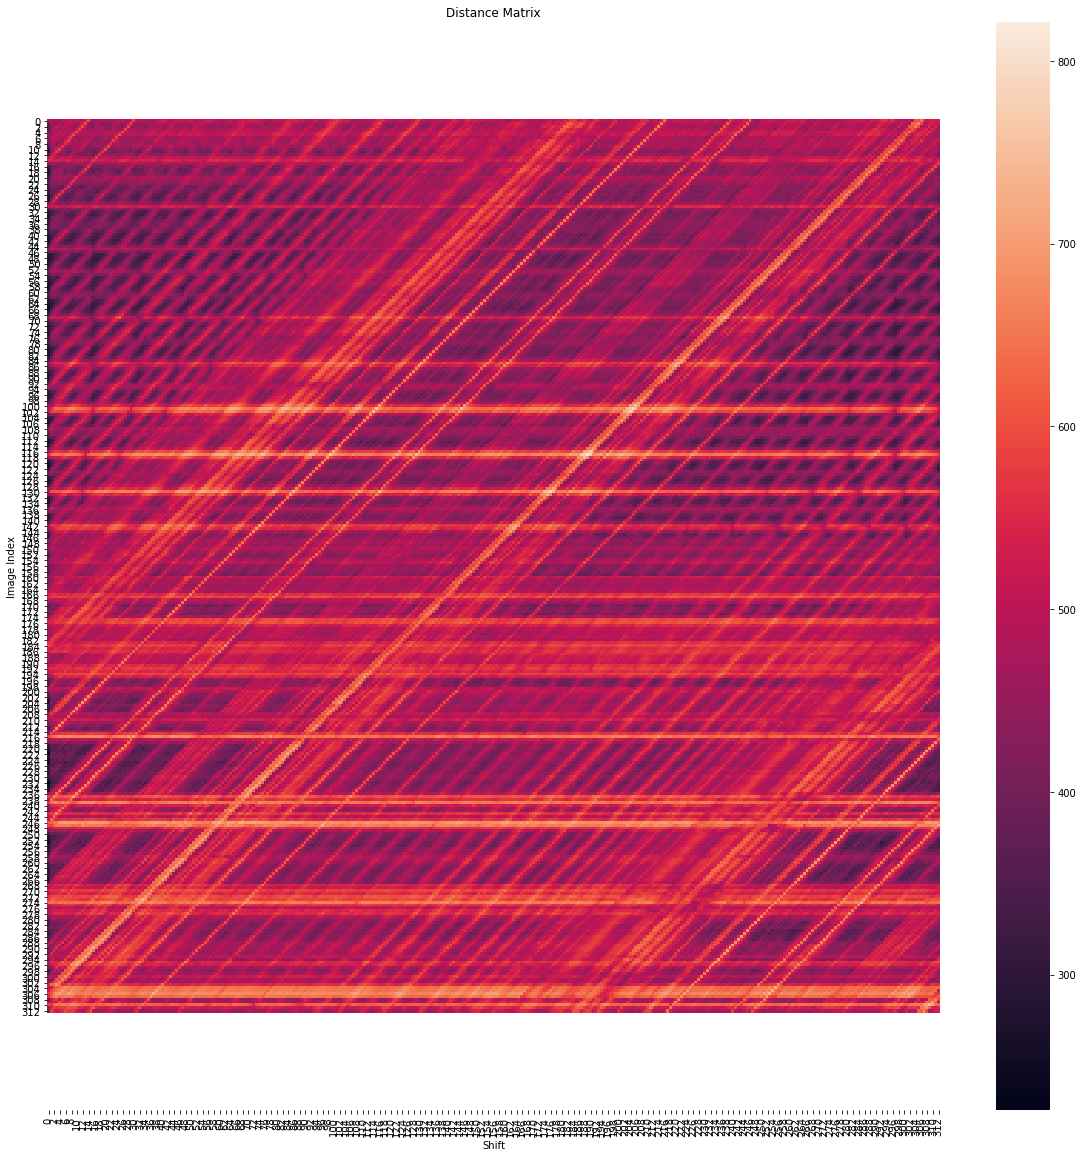

In [11]:
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig_size = [20,20]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(dst,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Distance Matrix')
plt.show()

### 3. analyse the feature maps

In [7]:
print('Min, Max and Mean of Distances:')
print(np.min(dst), np.max(dst), np.average(dst))
lower, higher = np.min(dst), np.max(dst)

dst_t, dst_f = dst[:,0], dst[:,1:]
#print(dst_t.shape, dst_f.shape)
print('Min, Max and Mean of paired images:', np.min(dst_t), np.max(dst_t), np.mean(dst_t))
print('Min, Max and Mean of unpaired images:', np.min(dst_f), np.max(dst_f), np.mean(dst_f))

print('Sorted distance of paired images:')
print(np.sort(dst_t))

print('First n sorted distance of unpaired images:')
print(np.sort(dst_f.flatten())[:n])

Min, Max and Mean of Distances:
226.04153178309969 821.0970476131091 496.34303403653547
Min, Max and Mean of paired images: 226.04153178309969 627.7708746139512 377.60781397099777
Min, Max and Mean of unpaired images: 289.8172278380296 821.0970476131091 496.7235956393097
Sorted distance of paired images:
[226.04153178 243.17722869 248.76639375 250.89614085 251.34866018
 251.68232181 252.99658052 253.01609618 253.27849954 257.85267448
 260.94984393 261.83960946 262.92774576 264.83847809 264.99316413
 265.29383699 266.70844804 267.23748888 268.11782927 268.9155379
 269.41359596 269.47863837 269.8674822  270.3873301  271.46921709
 271.4962343  271.51394176 272.80989689 272.84191113 273.37345853
 273.57675949 274.24265593 274.78405959 274.95426699 276.17063743
 277.40742467 277.89346161 278.71952745 278.88489847 279.3749213
 280.10855168 280.37524099 280.39653955 280.46000015 281.15949498
 282.30526695 283.04429553 283.12296063 283.13753447 283.95018317
 283.99643069 284.12373972 285.99185

TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:
(209, 9822, 87834, 104, 0.6677316293929713, 0.10057753747849595, 0.898682236217579, 0.020835410228292293, 0.6677316293929713, 0.040409899458623354)


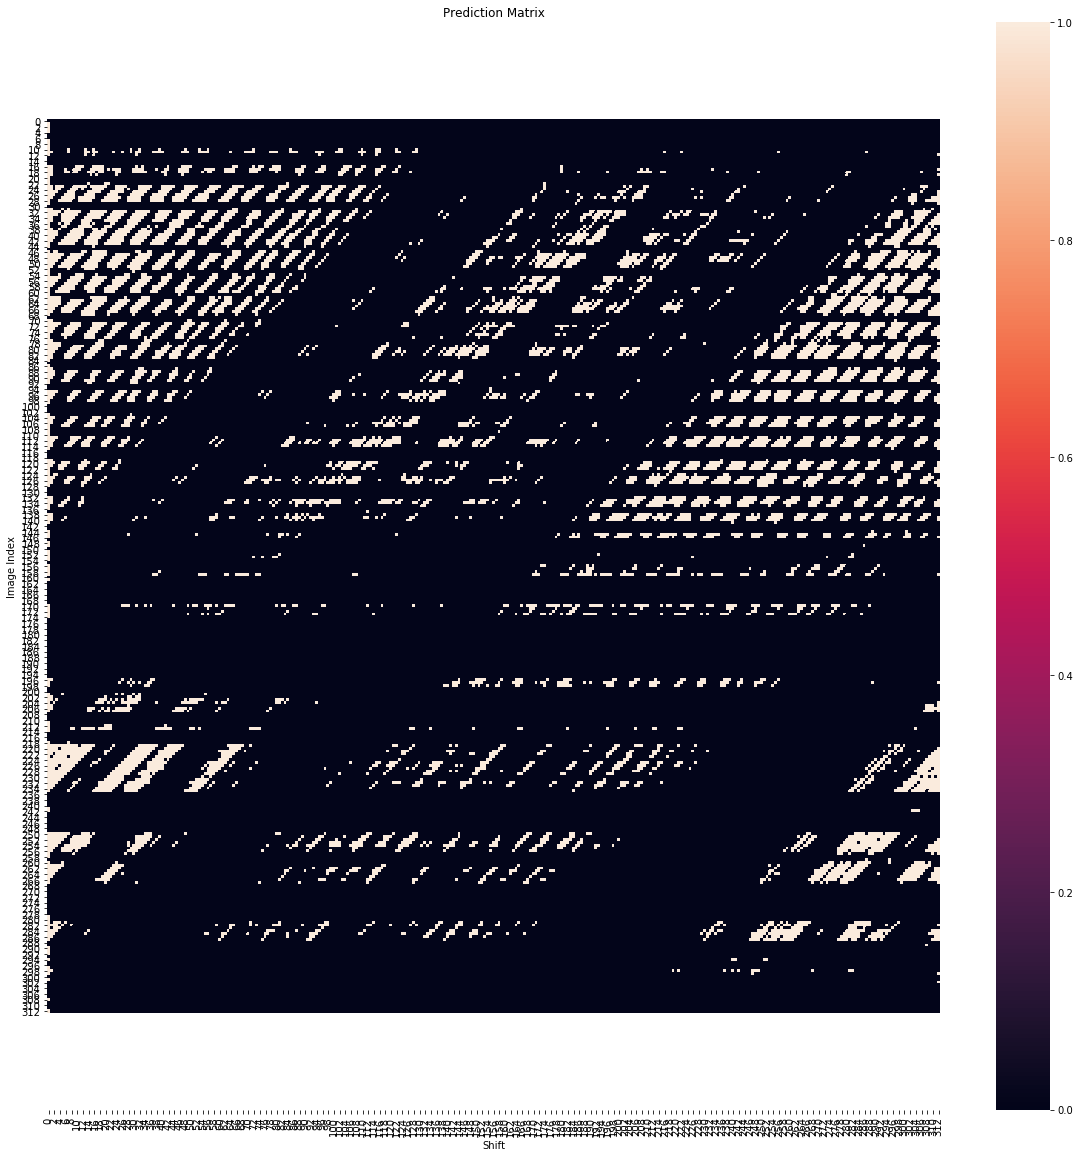

In [22]:
def predict(dst, threshold):
    return (dst <= threshold).astype(np.int)
def ground_truth(dst):
    n = dst.shape[0]
    gt = np.zeros((n,n)).astype(np.int)
    gt[:,0] = 1
    return gt
def confusion_matrix(pred, gt):
    n = gt.shape[0]
    TP = np.sum(gt[:,0] == pred[:,0])
    FN = np.sum(gt[:,0] != pred[:,0])
    TN = np.sum(gt[:,1:] == pred[:,1:])
    FP = np.sum(gt[:,1:] != pred[:,1:])
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

threshold = 410
pred = predict(dst, threshold)
gt = ground_truth(dst)

print("TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:")
print(confusion_matrix(pred, gt))
#%matplotlib inline
plt.axis('equal')
ax = sns.heatmap(pred,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Prediction Matrix')
plt.show()

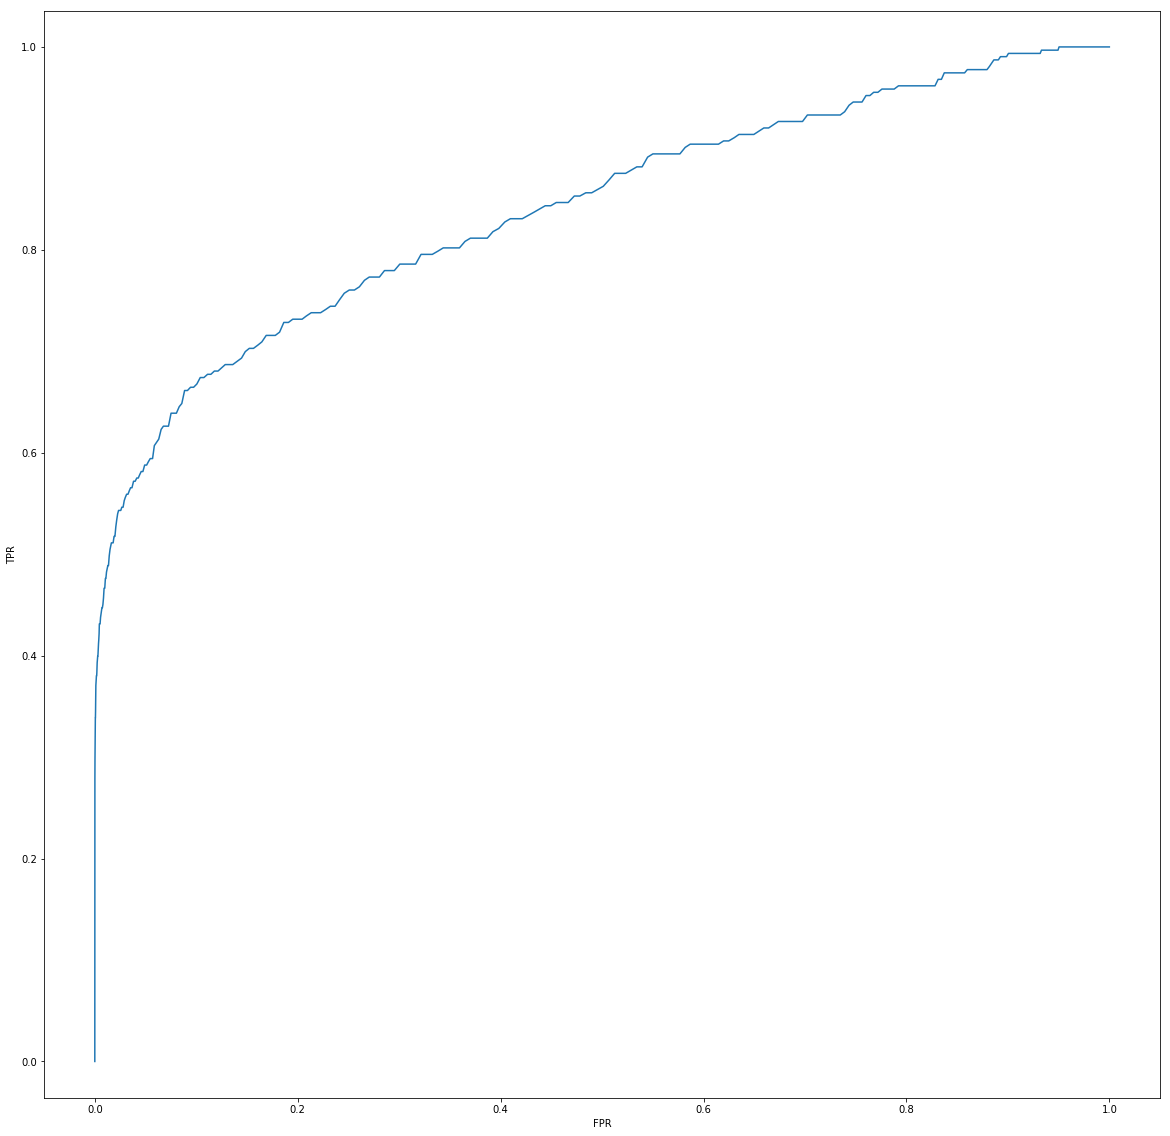

In [15]:
# Draw ROC curve
np.seterr(divide='ignore',invalid='ignore')
ROC_x, ROC_y = [0], [0]
for threshold in range(int(lower),int(higher)+1):
    pred = predict(dst, threshold)
    gt = ground_truth(dst)
    conf_mat = confusion_matrix(pred, gt)
    x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
    ROC_x.append(x)
    ROC_y.append(y)
ROC_x.append(1)
ROC_y.append(1)
#%matplotlib inline
plt.plot(ROC_x, ROC_y)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('equal')
plt.show()